# C02 EMISIONES

### 1 - IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import prince
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
cars_resumen_raw = pd.read_csv('2022_Cars_Raw.csv')

### 2 - ELIMINAMOS COLUMNAS

In [3]:
cars_resumen_raw.columns

Index(['Vehicle Identifier', 'OBFCM data source', 'OBFCM ReportingPeriod',
       'Total fuel consumed (lifetime) (l)',
       'Total distance travelled (lifetime) (km)',
       'Total distance travelled in charge depleting operation with engine off (lifetime) (km)',
       'Total distance travelled in charge depleting operation with engine running (lifetime) (km)',
       'Total distance travelled in driver-selectable charge increasing operation (lifetime) (km)',
       'Total fuel consumed in charge depleting operation (lifetime) (l)',
       'Total fuel consumed in driver-selectable charge increasing operation (lifetime) (l)',
       'Total grid energy into the battery (lifetime) (kWh)', 'Country', 'VFN',
       'Mp', 'Mh', 'Man', 'T', 'Va', 'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'M (kg)',
       'Mt', 'Ewltp (g/km)', 'Ft', 'Fm', 'Ec (cm3)', 'Ep (KW)', 'Z (Wh/km)',
       'IT', 'Erwltp (g/km)', 'Year', 'Fuel consumption',
       'Electric range (km)', 'Used in calculation'],
      dtype='obj

In [4]:
cars_resumen_raw = cars_resumen_raw.drop(columns = ['Vehicle Identifier','OBFCM data source','VFN','Mp','Mh','Man','T','Va','Ve','Cr','Mt','IT', 'Used in calculation','Year'])

In [5]:
cars_resumen_raw.shape

(3769313, 23)

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 3 - RENOMBRADO DE COLUMNAS

In [6]:
tipo_map = {
    "petrol": "gasolina",
    "petrol/electric": "hibrido gasolina",
    "diesel": "diesel",
    "diesel/electric": "hibrido diesel",
    "electric": "combustibles alternativos",
    "e85": "combustibles alternativos",
    "lpg": "combustibles alternativos",
    "ng": "combustibles alternativos",
    "ng-biomethane": "combustibles alternativos",
    "unknown": "combustibles alternativos"
}

In [7]:
cars_resumen_raw['Ft'] = cars_resumen_raw['Ft'].str.lower().replace(tipo_map)

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 4 - GENERAMOS NUEVO DF

In [8]:
def generar_tabla_resumen(df):
    df_filtrado = df[df['Total distance travelled (lifetime) (km)'] >= 7000]
    distancia = df_filtrado['Total distance travelled (lifetime) (km)']
    combustible = df_filtrado['Total fuel consumed (lifetime) (l)']
    electricidad = df_filtrado['Total grid energy into the battery (lifetime) (kWh)']
    tipo = df_filtrado['Ft']
    
    emisiones_combustible = {
        'gasolina': 2.31,
        'diesel': 2.61,
        'hibrido gasolina': 2.31,
        'hibrido diesel': 2.61
    }
    
    emision_kwh = 0.25
    emision_litro = tipo.map(emisiones_combustible)
    impacto_combustible = combustible * emision_litro
    impacto_electrico = electricidad * emision_kwh
    co2_total = impacto_combustible.fillna(0) + impacto_electrico.fillna(0)
    co2_por_km = co2_total / distancia
    
    # Filtrar por emisiones menores o iguales a 1
    mask = (co2_por_km <= 1) & (co2_por_km > 0.05)
    resumen = pd.DataFrame({
        'Km recorridos totales': distancia[mask].round(2),
        'Consumo de combustibles (l)': combustible[mask].round(2),
        'Consumo kWh': electricidad[mask],
        'Emisiones de CO2 por km (kg/km)': co2_por_km[mask],
        'Tipo de combustible': tipo[mask]
    })
    
    return resumen, df_filtrado[mask]

In [9]:
cars_resumen, cars_filtrado = generar_tabla_resumen(cars_resumen_raw)

In [10]:
cars_resumen.shape

(2209652, 5)

In [11]:
def añadir_columnas_resumen(resumen, original_filtrado):
    resumen["Pais"] = original_filtrado["Country"].values
    resumen["Marca"] = original_filtrado["Mk"].values
    resumen["Modelo"] = original_filtrado["Cn"].values
    resumen["Masa (kg)"] = original_filtrado["M (kg)"].values
    resumen["Potencia (cm3)"] = original_filtrado["Ec (cm3)"].values

In [12]:
añadir_columnas_resumen(cars_resumen, cars_filtrado)

In [13]:
cars_resumen.head()

,Km recorridos totales,Consumo de combustibles (l),Consumo kWh,Emisiones de CO2 por km (kg/km),Tipo de combustible,Pais,Marca,Modelo,Masa (kg),Potencia (cm3)
0,13383.8,974.90,NaN,0.168265,gasolina,ES,RENAULT,ARKANA,1411,1332.0
1,18043.4,1338.21,NaN,0.171324,gasolina,ES,RENAULT,MEGANE,1289,1332.0
2,8305.0,744.02,NaN,0.206946,gasolina,ES,RENAULT,ARKANA,1411,1332.0
3,32143.9,2115.02,NaN,0.151995,gasolina,ES,RENAULT,CAPTUR,1322,1332.0
5,13233.5,1374.17,NaN,0.239871,gasolina,ES,RENAULT,ARKANA,1411,1332.0


In [14]:
cars_resumen.shape

(2209652, 10)

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 5 - ANALISIS EXPLORATORIO

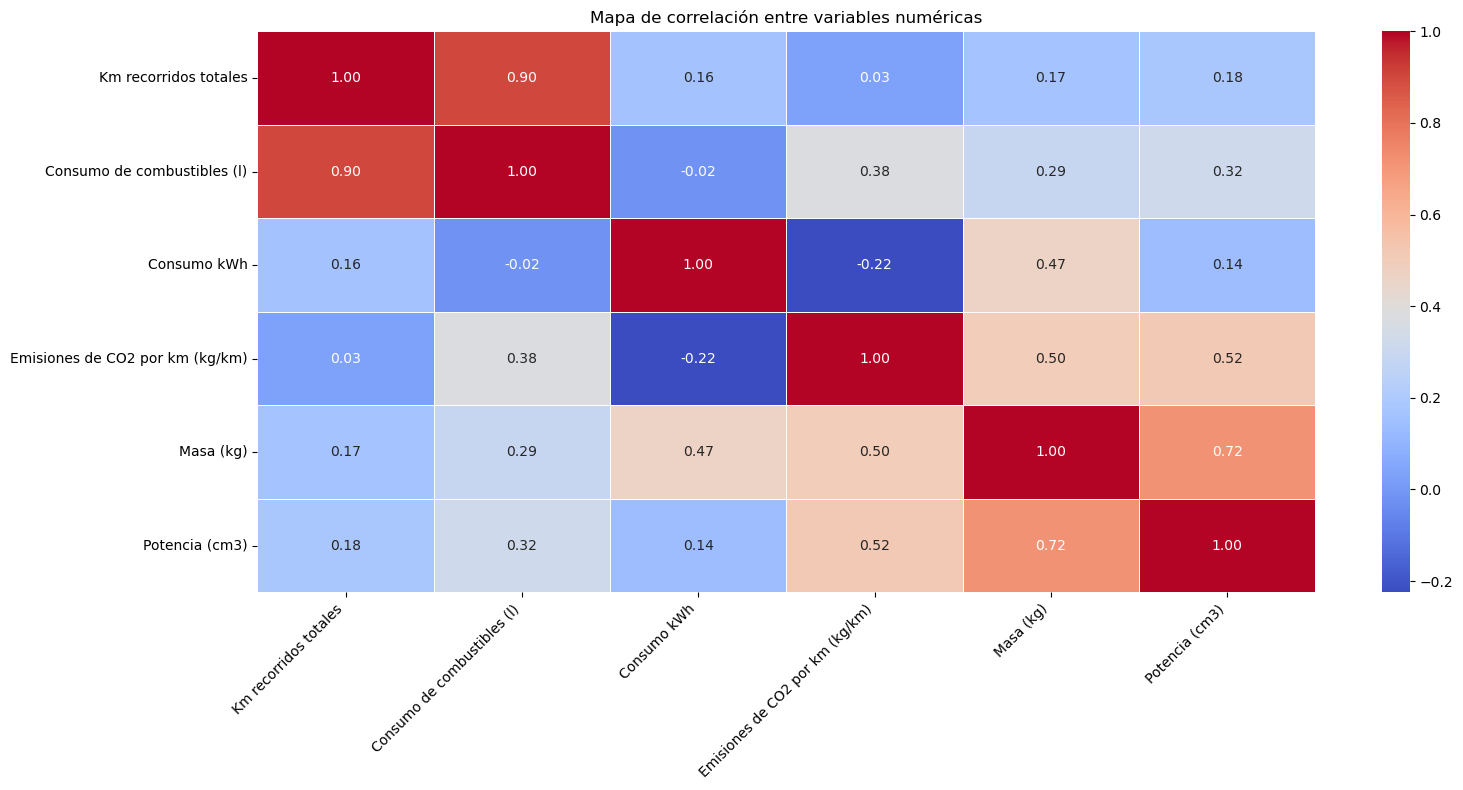

In [15]:
df_numerico = cars_resumen.select_dtypes(include=["float64", "int64"])

matriz_correlacion = df_numerico.corr()

plt.figure(figsize=(16, 8)) 
sns.heatmap(matriz_correlacion, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de correlación entre variables numéricas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

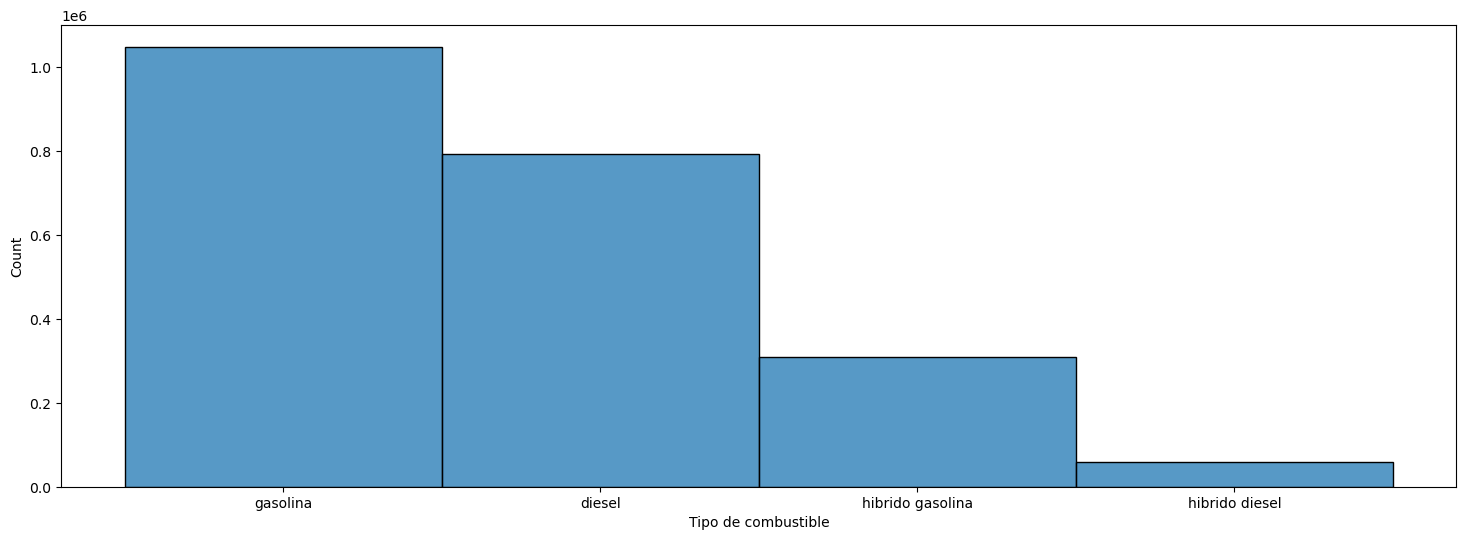

In [16]:
plt.figure(figsize=(18, 6))
sns.histplot(cars_resumen['Tipo de combustible'])
plt.show()

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 6 - LIMPIEZA 'Marca' 

In [17]:
cars_resumen.Marca = cars_resumen.Marca.str.upper().str.strip().str.replace(r"[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True)

In [18]:
for marca in cars_resumen.Marca.unique():
    print(marca)

RENAULT
DACIA
VOLKSWAGEN VW
VOLVO
VOLKSWAGEN
PEUGEOT
CITROEN
MITSUBISHI
CITROEN DS
DS
DS AUTOMOBILES
FORD
NISSAN
FIAT
ABARTH
JEEP
LANCIA
KIA
LAND ROVER
JAGUAR
SEAT
HYUNDAI
CUPRA
HONDA
FORD D
SUZUKI
NILSSON
NILSSON XC90 AMBULANS
HYUNDAIGENESIS
TOYOTA
MERCEDESBENZ
MITSUBISHI MOTORS THAILAND
AUDI
OPEL
SKODA
VOLVO NILSSON
MASERATI
LEXUS
PORSCHE
MERCEDES AMG
OPEL VAUXHALL
CITROENDS
FERRARI
SSANGYONG
VW
MAZDA
SUBARU
FORDCNGTECHNIK
FORDCNG TECHNIK
ŠKODA
VOLKSWAGENVW
POLESTAR
KODA
VOLVO CAR CORPORATION
CHRYSLER
MG
MG ROEWE
CADILLAC
FORD WERKE
ALPINE
VOLKSWAGEN AG
FORD USA
ALFA ROMEO
CHEVROLET
FORD CNGTECHNIK
JAGUAR LAND ROVER LIMITED
PALLARES
MITSUBISHI MOTORS CORPORATION
AUDI AG
AUTOMOBILES PEUGEOT
FCA ITALY
BLUCAMP
BOECKAMANN
MOTO STAR
BMW
TRIPOD
FORD MOTOR COMPANY
ROLLSROYCE
FORDCNGTECKNIK
SIN MARCA
HURTAN
MINI
LANDROVER LTD


In [19]:
marcas_cars = {
    'AUDI AG': 'AUDI',
    'AUDI SPORT GMBH': 'AUDI',
    'AUTOMOBILES CITROEN': 'CITROEN',
    'AUTOMOBILES PEUGEOT': 'PEUGEOT',
    'CITROEN DS': 'CITROEN',
    'CITROENDS': 'CITROEN',
    'DS AUTOMOBILES': 'DS',
    'FORD D': 'FORD',
    'FORD USA': 'FORD',
    'FORD CNGTECHNIK': 'FORD',
    'FORDCNG TECHNIK' : 'FORD',
    'FORDCNGTECHNIK' : 'FORD',
    'FORDCNGTECKNIK': 'FORD',
    'FORD MOTOR COMPANY': 'FORD',
    'FORD WERKE': 'FORD',
    'HYUNDAIGENESIS': 'HYUNDAI',
    'JAGUAR LAND ROVER LIMITED': 'LAND ROVER',
    'LANDROVER': 'LAND ROVER',
    'LANDROVER LTD': 'LAND ROVER',
    'MG ROEWE': 'MG',
    'ABARTH': 'FIAT',
    'MAGYAR SUZUKI':'SUZUKI',
    'MAZDA MOTOR CORPORATION': 'MAZDA',
    'MERCEDESBENZ': 'MERCEDES',
    'MERCEDES AMG': 'MERCEDES',
    'MITSUBISHI MOTORS THAILAND': 'MITSUBISHI',
    'MITSUBISHI MOTORS CORPORATION': 'MITSUBISHI',
    'NILSSON': 'VOLVO',
    'NILSSON XC90 AMBULANS': 'VOLVO',
    'OPEL VAUXHALL': 'OPEL',
    'OPEL AUTOMOBILE GMBH': 'OPEL',
    'PORSCHE 718 CAYMAN GTS': 'PORSCHE',
    'PSA AUTOMOBILES SA': 'PEUGEOT',
    'VOLKSWAGEN AG': 'VOLKSWAGEN',
    'VOLKSWAGEN VW': 'VOLKSWAGEN',
    'VOLKSWAGENVW': 'VOLKSWAGEN',
    'VOLVO CAR CORPORATION': 'VOLVO',
    'VOLVO NILSSON': 'VOLVO',
    'VW': 'VOLKSWAGEN',
    'ŠKODA': 'SKODA',
    'KODA':'SKODA',
    'REMOLQUES RAMIREZ':'OPEL',
    'BLUCAMP':'FIAT',
    'TRIPOD':'FORD',
    'PALLARES':'AUDI',
    'CLAYSONSANTANA':'SEAT',
    'MOTO STAR':'FORD',
    'FCA ITALY':'FIAT',
    'RHONSOM':'JEEP',
    'ROLLSROYCE': 'ROLLS ROYCE',
    'BOECKAMANN' : 'FIAT',
    'SIN MARCA':'SIN MARCA'
}

In [20]:
cars_resumen.Marca = cars_resumen.Marca.replace(marcas_cars)

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 7 - LIMPIEZA 'Modelo' 

In [21]:
cars_resumen.Modelo = cars_resumen.Modelo.str.upper().str.strip().str.replace(r"[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True)

In [22]:
def unificar_modelos_por_marca(cars_resumen, marca, tipo_map):
    cars_resumen.loc[cars_resumen['Marca'] == marca, 'Modelo'] = (
        cars_resumen.loc[cars_resumen['Marca'] == marca, 'Modelo']
        .map(tipo_map)
    )
    return cars_resumen

In [23]:
renault_map = {
    'ARKANA': 'ARKANA',
    'ARKANA ETECH': 'ARKANA',
    'MEGANE': 'MEGANE',
    'MEGANE ETECH PLUGIN HYBRID': 'MEGANE',
    'CAPTUR': 'CAPTUR',
    'CAPTUR ETECH HYBRID': 'CAPTUR',
    'CAPTUR ETECH PLUGIN HYBRID': 'CAPTUR',
    'CLIO': 'CLIO',
    'CLIO ETECH HYBRID': 'CLIO',
    'KOLEOS': 'KOLEOS',
    'KADJAR': 'KADJAR',
    'SCENIC': 'SCENIC',
    'TWINGO': 'TWINGO',
    'TRAFIC': 'TRAFIC',
    'TALISMAN': 'TALISMAN',
    'ESPACE': 'ESPACE',
    'KANGOO': 'KANGOO',
    'AUSTRAL': 'AUSTRAL',
    'MASTER': 'MASTER'
}
land_rover_map = {
    'RANGE ROVER VELAR': 'RANGE ROVER',
    'RANGE ROVER EVOQUE': 'RANGE ROVER',
    'DEFENDER': 'DEFENDER',
    'DISCOVERY SPORT': 'DISCOVERY',
    'RANGE ROVER SPORT': 'RANGE ROVER',
    'RANGE ROVER': 'RANGE ROVER',
    'RANGE ROVER EVOGUE': 'RANGE ROVER EVOQUE',
    'RANGE': 'RANGE ROVER',
    'RANGER': 'RANGE ROVER',
    'EVOQUE': 'RANGE ROVER EVOQUE',
    
    'DISCOVERY SPORT P300E RDYNAM': 'DISCOVERY SPORT',
    'DISCOVERY SPORT P300E SE AWD': 'DISCOVERY SPORT',
    'DISCOVERY SPORT P300E AWD AUT': 'DISCOVERY SPORT',
    'DISCOVERY SPORT P300E S AWD A': 'DISCOVERY SPORT',
    'RANGE ROVER EVOQUE P300E AWD': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE P300E SE A': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE P300E RDY': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE P300E S AW': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE P300E AUTO': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER VELAR P400E S AWD': 'RANGE ROVER VELAR',
    'RANGE ROVER VELAR P400E RDYNA': 'RANGE ROVER VELAR',
    'RANGE ROVER VELAR P400E RDYN': 'RANGE ROVER VELAR',
    'RANGE ROVER VELAR P400E LIMIT': 'RANGE ROVER VELAR',
    
    'DEFENDER 110': 'DEFENDER',
    'DEFENDER 90': 'DEFENDER',
    'RANGE ROVER LWB': 'RANGE ROVER',
    'RANGE ROVER SPORT SVR': 'RANGE ROVER SPORT',
    'RANGE ROVER SV': 'RANGE ROVER',
    'VELAR': 'RANGE ROVER VELAR',
    'RANGE ROVER SPORT P400E PHEV T': 'RANGE ROVER SPORT',
    'RANGE ROVER SPORT P400E PHEV H': 'RANGE ROVER SPORT',
    
    'DEFENDER 110 P400E XDYNAMIC S': 'DEFENDER',
    'DEFENDER 110 P400E SE': 'DEFENDER',
    'RANGE ROVER VELAR D300 RDYNA': 'RANGE ROVER VELAR',
    'RANGE ROVER VELAR D300 HSE': 'RANGE ROVER VELAR',
    'RANGE ROVER VELAR D300 SE AWD': 'RANGE ROVER VELAR',
    
    'RANGE ROVER EVOQUE P200 S AWD': 'RANGE ROVER EVOQUE',
    'RANGE ROVER SPORT D300 DYNAMIC': 'RANGE ROVER SPORT',
    'RANGE ROVER D250 HSE AWD AUT': 'RANGE ROVER',
    'RANGE ROVER EVOQUE P200 SE AWD': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER SPORT D350 FIRST E': 'RANGE ROVER SPORT',
    'RANGE ROVER EVOQUE P200 RDYN': 'RANGE ROVER EVOQUE',
    'RANGE ROVER D300 AUTOBIOGRAPHY': 'RANGE ROVER',
    'RANGE ROVER EVOQUE P300 HST A': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER D350 AUTOBIOGRAPHY': 'RANGE ROVER',
    'RANGE ROVER D350 HSE AWD AUT': 'RANGE ROVER',
    'RANGE ROVER D350 SE AWD AUT L': 'RANGE ROVER',
    
    'DISCOVERY SPORT P200 AWD AUT': 'DISCOVERY SPORT',
    'DISCOVERY SPORT P200 RDYNAMI': 'DISCOVERY SPORT',
    'DISCOVERY SPORT P200 S AWD AU': 'DISCOVERY SPORT',
    'RANGE ROVER EVOQUE VAN': 'RANGE ROVER EVOQUE',
    
    'DISCOVERY4': 'DISCOVERY',
    'JAGUAR XF': 'JAGUAR',
    'DEFENDER 130': 'DEFENDER',
    
    'DISCOVERY SPORT D165 SE AWD A': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D200 RDYNAMI': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D165 SE AWD AU': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D200 S AWD AU': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D165 RDYNAMI': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D165 URBAN ED': 'DISCOVERY SPORT',
    
    'RANGE ROVER SPORT P440E DYNAMI': 'RANGE ROVER SPORT',
    'RANGE ROVER SPORT P440E SE AWD': 'RANGE ROVER SPORT',
    'RANGE ROVER P440E SE AWD AUT': 'RANGE ROVER',
    'RANGE ROVER SPORT P510E AUTOBI': 'RANGE ROVER SPORT',
    
    'RANGE ROVER P510E HSE AWD AUT': 'RANGE ROVER',
    'RANGE ROVER P440E HSE AWD AUT': 'RANGE ROVER',
    'RANGE ROVER EVOQUE P300E BRON': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER VELAR D200 S AWD': 'RANGE ROVER VELAR',
    'DISCOVERY SPORT D165 RDYNAMIC': 'DISCOVERY SPORT',
    'DISCOVERY SPORT D165 SE FWD': 'DISCOVERY SPORT',
    
    'RANGE ROVER VELAR D200 RDYNA': 'RANGE ROVER VELAR',
    'RANGE ROVER EVOQUE D165 S AWD': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE D165 AWD AU': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER EVOQUE D200 S AWD': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE D165 RDYN': 'RANGE ROVER EVOQUE',
    'RANGE ROVER EVOQUE D165 SE AWD': 'RANGE ROVER EVOQUE',
    
    'RANGE ROVER EVOQUE D200 RDYN': 'RANGE ROVER EVOQUE',
    'RANGE ROVER SPORT D300 HSE AWD': 'RANGE ROVER SPORT',
    'RANGE ROVER VELAR P250 RDYNA': 'RANGE ROVER VELAR',
    
    'DISCOVERY D300 RDYNAMIC SE AW': 'DISCOVERY',
    'DISCOVERY D250 RDYNAMIC SE AW': 'DISCOVERY',
    'RANGE ROVER SPORT D250 HSE A': 'RANGE ROVER SPORT',
    'DISCOVERY D300 SE AWD': 'DISCOVERY',
    
    'DISCOVERY D250 RDYNAMIC HSE A': 'DISCOVERY',
    'RANGE ROVER SPORT D250 HSE DY': 'RANGE ROVER SPORT',
    'RANGE ROVER D300 HSE': 'RANGE ROVER',
    'DISCOVERY D300 RDYNAMIC HSE A': 'DISCOVERY',
    
    'RANGE ROVER SPORT D300 HSE DYN': 'RANGE ROVER SPORT',
    'RANGE ROVER VELAR P250 LE3 AW': 'RANGE ROVER VELAR',
    'DEFENDER 90 D200 S': 'DEFENDER',
    'DEFENDER 90 D200': 'DEFENDER',
    
    'DEFENDER 90 D250 XDYNAMIC SE': 'DEFENDER',
    'DEFENDER 90 D200 SE AWD AUT': 'DEFENDER',
    'DEFENDER 110 D200 SE AWD AUT': 'DEFENDER',
    'DEFENDER 110 D250 XDYNAMIC S': 'DEFENDER',
    
    'DEFENDER 90 D200 SE': 'DEFENDER',
    'DEFENDER 110 D250 SE AWD AUT': 'DEFENDER',
    'DEFENDER 110 D300 XDYNAMIC S': 'DEFENDER',
    'DEFENDER 110 D250 XDYNAMIC H': 'DEFENDER',
    
    'RANGE ROVER EVOQUE D200 SE AWD': 'RANGE ROVER EVOQUE',
    'RANGE ROVER SPORT 30 I6 D300': 'RANGE ROVER SPORT',
    'DEFENDER 110 D300 XDYNAMIC H': 'DEFENDER',
    
    'DEFENDER 110 D200 XDYNAMIC S': 'DEFENDER',
    'DEFENDER 110 D200 S AWD AUT': 'DEFENDER',
    'DEFENDER 110 D250 S AWD AUT': 'DEFENDER',
    
    'DEFENDER 110 D250 SE': 'DEFENDER',
    'DEFENDER 110 D300 SE AWD AUT': 'DEFENDER',
    'DEFENDER 110 D300 X AWD AUT': 'DEFENDER',
    'DEFENDER 110 D250 XS EDITION': 'DEFENDER',
    
    'DEFENDER 130 D300 FIRST EDITIO': 'DEFENDER',
    'DEFENDER 110 D200 SE': 'DEFENDER',
    'RANGE ROVER P400 HSE': 'RANGE ROVER',
    'DEFENDER 110 D200 S': 'DEFENDER',
    
    'RANGE ROVER SPORT P400 MHEV HS': 'RANGE ROVER SPORT',
    'DEFENDER 90 P400 X AWD AUT': 'DEFENDER',
    'DEFENDER 110 P400 XDYNAMIC S': 'DEFENDER',
    'RANGE ROVER P530 AUTOBIOGRAPHY': 'RANGE ROVER',
    'DEFENDER 130 P400D': 'DEFENDER',
    'DEFENDER 130 P400D S': 'DEFENDER'
}
land_rover_update_map = {
    'RANGE ROVER': 'RANGE ROVER',
    'RANGE ROVER EVOQUE': 'RANGE ROVER',
    'RANGE ROVER VELAR': 'RANGE ROVER',
    'RANGE ROVER SPORT': 'RANGE ROVER',
    'DEFENDER': 'DEFENDER',
    'DISCOVERY': 'DISCOVERY',
    'DISCOVERY SPORT': 'DISCOVERY',
    'JAGUAR': 'RANGE ROVER'
}

volvo_map = {
    'T5 TWIN ENGINE': 'XC40',
    '15 T AUT FWD': 'XC40',
    '15 T MAN FWD': 'XC40',
    '20 T AUT FWD': 'XC40',
    '20 T AUT AWD': 'XC40',
    
    'T8 TWIN ENGINE': 'XC60',
    '20 TD AUT AWD': 'XC60',
    '20 TD AUT FWD': 'XC60',
    '20 T AUT FWD': 'XC60',
    '20 T AUT AWD': 'XC60',
    
    'V60 CROSS COUNTRY': 'V60',
    'S90 T8 TWIN ENGINE': 'S90',
    'V90 CROSS COUNTRY': 'V90',
    'S60 T8 TWIN ENGINE': 'S60',
    'T6 TWIN ENGINE': 'V60',
    'T8 TWIN ENGINE': 'V60',
    '20 TD AUT FWD': 'V60',
    '20 TD AUT AWD': 'V60',
    'V60 20 T AUT AWD': 'V60',
    'V90 20 TD AUT AWD': 'V90',
    
    '20 TD AUT AWD': 'XC90',
    'T8 TWIN ENGINE': 'XC90',
    'V90 20 T AUT AWD': 'V90',
    'NILSSON XC90 AMBULANCE': 'XC90',
    'NILSSON V90 HEARSE': 'V90',
    'V90 20 T AUT FWD': 'V90',
    'V90 T8 TWIN ENGINE': 'V90',
    
    'S90 20 TD AUT AWD': 'S90',
    
    'C40': 'XC40',
    
    'V60 20 T AUT AWD': 'V60',
    'S60': 'S60',
    
    'NILSSON XC90': 'XC90',
    'VC90': 'XC90',
    'S60 T6 TWIN ENGINE': 'S60',
    'V60 CROSS COUNTRY 20 TD AUT AWD': 'V60',
    'V90 CROSS COUNTRY 20 TD AUT AWD': 'V90',
    
    'NILSSON 3DOOR V90 HEARSE': 'V90'
}
volkswagen_map = {
    'PASSAT': 'PASSAT',
    'POLO': 'POLO',
    'TCROSS': 'T-CROSS',
    'UP': 'UP',
    'GOLF': 'GOLF',
    'TIGUAN': 'TIGUAN',
    'TROC': 'T-ROC',
    'TOUAREG': 'TOUAREG',
    'ARTEON': 'ARTEON',
    'TOURAN': 'TOURAN',
    'TOUAREG EHYBRID': 'TOUAREG',
    'TAIGO': 'TAIGO',
    'GOLF GTE': 'GOLF',
    'TOUAREG R': 'TOUAREG',
    'MULTIVAN': 'MULTIVAN',
    'CADDY': 'CADDY',
    'KOMBI': 'KOMBI',
    'CALIFORNIA BEACH': 'CALIFORNIA',
    'T ROC': 'T-ROC',
    'CALIFORNIA': 'CALIFORNIA',
    'T CROSS': 'T-CROSS',
    'TROC 15 TSI': 'T-ROC',
    'TOURAN 20 TDI AUT': 'TOURAN',
    'TIGUAN 20 TDI AUT': 'TIGUAN',
    'TIGUAN 20 TDI 4M AUT': 'TIGUAN',
    'ARTEON 20 TDI AUT': 'ARTEON',
    'ARTEON 20 TDI 4M AUT': 'ARTEON',
    'ARTEON 20 TSI 4M AUT': 'ARTEON',
    'GOLF 10 TSI': 'GOLF',
    'TCROSS 15 TSI AUT': 'T-CROSS',
    'TROC 15 TSI AUT': 'T-ROC',
    'GOLF 15 TSI': 'GOLF',
    'GOLF 15 TSI AUT': 'GOLF',
    'PASSAT VARIANT 20 TDI': 'PASSAT',
    'PASSAT VARIANT 20 TDI AUT': 'PASSAT',
    'CRAFTER': 'VOLKSWAGEN',
    'TAIGO 10 TSI AUT': 'TAIGO',
    'POLO 10 TSI': 'POLO',
    'TCROSS 10 TSI': 'T-CROSS',
    'GOLF 20 TDI AUT': 'GOLF',
    'GOLF 20 TSI AUT': 'GOLF',
    'POLO 10 TSI AUT': 'POLO',
    'TIGUAN 15 TSI AUT': 'TIGUAN',
    'TIGUAN 20 TSI 4M AUT': 'TIGUAN',
    'TOUAREG 30 TDI 4M AUT': 'TOUAREG',
    'TOUAREG 30 TSI 4M AUT': 'TOUAREG',
    'TOURAN 15 TSI': 'TOURAN',
    'TOURAN 15 TSI AUT': 'TOURAN',
    'TOURAN 20 TDI': 'TOURAN',
    'TAIGO 10 TSI': 'TAIGO',
    'TROC 10 TSI': 'T-ROC',
    'TROC 20 TDI AUT': 'T-ROC',
    'TROC 20 TDI 4M AUT': 'T-ROC',
    'ARTEON 14 TSI AUT': 'ARTEON',
    'ARTEON 15 TSI': 'ARTEON',
    'GOLF VARIANT 20 TDI 4M AUT': 'GOLF',
    'TIGUAN 20 TDI': 'TIGUAN',
    'GOLF 20 TSI 4M AUT': 'GOLF',
    'GOLF VARIANT 10 TSI': 'GOLF',
    'GOLF VARIANT 10 TSI AUT': 'GOLF',
    'GOLF VARIANT 15 TSI': 'GOLF',
    'TROC 20 TDI': 'T-ROC',
    'GOLF VARIANT 15 TSI AUT': 'GOLF',
    'GOLF VARIANT 20 TDI': 'GOLF',
    'GOLF VARIANT 20 TDI AUT': 'GOLF',
    'Q5': 'Q5',  # Asumiendo error o mezcla en datos
    'PASSAT VARIANT 15 TSI': 'PASSAT',
    'PASSAT VARIANT 15 TSI AUT': 'PASSAT',
    'TROC 20 TSI 4M AUT': 'T-ROC',
    'TCROSS 10 TSI AUT': 'T-CROSS',
    'TRANSPORTER': 'TRANSPORTER',
    'TAIGO 15 TSI AUT': 'TAIGO',
    'TIGUAN 14 TSI AUT': 'TIGUAN',
    'TIGUAN 15 TSI': 'TIGUAN',
    'GOLF 20 TDI': 'GOLF',
    'PASSAT VARIANT 20 TDI 4M AUT': 'PASSAT',
    'PASSAT VARIANT 20 TSI 4M AUT': 'PASSAT',
    'PASSAT 15 TSI': 'PASSAT',
    'PASSAT 15 TSI AUT': 'PASSAT',
    'PASSAT 20 TDI': 'PASSAT',
    'PASSAT 20 TDI AUT': 'PASSAT',
    'PASSAT 20 TDI 4M AUT': 'PASSAT',
    'POLO 20 GTI AUT': 'POLO',
    'POLO 10 ': 'POLO',
    'GOLF 14 TSI AUT': 'GOLF',
    'PASSAT 20 TSI AUT': 'PASSAT',
    'UP 10 ': 'UP',
    'POLO 15 TSI AUT': 'POLO',
    'PASSAT VARIANT 20 TSI AUT': 'PASSAT',
    'UP TSI': 'UP',
    'TOUAREG EHYBRID 30 TSI 4M AUT': 'TOUAREG'
}
subaru_map = {
    'XV': 'XV',
    'FORESTER': 'FORESTER',
    'OUTBACK': 'OUTBACK',
    'FORESTER 20IMHEV PREMIUM': 'FORESTER',
    'IMPREZA': 'IMPREZA',
    'FORESTER 20IMHEV STYLE': 'FORESTER',
    'XV 20IMHEV STYLE XTRA': 'XV',
    'OUTBACK 25IL CVT ES TOURING': 'OUTBACK',
    'XV 20IMHEV PREMIUM': 'XV',
    'IMPREZA XV': 'IMPREZA'
}
polestar_map = {
    '1': 'POLESTAR',
    'POLESTAR 1': 'POLESTAR',
}
chrysler_map = {
    'RENEGADE': 'RENEGADE',
    'WRANGLER': 'WRANGLER',
    'WRANGLER UNLIMITED': 'WRANGLER',
    'COMPASS': 'COMPASS',
}
mg_map = {
    'MG ZS': 'ZS',
    'ZS': 'ZS',
    'MG HS': 'HS',
    'MG HS PHEV': 'HS',
    'HS PHEV': 'HS',
    'EHS': 'EHS',
    'MG EHS': 'EHS',
    'MG EHS PLUGIN HYBRID': 'EHS',
    'MG MG EHS PLUGIN HYBRID': 'EHS',   
    'MG RX6 PLUGIN HYBRID': 'RX6',
    'MG MG RX6 PLUGIN HYBRID': 'RX6',
    'MG EHS PLUGIN HYBRID RX6': 'RX6',
}
chevrolet_map = {
    'CORVETTE C8': 'CORVETTE',
    'CORVETTE': 'CORVETTE',
}
alfa_romeo_map = {
    # Tonale
    'TONALE': 'TONALE',
    'TONALE 15 MILD HYBRID': 'TONALE',
    'ALFA TONALE': 'TONALE',

    # Stelvio
    'STELVIO': 'STELVIO',
    'STELVIO QUADRIFOGLIO': 'STELVIO',
    'STELVIO 22 JTDM CA AWD SW': 'STELVIO',
    'STELVIO 20 TURBO CA AWD SW': 'STELVIO',
    'ALFA STELVIO': 'STELVIO',
    'ALFA ROMEO STELVIO': 'STELVIO',
    'STELVI0': 'STELVIO',  # error tipográfico
    'ST QUADRIFOGLIO': 'STELVIO',

    # Giulia
    'GIULIA': 'GIULIA',
    'ALFA GIULIA': 'GIULIA',
    'GIULIA QUADRIFOGLIO': 'GIULIA',
    'ALFA GIULIA QUADRIFOGLIO': 'GIULIA',
    'GIULIA GIULIA QUADRIFOGLIO': 'GIULIA',
    'GIULIA GTAM': 'GIULIA',
    'GIULIA GTA': 'GIULIA',
    'GIULIA 22 MULTIJET CA': 'GIULIA',
    'GIULIA 29 V6 QUADRIFOGLIO': 'GIULIA',
}
bmw_map = {
    '116D': 'SERIE 1',
    '116I': 'SERIE 1',
    '118D': 'SERIE 1',
    '118I': 'SERIE 1',
    '120D': 'SERIE 1',
    '120D XDRIVE': 'SERIE 1',
    '120I': 'SERIE 1',
    '128TI': 'SERIE 1',
    'M135I XDRIVE': 'SERIE 1',

    '216D': 'TOURER',
    '216D ACTIVE TOURER': 'TOURER',
    '216D GRAN TOURER': 'TOURER',
    '216I ACTIVE TOURER': 'TOURER',
    '216I GRAN TOURER': 'TOURER',
    '218D': 'TOURER',
    '218D ACTIVE TOURER': 'TOURER',
    '218D GRAN TOURER': 'TOURER',
    '218D XDRIVE ACTIVE TOURER': 'TOURER',
    '218D XDRIVE GRAN TOURER': 'TOURER',
    '218I': 'TOURER',
    '218I ACTIVE TOURER': 'TOURER',
    '218I GRAN TOURER': 'TOURER',
    '220D ACTIVE TOURER': 'TOURER',
    '220D GRAN TOURER': 'TOURER',
    '220D XDRIVE ACTIVE TOURER': 'TOURER',
    '220D XDRIVE GRAN TOURER': 'TOURER',
    '220I ACTIVE TOURER': 'TOURER',
    '220I GRAN TOURER': 'TOURER',
    '223I ACTIVE TOURER': 'TOURER',
    '225I XDRIVE ACTIVE TOURER': 'TOURER',
    '225XE IPERFORMANCE': 'TOURER',

    '318D': 'SERIE 3',
    '318I': 'SERIE 3',
    '320D': 'SERIE 3',
    '320D XDRIVE': 'SERIE 3',
    '320E': 'SERIE 3',
    '320E XDRIVE': 'SERIE 3',
    '320I': 'SERIE 3',
    '320I XDRIVE': 'SERIE 3',
    '330D': 'SERIE 3',
    '330D XDRIVE': 'SERIE 3',
    '330E': 'SERIE 3',
    '330E XDRIVE': 'SERIE 3',
    '330I': 'SERIE 3',
    '330I XDRIVE': 'SERIE 3',
    'M340D XDRIVE': 'SERIE 3',
    'M340I XDRIVE': 'SERIE 3',

    '316D': 'SERIE 3',
    '320E': 'SERIE 3',
    'M3': 'SERIE 3',
    'M3 COMPETITION': 'SERIE 3',
    'M3 COMPETITION M XDRIVE': 'SERIE 3',

    '430D': 'SERIE 4',
    '430D XDRIVE': 'SERIE 4',
    '430I': 'SERIE 4',
    '430I XDRIVE': 'SERIE 4',
    '420D': 'SERIE 4',
    '420D XDRIVE': 'SERIE 4',
    '420I': 'SERIE 4',
    '420I XDRIVE': 'SERIE 4',
    'M440D XDRIVE': 'SERIE 4',
    'M440I': 'SERIE 4',
    'M440I XDRIVE': 'SERIE 4',
    'M4': 'SERIE 4',
    'M4 COMPETITION': 'SERIE 4',
    'M4 COMPETITION M XDRIVE': 'SERIE 4',

    '518D': 'SERIE 5',
    '520D': 'SERIE 5',
    '520D XDRIVE': 'SERIE 5',
    '520E': 'SERIE 5',
    '520I': 'SERIE 5',
    '530D': 'SERIE 5',
    '530D XDRIVE': 'SERIE 5',
    '530E': 'SERIE 5',
    '530E XDRIVE': 'SERIE 5',
    '530I': 'SERIE 5',
    '530I XDRIVE': 'SERIE 5',
    '540D XDRIVE': 'SERIE 5',
    '540I': 'SERIE 5',
    '540I XDRIVE': 'SERIE 5',
    '545E XDRIVE': 'SERIE 5',
    'M5': 'SERIE 5',
    'M5 COMPETITION': 'SERIE 5',
    'M5 CS': 'SERIE 5',

    '620D': 'SERIE 6',
    '620D XDRIVE': 'SERIE 6',
    '630D': 'SERIE 6',
    '630D XDRIVE': 'SERIE 6',
    '630I': 'SERIE 6',
    '640D XDRIVE': 'SERIE 6',
    '640I': 'SERIE 6',
    '640I XDRIVE': 'SERIE 6',

    '730D': 'SERIE 7',
    '730D XDRIVE': 'SERIE 7',
    '730LD': 'SERIE 7',
    '730LD XDRIVE': 'SERIE 7',
    '740D XDRIVE': 'SERIE 7',
    '740I': 'SERIE 7',
    '740LI XDRIVE': 'SERIE 7',
    '740LD XDRIVE': 'SERIE 7',
    '745E': 'SERIE 7',
    '745LE': 'SERIE 7',
    '745LE XDRIVE': 'SERIE 7',
    '750I XDRIVE': 'SERIE 7',
    '750LI XDRIVE': 'SERIE 7',

    '840D XDRIVE': 'SERIE 8',
    '840I': 'SERIE 8',
    '840I XDRIVE': 'SERIE 8',
    'M850I XDRIVE': 'SERIE 8',
    'M8': 'SERIE 8',
    'M8 COMPETITION': 'SERIE 8',

    'M240I': 'SERIE 2',
    'M240I XDRIVE': 'SERIE 2',
    '230I': 'SERIE 2',
    '220I': 'SERIE 2',
    '220I XDRIVE': 'SERIE 2',

    'X1 SDRIVE16D': 'X1',
    'X1 SDRIVE18D': 'X1',
    'X1 SDRIVE18I': 'X1',
    'X1 SDRIVE20D': 'X1',
    'X1 SDRIVE20I': 'X1',
    'X1 XDRIVE18D': 'X1',
    'X1 XDRIVE20D': 'X1',
    'X1 XDRIVE20I': 'X1',
    'X1 XDRIVE25D': 'X1',
    'X1 XDRIVE25E': 'X1',
    'X1 XDRIVE25I': 'X1',

    'X2 SDRIVE16D': 'X2',
    'X2 SDRIVE18D': 'X2',
    'X2 SDRIVE18I': 'X2',
    'X2 SDRIVE20I': 'X2',
    'X2 SDRIVE20D': 'X2',
    'X2 XDRIVE18D': 'X2',
    'X2 XDRIVE20I': 'X2',
    'X2 XDRIVE20D': 'X2',
    'X2 XDRIVE25D': 'X2',
    'X2 XDRIVE25E': 'X2',
    'X2 M35I': 'X2',

    'X3 SDRIVE18D': 'X3',
    'X3 XDRIVE20D': 'X3',
    'X3 XDRIVE20I': 'X3',
    'X3 XDRIVE30D': 'X3',
    'X3 XDRIVE30I': 'X3',
    'X3 XDRIVE30E': 'X3',
    'X3 M40D': 'X3',
    'X3 M40I': 'X3',
    'X3 M COMPETITION': 'X3',
    'X3 M': 'X3',

    'X4 XDRIVE20D': 'X4',
    'X4 XDRIVE20I': 'X4',
    'X4 XDRIVE30D': 'X4',
    'X4 XDRIVE30I': 'X4',
    'X4 M40D': 'X4',
    'X4 M40I': 'X4',
    'X4 M COMPETITION': 'X4',
    'X4 M': 'X4',

    'X5 XDRIVE25D': 'X5',
    'X5 XDRIVE30D': 'X5',
    'X5 XDRIVE40D': 'X5',
    'X5 XDRIVE40I': 'X5',
    'X5 XDRIVE45E': 'X5',
    'X5 M50I': 'X5',
    'X5 M COMPETITION': 'X5',
    'X5 M': 'X5',

    'X6 XDRIVE30D': 'X6',
    'X6 XDRIVE40D': 'X6',
    'X6 XDRIVE40I': 'X6',
    'X6 M COMPETITION': 'X6',
    'X6 M50I': 'X6',
    'X6 M': 'X6',

    'X7 XDRIVE40D': 'X7',
    'X7 XDRIVE40I': 'X7',
    'X7 M50I': 'X7',

    'Z4 SDRIVE20I': 'Z4',
    'Z4 SDRIVE30I': 'Z4',
    'Z4 M40I': 'Z4',
}
bentley_map = {
    'FLYING SPUR V8': 'FLYING SPUR',
    'CONTINENTAL GT V8': 'CONTINENTAL GT',
    'CONTINENTAL GT V8 CONVERTIBLE': 'CONTINENTAL GT',
    'CONTINENTAL GT SPEED': 'CONTINENTAL GT',
    'BENTAYGA HYBRID': 'BENTAYGA',
}
mini_map = {
    'COOPER': 'COOPER',
    'COOPER S': 'COOPER S',
    'JOHN COOPER WORKS': 'JCW',
    'CLUBMAN COOPER': 'CLUBMAN COOPER',
    'CLUBMAN COOPER S': 'CLUBMAN COOPER',
    'CLUBMAN COOPER S ALL4': 'CLUBMAN COOPER',
    'CLUBMAN COOPER SD': 'CLUBMAN COOPER',
    'CLUBMAN COOPER SD ALL4': 'CLUBMAN COOPER',
    'CLUBMAN COOPER D': 'CLUBMAN COOPER',
    'CLUBMAN ONE': 'CLUBMAN ONE',
    'CLUBMAN ONE D': 'CLUBMAN ONE',
    'CLUBMAN JCW ALL4': 'CLUBMAN JCW',
    'COUNTRYMAN COOPER': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER ALL4': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER S': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER S ALL4': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER SD': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER SD ALL4': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER D': 'COUNTRYMAN COOPER',
    'COUNTRYMAN COOPER D ALL4': 'COUNTRYMAN COOPER',
    'COUNTRYMAN JCW ALL4': 'COUNTRYMAN JCW',
    'COUNTRYMAN COOPER SE ALL4': 'COUNTRYMAN COOPER',
    'COUNTRYMAN ONE': 'COUNTRYMAN ONE',
    'COUNTRYMAN ONE D': 'COUNTRYMAN ONE',
    'ONE': 'ONE',
    'ONE FIRST': 'ONE',
}
suzuki_map = {
    'VITARA': 'VITARA',
    'SUZUKI VITARA': 'VITARA',
    'VITARA 15 AUT HEV': 'VITARA',
    'VITARA 15 4WD AUT HEV': 'VITARA',
    'VITARA 14 AUT MHEV': 'VITARA',
    'VITARA 14 MHEV': 'VITARA',
    'VITARA 14 4WD MHEV': 'VITARA',
    'VITARA 14 4WD AUT MHEV': 'VITARA',

    'SWACE': 'SWACE',
    'SUZUKI SWACE': 'SWACE',
    'SUZUKI SUZUKI SWACE': 'SWACE',

    'SX4': 'SX4',
    'SUZUKI SX4': 'SX4',
    'SX4 SUZUKI SX4 SC': 'SX4',
    'SX4 SUZUKI SX4 SCROSS': 'SX4',
    'SX4 14 4WD MHEV': 'SX4',
    'SX4 14 AUT MHEV': 'SX4',
    'SX4 14 MHEV': 'SX4',
    'SX4 14 4WD AUT MHEV': 'SX4',
    'SX4SUZUKI SX4': 'SX4',
    'SX4 SCROSS': 'SX4',
    'SX 4': 'SX4',

    'SWIFT': 'SWIFT',
    'SUZUKI SWIFT': 'SWIFT',
    'SWIFT 12 MT L MHEV': 'SWIFT',
    'SWIFT 12 4WD MT L MHEV': 'SWIFT',
    'SWIFT 12 4WD MT L': 'SWIFT',
    'SWIFT 12 AUT L MHEV': 'SWIFT',

    'IGNIS': 'IGNIS',
    'SUZUKI IGNIS': 'IGNIS',
    'IGNIS 12 MT 4 L MHEV': 'IGNIS',
    'IGNIS 12 4WD MT 4 L MHEV': 'IGNIS',
    'IGNIS 12 AUT 4 L MHEV': 'IGNIS',
    'IGNIS 12 MT 5 L MHEV': 'IGNIS',
    'IGNIS 12 MT 5 L2 MHEV': 'IGNIS',

    'ACROSS': 'ACROSS',
    'SUZUKI ACROSS': 'ACROSS',
    'SUZUKI SUZUKI ACROSS': 'ACROSS',
    'ACROSS 25 4WD PLUGIN HIBRID PHEV': 'ACROSS',

    'SCROSS': 'SX4',
    'JIMNY': 'JIMNY',
}
toyota_map = {
    'TOYOTA RAV4': 'RAV4',
    'TOYOTA HIGHLANDER': 'HIGHLANDER',
    'TOYOTA CHR': 'CHR',
    'TOYOTA COROLLA': 'COROLLA',
    'TOYOTA YARIS': 'YARIS',
    'TOYOTA GR YARIS': 'YARIS',
    'TOYOTA YARIS CROSS': 'YARIS',
    'TOYOTA LAND CRUISER 150 SERIES': 'LAND CRUISER',
    'TOYOTA AYGO': 'AYGO',
    'TOYOTA AYGO X': 'AYGO',
    'TOYOTA PRIUS': 'PRIUS',
    'TOYOTA PRIUS PHV': 'PRIUS',
    'TOYOTA CAMRY': 'CAMRY',
    'TOYOTA SUPRA': 'SUPRA',
    'PROACE': 'TOYOTA',
    'PROACE CITY VERSO': 'TOYOTA'
}
audi_map = {
    'Q2': 'Q2',
    'Q3': 'Q3',
    'Q3 SPORTBACK': 'Q3',
    'Q3 ETRON': 'Q3',
    'Q3 SPORTBACK ETRON': 'Q3',
    'Q5': 'Q5',
    'Q5 SPORTBACK': 'Q5',
    'Q7': 'Q7',
    'Q8': 'Q8',
    'Q8 ETRON': 'Q8',
    'A1': 'A1',
    'A1 SPORTBACK': 'A1',
    'A1 CITYCARVER': 'A1',
    'A1 ALLSTREET': 'A1',
    'A3': 'A3',
    'A3 SPORTBACK': 'A3',
    'A3 LIMOUSINE': 'A3',
    'A4': 'A4',
    'A4 AVANT': 'A4',
    'A4 LIMOUSINE': 'A4',
    'A4 ALLROAD QUATTRO': 'A4',
    'A5': 'A5',
    'A5 SPORTBACK': 'A5',
    'A5 COUPE': 'A5',
    'A5 CABRIOLET': 'A5',
    'A6': 'A6',
    'A6 AVANT': 'A6',
    'A6 LIMOUSINE': 'A6',
    'A6 ALLROAD QUATTRO': 'A6',
    'A7 SPORTBACK': 'A7',
    'A8': 'A8',
    'A8 L': 'A8',
    'TT': 'TT',
    'TT COUPE': 'TT',
    'TT ROADSTER': 'TT',
    'TTS': 'TTS',
    'TTS COUPE': 'TTS',
    'TTS ROADSTER': 'TTS',
    'TT RS': 'TT RS',
    'TT RS COUPE': 'TT RS',
    'TT RS ROADSTER': 'TT RS',
    'S3': 'S3',
    'S3 SPORTBACK': 'S3',
    'S3 LIMOUSINE': 'S3',
    'S4': 'S4',
    'S4 AVANT': 'S4',
    'S4 LIMOUSINE': 'S4',
    'S5': 'S5',
    'S5 SPORTBACK': 'S5',
    'S5 COUPE': 'S5',
    'S5 CABRIOLET': 'S5',
    'S6': 'S6',
    'S6 AVANT': 'S6',
    'S6 LIMOUSINE': 'S6',
    'S7 SPORTBACK': 'S7',
    'S8': 'S8',
    'RS3': 'RS3',
    'RS 3 SPORTBACK': 'RS3',
    'RS 3 LIMOUSINE': 'RS3',
    'RS4 AVANT': 'RS4',
    'RS 4 AVANT': 'RS4',
    'RS5 SPORTBACK': 'RS5',
    'RS5 COUPE': 'RS5',
    'RS 5 SPORTBACK': 'RS5',
    'RS 5 COUPE': 'RS5',
    'RS6 AVANT': 'RS6',
    'RS 6 AVANT': 'RS6',
    'RS7 SPORTBACK': 'RS7',
    'RS 7 SPORTBACK': 'RS7',
    'RS Q3': 'RS Q3',
    'RS Q3 SPORTBACK': 'RS Q3',
    'RS Q8': 'RS Q8',
    'R8': 'R8',
    'R8 COUPE': 'R8',
    'R8 SPYDER': 'R8',
    'SQ2': 'SQ2',
    'SQ5': 'SQ5',
    'SQ5 SPORTBACK': 'SQ5',
    'SQ7': 'SQ7',
    'SQ8': 'SQ8',
    'AUDI A4': 'A4',
    'AUDI SPORT': 'AUDI SPORT',
    'AUDI Q3': 'Q3',
    'Q 5': 'Q5',
    'Q 7': 'Q7'
}
skoda_map = {
    'FABIA': 'FABIA',
    'FABIA 10': 'FABIA',
    'FABIA 10 TSI': 'FABIA',
    'FABIA 10 TSI AUT': 'FABIA',
    'FABIA COMBI 10 TSI': 'FABIA',
    'FABIA COMBI 10 TSI AUT': 'FABIA',

    'SCALA': 'SCALA',
    'SCALA 10 TSI': 'SCALA',
    'SCALA 10 TSI AUT': 'SCALA',
    'SCALA 15 TSI': 'SCALA',
    'SCALA 15 TSI AUT': 'SCALA',

    'KAMIQ': 'KAMIQ',
    'KAMIQ 10 TSI': 'KAMIQ',
    'KAMIQ 10 TSI AUT': 'KAMIQ',
    'KAMIQ 15 TSI': 'KAMIQ',
    'KAMIQ 15 TSI AUT': 'KAMIQ',

    'KAROQ': 'KAROQ',
    'KAROQ 10 TSI': 'KAROQ',
    'KAROQ 15 TSI': 'KAROQ',
    'KAROQ 15 TSI AUT': 'KAROQ',
    'KAROQ 20 TDI': 'KAROQ',
    'KAROQ 20 TDI AUT': 'KAROQ',
    'KAROQ 20 TDI 4X4 AUT': 'KAROQ',

    'KODIAQ': 'KODIAQ',
    'KODIAQ 15 TSI': 'KODIAQ',
    'KODIAQ 15 TSI AUT': 'KODIAQ',
    'KODIAQ 20 TDI AUT': 'KODIAQ',
    'KODIAQ 20 TDI 4X4 AUT': 'KODIAQ',
    'KODIAQ 20 TSI 4X4 AUT': 'KODIAQ',
    'KODIAQ RS': 'KODIAQ',
    'KODIAQ RS 20 TSI 4X4 AUT': 'KODIAQ',

    'OCTAVIA': 'OCTAVIA',
    'OCTAVIA 10 TSI': 'OCTAVIA',
    'OCTAVIA 14 TSI AUT': 'OCTAVIA',
    'OCTAVIA 15 TSI': 'OCTAVIA',
    'OCTAVIA 15 TSI AUT': 'OCTAVIA',
    'OCTAVIA 20 TDI': 'OCTAVIA',
    'OCTAVIA 20 TDI AUT': 'OCTAVIA',
    'OCTAVIA SCOUT': 'OCTAVIA',
    'OCTAVIA SCOUT 20 TDI 4X4 AUT': 'OCTAVIA',
    'OCTAVIA COMBI 10 TSI': 'OCTAVIA',
    'OCTAVIA COMBI 14 TSI AUT': 'OCTAVIA',
    'OCTAVIA COMBI 15 TSI': 'OCTAVIA',
    'OCTAVIA COMBI 15 TSI AUT': 'OCTAVIA',
    'OCTAVIA COMBI 20 TDI': 'OCTAVIA',
    'OCTAVIA COMBI 20 TDI AUT': 'OCTAVIA',
    'OCTAVIA COMBI 20 TDI 4X4 AUT': 'OCTAVIA',
    'OCTAVIA COMBI 20 TSI 4X4 AUT': 'OCTAVIA',
    'OCATVIA': 'OCTAVIA',  # posible error tipográfico

    'OCTAVIA RS': 'OCTAVIA',
    'OCTAVIA RS 14 TSI AUT': 'OCTAVIA',
    'OCTAVIA RS 20 TDI AUT': 'OCTAVIA',
    'OCTAVIA RS 20 TDI 4X4 AUT': 'OCTAVIA',
    'OCTAVIA RS 20 TSI': 'OCTAVIA',
    'OCTAVIA RS 20 TSI AUT': 'OCTAVIA',
    'OCTAVIA RS COMBI 20 TDI AUT': 'OCTAVIA',
    'OCTAVIA RS COMBI 20 TDI 4X4 AUT': 'OCTAVIA',
    'OCTAVIA RS COMBI 20 TSI': 'OCTAVIA',
    'OCTAVIA RS COMBI 20 TSI AUT': 'OCTAVIA',

    'SUPERB': 'SUPERB',
    'SUPERB 14 TSI AUT': 'SUPERB',
    'SUPERB 15 TSI': 'SUPERB',
    'SUPERB 15 TSI AUT': 'SUPERB',
    'SUPERB 20 TDI': 'SUPERB',
    'SUPERB 20 TDI AUT': 'SUPERB',
    'SUPERB 20 TDI 4X4 AUT': 'SUPERB',
    'SUPERB 20 TSI AUT': 'SUPERB',
    'SUPERB 20 TSI 4X4 AUT': 'SUPERB',
    'SUPERB COMBI 14 TSI AUT': 'SUPERB',
    'SUPERB COMBI 15 TSI': 'SUPERB',
    'SUPERB COMBI 15 TSI AUT': 'SUPERB',
    'SUPERB COMBI 20 TDI': 'SUPERB',
    'SUPERB COMBI 20 TDI AUT': 'SUPERB',
    'SUPERB COMBI 20 TDI 4X4 AUT': 'SUPERB',
    'SUPERB COMBI 20 TSI 4X4 AUT': 'SUPERB',
    'SUPERB COMBI 20 TSI AUT': 'SUPERB'
}
maserati_map = {
    'GHIBLI': 'GHIBLI',
    'GHIBLI HYBRID': 'GHIBLI',
    'GHIBLI GT HYBRID': 'GHIBLI',
    'GHIBLI S': 'GHIBLI',
    'GHIBLI S Q4': 'GHIBLI',
    'GHIBLI MODENA': 'GHIBLI',
    'GHIBLI MODENA S Q4': 'GHIBLI',
    'GHIBLI TROFEO': 'GHIBLI',

    'LEVANTE': 'LEVANTE',
    'LEVANTE GT HYBRID': 'LEVANTE',
    'LEVANTE MODENA': 'LEVANTE',
    'LEVANTE MODENA S': 'LEVANTE',
    'LEVANTE S': 'LEVANTE',
    'LEVANTE GTS': 'LEVANTE',
    'LEVANTE TROFEO': 'LEVANTE',

    'GRECALE TROFEO': 'GRECALE',

    'QUATTROPORTE GT': 'QUATTROPORTE',
    'QUATTROPORTE MODENA Q4': 'QUATTROPORTE',
    'QUATTROPORTE TROFEO': 'QUATTROPORTE',
    'QUATTROPORTE S Q4': 'QUATTROPORTE',

    'MC20': 'MC20'
}
porsche_map = {
    '718 BOXSTER': '718',
    '718 BOXSTER GTS': '718',
    '718 BOXSTER SPYDER': '718',
    '718 BOXSTER T': '718',
    '718 BOXSTER S': '718',
    '718 BOXSTER GTS 40': '718',
    '718 BOXTER': '718',
    '718 BOXTER GTS': '718',
    '718 SPYDER': '718',
    'BOXSTER 25 YEARS': '718',

    '718 CAYMAN': '718',
    '718 CAYMAN GTS': '718',
    '718 CAYMAN GT4': '718',
    '718 CAYMAN GT4 RS': '718',
    '718 CAYMAN T': '718',
    '718 CAYMAN GT4 ': '718',
    '718 CAYMAN S': '718',

    'CAYMAN S': '718',

    '911': '911',
    '911 CARRERA': '911',
    '911 CARRERA S': '911',
    '911 CARRERA 4': '911',
    '911 CARRERA 4S': '911',
    '911 CARRERA GTS': '911',
    '911 CARRERA 4 GTS': '911',
    '911 TURBO': '911',
    '911 TURBO S': '911',
    '911 TARGA 4': '911',
    '911 TARGA 4S': '911',
    '911 TARGA 4 GTS': '911',
    '911 GT3': '911',
    '911 GT3 TOURING': '911',
    '911 SPORT CLASSIC': '911',
    '911 TARGA 4GTS': '911',
    '911 GT3 AUT': '911',
    '911 TARGA 4 AUT': '911',
    '911 TARGA 4 GTS ': '911',
    '911 TARGA 4S AUT': '911',
    '911 TURBO S AUT': '911',
    '911 CARRERA CABRIOLET': '911',
    '911 TARGA 4 S': '911',
    '911 CARRERA 4 S': '911',
    '911 CARRERA 4 AUT': '911',
    '911CARRERA4 GTS': '911',
    '911 CARRERA4GTS': '911',

    'CAYENNE': 'CAYENNE',
    'CAYENNE AUT': 'CAYENNE',
    'CAYENNE S': 'CAYENNE',
    'CAYENNE GTS': 'CAYENNE',
    'CAYENNE GTS AUT': 'CAYENNE',
    'CAYENNE TURBO': 'CAYENNE',
    'CAYENNE TURBO S': 'CAYENNE',
    'CAYENNE TURBO GT': 'CAYENNE',
    'CAYENNE TURBO S EHYBRID': 'CAYENNE',
    'CAYENNE TURBO S E HY': 'CAYENNE',
    'CAYENNE TURBO S EHYBRID COUPE': 'CAYENNE',
    'CAYENNE TURBOGT': 'CAYENNE',
    'CAYENNE EHYBRID': 'CAYENNE',
    'CAYENNE EHYBR': 'CAYENNE',
    'CAYENNES EHYBRID': 'CAYENNE',
    'CAYENNE EHYBRIDE': 'CAYENNE',
    'CAYENNE EHYBRID AUT': 'CAYENNE',
    'CAYENNE E HYBRID': 'CAYENNE',
    'CAYENNE EHYBRID PLATINUM EDITION': 'CAYENNE',
    'CAYENNE EHYBRID COUPE': 'CAYENNE',
    'CAYENNE EHYBRID COUPE PLATINUM EDITION': 'CAYENNE',

    'MACAN': 'MACAN',
    'MACAN T': 'MACAN',
    'MACAN S': 'MACAN',
    'MACAN S AUT': 'MACAN',
    'MACAN GTS': 'MACAN',
    'MACAN TURBO': 'MACAN',

    'PANAMERA': 'PANAMERA',
    'PANAMERA GTS': 'PANAMERA',
    'PANAMERA 4': 'PANAMERA',
    'PANAMERA 4 E': 'PANAMERA',
    'PANAMERA 4 EHYBRID': 'PANAMERA',
    'PANAMERA 4 EHYBRID AUT': 'PANAMERA',
    'PANAMERA 4 EHYBRID SPORT TURISMO': 'PANAMERA',
    'PANAMERA 4 EHYBRID SPORT TURISMO PLATINUM EDITION': 'PANAMERA',
    'PANAMERA 4 EHYBRID PLATINUM EDITION': 'PANAMERA',
    'PANAMERA 4 SPORT TURISMO': 'PANAMERA',
    'PANAMERA 4S': 'PANAMERA',
    'PANAMERA 4S EHYBRID': 'PANAMERA',
    'PANAMERA 4S EHYBRID SPORT TURISMO': 'PANAMERA',
    'PANAMERA 4S E HYBRID': 'PANAMERA',
    'PANAMERA 4S EHYBRID AUT': 'PANAMERA',
    'PANAMERA TURBO S': 'PANAMERA',
    'PANAMERA TURBO S EHYBRID': 'PANAMERA',
    'PANAMERA TURBO S EHYBRID AUT': 'PANAMERA',
    'PANAMERA TURBO S EHYBRID SPORT TURISMO': 'PANAMERA',
    'PANAMERA TURBO S EHYBRI': 'PANAMERA',
    'PANAMERA 971 TURBO SEHYBRID': 'PANAMERA',
    
    '4 EHYBRID SPORT TURISMO': 'PANAMERA',  # entrada malformada

    'CARRERA S': '911'  # entrada aislada
}
kia_map = {
    'NIRO': 'NIRO',
    'NIROPLATINUVO16 GDIDCT61': 'NIRO',
    'NIROPHEVSILBERUVO16 GDIDC': 'NIRO',
    'NIROGOLDUVO16 GDIDCT6141': 'NIRO',
    'NIROGOLDUVO16 GDIDCT6141': 'NIRO',
    'SORENTO': 'SORENTO',
    'SORENTO 22 TD AUT AWD': 'SORENTO',
    'SORENTO 22 TD AWD': 'SORENTO',
    'SORENTOPHEV7SGOLDUVO16 T': 'SORENTO',
    'SORENTOPHEV5SGOLDUVO16 T': 'SORENTO',
    'SORENTOHEV5SGOLDUVO16 TG': 'SORENTO',
    'SORENTOHEV7SGOLDUVO16 TG': 'SORENTO',
    'SORENTO5SPLATINUVO22 CRDI': 'SORENTO',
    'RIO': 'RIO',
    'RIO 12': 'RIO',
    'RIO 12 MPI E5': 'RIO',
    'RIOOE2112 DPIMT584': 'RIO',
    'RIOTITAN12 DPIMT584P2': 'RIO',
    'RIOTITAN12 DPIMT584': 'RIO',
    'RIOSILBER10 TGDIMT7100': 'RIO',
    'RIOSILBER10 TGDIMT6100': 'RIO',
    'RIOSILBER125 MPIMT584': 'RIO',
    'RIOGTLINEUVO10 TGDI 48VI': 'RIO',
    'PICANTO': 'PICANTO',
    'PICANTOTITAN10 DPIMT567': 'PICANTO',
    'PICANTOTITAN10 MPIMT567': 'PICANTO',
    'PICANTOSILBER12 DPIMT584': 'PICANTO',
    'PICANTOGTLINE12 DPIMT584': 'PICANTO',
    'PICANTOGTLINEUVO12 DPIMT': 'PICANTO',
    'STONIC': 'STONIC',
    'STONIC 10 T ': 'STONIC',
    'STONIC 10 T AUT': 'STONIC',
    'STONIC 12 ': 'STONIC',
    'STONIC2FOE2110 TGDIMT610': 'STONIC',
    'STONICTITAN10 TGDIMT6100': 'STONIC',
    'STONICSILBERUVO12 DPIMT5': 'STONIC',
    'STONICSILBER12 DPIMT584': 'STONIC',
    'STONIC2FSILBER12 DPIMT58': 'STONIC',
    'STONICTITAN125 MPIMT584': 'STONIC',
    'STONICSILBER125 MPIMT584': 'STONIC',
    'STONICGOLDUVO125 MPIMT58': 'STONIC',
    'STONICSILBER10 TGDI GPFMT6': 'STONIC',
    'STONIC2F25 JAHRE10 TGDIMT': 'STONIC',
    'STONICSILBER10 TGDIDCT710': 'STONIC',
    'STONICGOLDUVO10 TGDIDCT7': 'STONIC',
    'STONIC2FGOLDUVO10 TGDIDC': 'STONIC',
    'STONICSILBER10 TGDI GPFDCT': 'STONIC',
    'STONIC2FSILBER10 TGDIMT6': 'STONIC',
    'STONICGOLDUVO10 TGDI 48VI': 'STONIC',
    'STONIC2FGOLDUVO10 TGDI 48': 'STONIC',
    'STONICGOLDUVO10 TGDI 48VD': 'STONIC',
    'STONICSILBER10 TGDI 48VDCT7': 'STONIC',
    'XCEED': 'XCEED',
    'XCEED 10 T': 'XCEED',
    'XCEED 15 T': 'XCEED',
    'XCEED 16 T': 'XCEED',
    'XCEED 16 TD MHEV': 'XCEED',
    'XCEED 16 T AUT': 'XCEED',
    'XCEED 15 T AUT': 'XCEED',
    'XCEED 16 TD MHEV AWD AUT': 'XCEED',
    'XCEEDTITAN10 TGDIMT6120': 'XCEED',
    'XCEEDGOLDUVO15 TGDI 48VDC': 'XCEED',
    'XCEEDGOLDUVO15 TGDIMT616': 'XCEED',
    'XCEEDSILBER15 TGDI 48VDCT7': 'XCEED',
    'XCEEDPLATINUVO16 CRDI 48V': 'XCEED',
    'XCEEDPLATINUVO15 TGDI 48V': 'XCEED',
    'XCEEDGOLDUVO10 TGDIMT612': 'XCEED',
    'XCEEDSILBER15 TGDIMT6160': 'XCEED',
    'XCEEDSILBER10 TGDIMT6120': 'XCEED',
    'CEED': 'CEED',
    'CEED 10 T': 'CEED',
    'CEED 15 T': 'CEED',
    'CEED 16 T': 'CEED',
    'CEED 16 TD MHEV': 'CEED',
    'CEED 16 T AUT': 'CEED',
    'CEED 16 TD MHEV AUT': 'CEED',
    'CEEDTITAN10 TGDIMT6100': 'CEED',
    'CEEDSWGOLDUVO10 TGDIMT61': 'CEED',
    'CEEDSWSILBERUVO15 TGDI 48V': 'CEED',
    'CEEDSWGOLDUVO15 TGDIMT61': 'CEED',
    'CEEDSWSILBERUVO10 TGDIMT61': 'CEED',
    'CEEDSWPHEVPLATINUVO16 GDI': 'CEED',
    'CEEDSWPHEVGOLDUVO16 GDI G': 'CEED',
    'CEEDSW PHEVPLATINUVO16 GDI': 'CEED',
    'PROCEED': 'PROCEED',
    'PROCEEDGTLINEUVO15 TGDIM': 'PROCEED',
    'PROCEED 16 TGDI DCT': 'PROCEED',
    'PROCEED 15 T AUT': 'PROCEED'
}
jaguar_map = {
    'JAGUAR EPACE': 'EPACE',
    'JAGUAR FPACE': 'FPACE',
    'JAGUAR XF': 'XF',
    'JAGUAR XE': 'XE',
    'JAGUAR FTYPE': 'FTYPE',
    'JAGUAR XJR': 'XJR',
    'EPACE': 'EPACE',
    'FPACE': 'FPACE',
    'JAGUAR EPACE P300E RDYNAMIC': 'EPACE',
    'FPACE P400E S AWD AUT': 'FPACE',
    'FPACE P400E RDYNAMIC SE AWD': 'FPACE',
    'FPACE P400E SE AWD AUT': 'FPACE',
    'FPACE P400E RDYNAMIC S AWD A': 'FPACE',
    'FPACE P400E LIMITED EDITION': 'FPACE',
    'XE': 'XE',
    'XF': 'XF',
    'FTYPE R': 'FTYPE',
    'FTYPE': 'FTYPE',
    'JAGUAR XE D200 RDYNAMIC BLACK': 'XE',
    'JAGUAR XF D200 RDYNAMIC SE A': 'XF',
    'JAGUAR XE P250 RDYNAMIC BLACK': 'XE',
    'JAGUAR XE P250 RDYNAMIC SE AU': 'XE',
    'FPACE D300 RDYNAMIC SE AWD A': 'FPACE',
    'FPACE D300 S AWD AUT': 'FPACE',
    'FPACE D300 SE AWD AUT': 'FPACE',
    'FPACE D300 RDYNAMIC HSE AWD': 'FPACE',
    'JAGUAR EPACE P200 S AUTAWD': 'EPACE',
    'JAGUAR EPACE P250 S AUTAWD': 'EPACE',
    'JAGUAR EPACE P200 RDYNAMIC S': 'EPACE',
    'JAGUAR XF SPORTBRAKE P300 RD': 'XF',
    'JAGUAR XF P300 RDYNAMIC HSE': 'XF',
    'JAGUAR XE P300 RDYNAMIC SE AW': 'XE',
    'JAGUAR XF D200 S AUT': 'XF',
    'JAGUAR XE P250 SE AUT': 'XE',
    'EPACE P300E RDYNAMIC SE AWD': 'EPACE',
    'EPACE P300E RDYNAMIC HSE AWD': 'EPACE',
    'EPACE P300E RDYNAMIC S AWD A': 'EPACE',
    'FPACE D200 SE AWD AUT': 'FPACE',
    'FPACE D200 RDYNAMIC SE AWD': 'FPACE',
    'FPACE D200 RDYNAMIC S AWD A': 'FPACE',
    'JAGUAR EPACE D165 S AWD AUT': 'EPACE',
    'JAGUAR EPACE D200 RDYNAMIC S': 'EPACE',
    'JAGUAR EPACE D165 AWD AUT': 'EPACE',
    'EPACE D165 RDYNAMIC SE AWD A': 'EPACE',
    'EPACE D165 SE AWD AUT': 'EPACE',
    'JAGUAR EPACE D165 SE AWD AUT': 'EPACE',
    'EPACE D165 S AWD AUT': 'EPACE',
    'EPACE D165 RDYNAMIC S AWD AU': 'EPACE',
    'FPACE P250 LIMITED EDITION A': 'FPACE',
    'FPACE P250 RDYNAMIC S AWD AU': 'FPACE',
    'FPACE P250 RDYNAMIC SE AWD A': 'FPACE',
    'FPACE P400 RDYNAMIC SE AWD A': 'FPACE',
    'E PACE': 'EPACE',
    'FPACE D200 RDYNAMIC HSE AWD': 'FPACE',
    'JAGUAR EPACE D165 RDYNAMIC S': 'EPACE',
    'JAGUAR EPACE D165 SE FWD': 'EPACE',
    'FTYPE P575 R AWD COUPE AUT': 'FTYPE',
    'FTYPE P450 AWD RDYNAMIC COU': 'FTYPE',
    'FTYPE P450 AWD RDYNAMIC CON': 'FTYPE',
    'F PACE': 'FPACE',
    '0': 'FPACE',
    'FPACE SVR AWD AUT': 'FPACE',
    'FPACE D165 AWD AUT': 'FPACE',
    'FPACE D200 S AWD AUT': 'FPACE',
    'FPACE D200 AWD AUT': 'FPACE',
    'EPACE D165 AWD AUT': 'EPACE',
    'JAGUAR XF SPORTBRAKE P300 HSE': 'XF',
    'FPACE P250 S AWD AUT': 'FPACE',
    'FTYPE P300 CONVERTIBLE AUT': 'FTYPE',
    'FPACE P250 SE AWD AUT': 'FPACE',
    'FTYPE P300 RDYNAMIC COUPE A': 'FTYPE',
    'JAGUAR IPACE': 'IPACE',
    'FTYPE CONVERTIBLE': 'FTYPE',
    'EPACE 15 P160 MHEV FWD AUT': 'EPACE',
    'EPACE 20 D165 MHEV AWD AUT': 'EPACE',
    'EPACE 20 D200 MHEV AWD AUT': 'EPACE',
    'EPACE 20 P200 MHEV AWD AUT': 'EPACE',
    'FPACE 20 D200 MHEV AWD AUT': 'FPACE',
    'FPACE 30 P400 MHEV AWD AUT': 'FPACE',
    'F TYPE': 'FTYPE',
    'FPACE SVR': 'FPACE',
    'FTYPE COUPE': 'FTYPE',
    'FPACE D165 S AWD AUT': 'FPACE',
    'JAGUAR EPACE D200 S AWD AUT': 'EPACE',
    'JAGUAR EPACE D165 RDYNAMIC A': 'EPACE',
    'FPACE P400E HSE AWD AUT': 'FPACE',
    'FPACE P400E RDYNAMIC HSE AWD': 'FPACE',
    'JAGUAR EPACE D165 S FWD': 'EPACE',
    'JAGUAR EPACE D165 FWD': 'EPACE',
    'JAGUAR EPACE D165 RDYNAMIC F': 'EPACE',
    'JAGUAR EPACE P160 S AUTFWD': 'EPACE',
    'JAGUAR EPACE P160 AUTFWD': 'EPACE',
    'JAGUAR EPACE P160 RDYNAMIC A': 'EPACE',
    'JAGUAR EPACE P250 RDYNAMIC H': 'EPACE',
    'JAGUAR EPACE P200 SE AUTAWD': 'EPACE',
    'JAGUAR EPACE P200 AUTAWD': 'EPACE',
    'FTYPE P450 RDYNAMIC CONVERT': 'FTYPE',
    'FTYPE RDYNAMIC P300 COUPE AU': 'FTYPE',
    'FTYPE R CONVERTIBLE AWD AUT': 'FTYPE',
    'FTYPE R P450 COUPE AWD AUT': 'FTYPE',
    'FTYPE RDYNAMIC P450 COUPE AW': 'FTYPE',
    'FTYPE FIRST EDITION P450 COUP': 'FTYPE',
    'JAGUAR XF P250 S AUT': 'XF',
    'JAGUAR XF P250 SE AUT': 'XF',
    'JAGUAR XF P300 SE AWD AUT': 'XF',
    'JAGUAR XF P300 HSE AWD AUT': 'XF',
    'JAGUAR XF D200 S AWD AUT': 'XF',
    'JAGUAR XF D200 SE AWD AUT': 'XF',
    'JAGUAR XF SPORTBRAKE D200 RD': 'XF',
    'JAGUAR XF SPORTBRAKE D200 S A': 'XF',
    'JAGUAR XE P250 S AUT': 'XE',
    'JAGUAR XE P250 RDYNAMIC S AUT': 'XE',
    'JAGUAR XE D200 RDYNAMIC SE AU': 'XE',
    'JAGUAR XE D200 S AUT': 'XE',
    'JAGUAR XE D200 SE AUT': 'XE',
    'JAGUAR XE D200 HSE AUT': 'XE',
    'JAGUAR XE P300 RDYNAMIC BLACK': 'XE',
    'JAGUAR XE D200 SE AWD AUT': 'XE',
    'JAGUAR XE D200 S AWD AUT': 'XE',
    'JAGUAR XE D200 RDYNAMIC S AWD': 'XE',
    'FPACE D300 HSE AWD AUT': 'FPACE',
    'FPACE P400 HSE AWD AUT': 'FPACE',
    'JAGUAR EPACE D165 RDYNAMIC H': 'EPACE',
    'JAGUAR F PACE': 'FPACE',
    'JAGUAR E PACE': 'EPACE',
    'JAGUAR F TYPE': 'FTYPE',
    'JAGUAR EPACE D200 SE AWD AUT': 'EPACE',
    'FPACE P400 RDYNAMIC HSE AWD': 'FPACE',
    'FPACE D165 SE AWD AUT': 'FPACE'
}
seat_map = {
    'TARRACO': 'TARRACO',
    'SEAT ATECA': 'ATECA',
    'IBIZA': 'IBIZA',
    'ARONA': 'ARONA',
    'ATECA': 'ATECA',
    'SEAT LEON SP': 'LEON',
    'LEON': 'LEON',
    'SEAT LEON': 'LEON',
    'LEON SPORTSTOURER': 'LEON',
    'SEAT LEON EHYBRID150': 'LEON',
    'SEAT LEON SP EHYBRID150': 'LEON',
    'ARONA 10 TSI AUT': 'ARONA',
    'IBIZA 10 TSI': 'IBIZA',
    'LEON SP 15 TSI': 'LEON',
    'LEON 15 TSI': 'LEON',
    'TARRACO 15 TSI AUT': 'TARRACO',
    'LEON 20 TDI': 'LEON',
    'TARRACO 15 TSI': 'TARRACO',
    'TARRACO 20 TDI 4WD AUT': 'TARRACO',
    'TARRACO 20 TDI AUT': 'TARRACO',
    'ARONA 10 TSI': 'ARONA',
    'CUPRA LEON SPORTSTOURER': 'CUPRA',
    'LEON SP': 'LEON',
    'FORMENTOR VZ EHYBRID': 'FORMENTOR',
    'ATECA 15 TSI AUT': 'ATECA',
    'CUPRA LEON SP EHYBRID18': 'CUPRA',
    'FORMENTOR': 'FORMENTOR',
    'FORMENTOR EHYBRID': 'FORMENTOR',
    'CUPRA LEON SP': 'CUPRA',
    'IBIZA 10 ': 'IBIZA',
    'ATECA 15 TSI': 'ATECA',
    'SEAT IBIZA': 'IBIZA',
    'IBIZA 10 TSI AUT': 'IBIZA',
    'LEON 10 TSI': 'LEON',
    'ATECA 20 TSI 4WD AUT': 'ATECA',
    'ATECA 20 TDI 4WD AUT': 'ATECA',
    'ATECA 10 TSI': 'ATECA',
    'CUPRA LEON EHYBRID180': 'CUPRA',
    'TARRACO 20 TSI 4WD AUT': 'TARRACO',
    'TARRACO 20 TDI': 'TARRACO',
    'LEON EHYBRID150': 'LEON',
    'LEON SP EHYBRID150': 'LEON',
    'CUPRA ATECA': 'CUPRA',
    'LEON 20 TDI AUT': 'LEON',
    'LEON SP 20 TDI AUT': 'LEON',
    'SEAT TARRACO': 'TARRACO',
    'LEON SP 20 TDI': 'LEON',
    'LEON 15 TSI AUT': 'LEON',
    'ARONA 15 TSI AUT': 'ARONA',
    'ATECA 20 TDI': 'ATECA',
    'ATECA 20 TDI AUT': 'ATECA',
    'LEON SP 15 TSI AUT': 'LEON',
    'CUPRA LEON': 'CUPRA'
}
hyundai_map = {
    'SANTAFE': 'SANTAFE',
    'HYUNDAISANTAFE': 'SANTAFE',
    'SANTAFE22CRDIDCT4WD': 'SANTAFE',
    'SANTAFE16TGDIHEVAUT4WD': 'SANTAFE',
    'BAYON': 'BAYON',
    'I20': 'I20',
    'I10': 'I10',
    'HYUNDAI I20 N': 'I20',
    'HYUNDAI I10': 'I10',
    'SANTA FE': 'SANTAFE',
    'KONA': 'KONA',
    'BAYON 12': 'BAYON',
    'I20 12': 'I20',
    'BAYON 10 TGDI': 'BAYON',
    'I20 I20 N BAYON': 'I20',
    'I20 N': 'I20',
    'KONA KAUAI': 'KONA',
    'TUCSON': 'TUCSON',
    'I 30': 'I30',
    'TUCSONIX35': 'TUCSON',
    'I30 N': 'I30',
    'TUCSON IX35': 'TUCSON',
    'I30I30N': 'I30',
    'STARIA': 'STARIA',
    'I30': 'I30',
    'IONIQ': 'IONIQ',
    'I30 CW 15 TGDI 48V HEV': 'I30',
    'TUCSON 16 CRDI HP DCT 4WD 48V': 'TUCSON',
    'I30 15 TGDI 48V HEV': 'I30',
    'TUCSON 16 CRDI HP DCT 48V': 'TUCSON',
    'TUCSON 16 TGDI HEV AUT 4WD': 'TUCSON',
    'HYUNDAI BAYON': 'BAYON',
    'HYUNDAI I 30': 'I30',
    'I 30 N': 'I30',
    'I30N': 'I30',
    'IX35': 'TUCSON',
    'HYUNDAI I20': 'I20',
    'I10 12': 'I10',
    'I 10': 'I10',
    'I20 10 TGDI NLINE': 'I20',
    'I 20': 'I20',
    'I20 10 TGDI': 'I20',
    'I10 10': 'I10',
    'I20 20': 'I20',
    'ELANTRA': 'ELANTRA',
    'I30 CW 15 TGDI DCT 48V HEV': 'I30',
    'KONA NKAUAI N': 'KONA',
    'HYUNDAI IONIQ': 'IONIQ',
    'HYUNDAI KONA KAUAI': 'KONA',
    'KAUAI': 'KONA',
    'I30 CW 15': 'I30',
    'I30 15': 'I30',
    'TUCSON 16 TGDI HEV AUT': 'TUCSON',
    'KONA 16 GDI HEV': 'KONA',
    'I20N': 'I20',
    'TUCSON 16 TGDI LP DCT 48V N LINE': 'TUCSON',
    'BAYON 10 TGDI DCT': 'BAYON',
    'I10 12 AUT': 'I10',
    'I10 12 NL': 'I10',
    'I20 N 16 TGDI': 'I20',
    'TUCSON 16 TGDI HEV AUT 4WD N LINE': 'TUCSON',
    'GV80 GENESIS GV80': 'GENESIS',
    'SANTA FE 16 TGDI HEV AUT 4WD': 'SANTAFE',
    'SANTA FE 22 CRDI DCT 4WD': 'SANTAFE',
    'I30N 20 TGDI HP': 'I30',
    'I20 10 TGDI DCT': 'I20',
    'TUCSON 16 TGDI HEV AUT 4WD N LINE': 'TUCSON',
    'GENESISGV80': 'GENESIS',
    'HYUNDAIIONIQ': 'IONIQ',
    'KONAKAUAI': 'KONA',
    'HYUNDAIKONAKAUAI': 'KONA',
    'KONA10TGDI': 'KONA',
    'KAUAIN': 'KONA',
    'KONAN': 'KONA',
    'I3010TGDIDCT48VHEV': 'I30',
    'KONA10TGDIDCT': 'KONA',
    'HYUNDAII30': 'I30',
    'KONA16TGDIDCTNLINE': 'KONA',
    'KONA16TGDIDCT4WD': 'KONA',
    'KONA10TGDI48VNLINE': 'KONA',
    'KONA16GDIHEV': 'KONA',
    'HYUNDAIKONA': 'KONA',
    'KONA16CRDI48V': 'KONA',
    'TUCSON16TGDILPDCT48V': 'TUCSON',
    'TUCSON16TGDILPDCT48VNLINE': 'TUCSON',
    'TUCSON16TGDILP4WD': 'TUCSON',
    'TUCSON16TGDILP48V': 'TUCSON',
    'TUCSON16TGDIPHEVAUT4WD': 'TUCSON',
    'TUCSON16TGDILP': 'TUCSON',
    'TUCSON16TGDIHPDCT4WD48V': 'TUCSON',
    'TUCSON16TGDIHP48V': 'TUCSON',
    'TUCSON16TGDIHP48VNLINE': 'TUCSON',
    'TUCSON16CRDIHPDCT4WD48V': 'TUCSON',
    'TUCSON16CRDIHPDCT48V': 'TUCSON',
    'TUCSON16TGDIHPDCT4WD48VNLINE': 'TUCSON',
    'KONAN20TGDIDCT': 'KONA',
    'KONA16CRDIHPDCT48V': 'KONA',
    'TUCSON16CRDILP': 'TUCSON',
    'TUCSON16TGDIHEVAUT': 'TUCSON',
    'TUCSON16TGDIHEVAUT4WD': 'TUCSON',
    'TUCSON16TGDIPHEVAUT4WDNLINE': 'TUCSON'
}
cupra_map = {
    'CUPRA ATECA': 'ATECA',
    'FORMENTOR': 'FORMENTOR',
    'FORMENTOR EHYBRID': 'FORMENTOR',
    'ATECA': 'ATECA',
    'FORMENTOR VZ EHYBRID': 'FORMENTOR',
    'CUPRA LEON EHYBRID180': 'LEON',
    'CUPRA LEON SP': 'LEON',
    'CUPRA LEON': 'LEON',
    'FORMENTOR 15 TSI': 'FORMENTOR',
    'FORMENTOR 15 TSI AUT': 'FORMENTOR',
    'CUPRA LEON SP EHYBRID180': 'LEON',
    'CUPRA LEON EHYBRID150': 'LEON',
    'CUPRA LEON SP EHYBRID150': 'LEON',
    'FORMENTOR 20 TSI 4WD AUT': 'FORMENTOR',
    'FORMENTOR 20 TDI 4WD AUT': 'FORMENTOR',
    'FORMENTOR VZ': 'FORMENTOR',
    'LEON SPORTSTOURER': 'LEON',
    'LEON SP': 'LEON',
    'LEON': 'LEON',
    'FORMENTOR 20 TDI': 'FORMENTOR',
    'LEON SP EHYBRID180': 'LEON',
    'FORMENTOR VZ EHYBRID 14 TSI AUT': 'FORMENTOR',
    'LEON 20 TSI AUT': 'LEON'
}
honda_map = {
    'JAZZ': 'JAZZ',
    'CRV': 'CRV',
    'CRV EHEV 4WD 20 E': 'CRV',
    'CRV EHEV 4WD 20 S': 'CRV',
    'CRV EHEV 4WD 20 L': 'CRV',
    'HONDA CRV': 'CRV',
    'CRV 20 4WD ECVT HIBRID': 'CRV',
    'JAZZ 15 HIBRID': 'JAZZ',
    'HRV': 'HRV',
    'JAZZ 15 EXECUTIVE': 'JAZZ',
    'JAZZ 15 ELEGANCE': 'JAZZ',
    'JAZZ 15 COMFORT': 'JAZZ',
    'CRV EHEV 2WD 20 E': 'CRV',
    'CRV EHEV 2WD 20 L': 'CRV',
    'JAZZ CROSSTAR 15 EX': 'JAZZ',
    'CRV EHEV 2WD 20 S': 'CRV'
}
mitsubishi_map = {
    'MITSUBISHI SPACE STAR': 'SPACE STAR',
    'SPACE STAR': 'SPACE STAR',
    'MITSUBISHI ECLIPSE CROSS': 'ECLIPSE CROSS',
    'ECLIPSE CROSS': 'ECLIPSE CROSS',
    'ECLIPSE': 'ECLIPSE CROSS',
}
ds_map = {
    'DS 4': 'DS4',
    'DS4': 'DS4',
    'DS 7 CROSSBACK': 'DS7',
    '7 CROSSBACK': 'DS7',
    'DS 3 CROSSBACK': 'DS3',
    '3 CROSSBACK': 'DS3',
    'DS7 CROSSBACK': 'DS7',
    'MOKKA SRI NAV PREMIUM TURBO': 'MOKKA',
    'MOKKA ULTIMATE EDITION EV': 'MOKKA',
    'GRANDLAND X SRI NAV TURBO': 'GRANDLAND',
    'CORSA ELITE': 'CORSA',
    'DS7 CROSSBACK 16 AUT': 'DS7',
    'DS3 CROSSBACK': 'DS3',
    'MOKKA SE NAV PREMIUM EV': 'MOKKA',
    'CORSA SE PREMIUM': 'CORSA',
    'CORSA ELITE NAV TURBO': 'CORSA',
    'CORSA E SE NAV': 'CORSA',
    '4 ETENSE': '4 ETENSE',
    'CORSA E SRI PREMIUM': 'CORSA',
    'DS 9': 'DS9',
    '9 PURETECH': 'DS9',
    '9 ETENSE': 'DS9',
    'DS7 CROSSBACK 16 AUT 4X4 HY': 'DS7',
    'DS9': 'DS9',
    'DS 4 PURETECH 130 AUTOMTICO TROCADERO': 'DS4',
    'DS 4 PURETECH 130 AUTOMTICO BASTILLE': 'DS4',
    'DS 4 ETENSE 225 TROCADERO': 'DS4',
    'DS 4 BLUEHDI 130 AUTOMTICO PERFORMANCE LINE': 'DS4',
    'DS 7 CROSSBACK ETENSE 225 PERFORMANCE LINE': 'DS7',
    'DS 7 CROSSBACK ETENSE 225 RIVOLI SOLO STOCK': 'DS7',
    'DS 7 CROSSBACK BLUEHDI 130 AUTOMTICO BASTILLE': 'DS7',
    'DS 9 ETENSE 225 RIVOLI': 'DS9',
    'DS 4 PURETECH 180 AUTOMTICO PERFORMANCE LINE': 'DS4',
    '4': '4 ETENSE',
    'DS4 16 AUT': 'DS4',
    'DS 4 ETENSE 225 LA PREMIERE': 'DS4',
    'DS 7 CROSSBACK ETENSE 225 RIVOLI': 'DS7',
    'DS 7 CROSSBACK BLUEHDI 130 AUTOMTICO PERFORMANCE': 'DS7',
    'DS 7 CROSSBACK BLUEHDI 130 AUTOMTICO BASTILLE': 'DS7',
    'DS 4 ETENSE 225 PERFORMANCE LINE': 'DS4',
    'DS 4 CROSS PURETECH 130 AUTOMTICO TROCADERO': 'DS4',
    'DS 4 ETENSE 225 PERFORMANCE LINE': 'DS4',
    'DS 4 PURETECH 180 AUTOMTICO RIVOLI': 'DS4',
    'DS 4 PURETECH 225 AUTOMTICO PERFORMANCE LINE': 'DS4',
    'DS4 15 HDI AUT': 'DS4',
    'DS 7 CROSSBACK ETENSE 300 4X4 PERFORMANCE LINE': 'DS7',
    'DS 7 CROSSBACK ETENSE 300 4X4 RIVOLI': 'DS7',
    'DS 7 CROSSBACK ETENSE 300 4X4 LOUVRE': 'DS7',
    'DS 7 CROSSBACK ETENSE 300 4X4 PERFORMANCE LINE': 'DS7',
    'DS 7 CROSSBACK ETENSE 225 BASTILLE': 'DS7',
    'DS 7 CROSSBACK ETENSE 225 LIGNE NOIRE': 'DS7',
    'DS 3 CROSSBACK BLUEHDI 110 MANUAL ROOFS OF PARIS': 'DS3',
    'DS 7 CROSSBACK ETENSE 225 PERFORMANCE LINE': 'DS7',
    'DS 4 CROSS BLUEHDI 130 AUTOMTICO TROCADERO': 'DS4',
    'DS 4 BLUEHDI 130 AUTOMTICO PERFORMANCE LINE': 'DS4',
    'DS 7 CROSSBACK ETENSE 300 4X4 RIVOLI SOLO STOCK': 'DS7',
    'DS7': 'DS7',
    'DS 7 CROSSBACK PURETECH 180 AUTOMTICO RIVOLI': 'DS7',
    'DS3 CROSSBACK 12': 'DS3',
    'DS 3 CROSSBACK BLUEHDI 130 AUTOMTICO PERFORMANCE': 'DS3',
    'DS 4 PURETECH 180 AUTOMTICO TROCADERO': 'DS4',
    'DS 4 CROSS PURETECH 225 AUTOMTICO RIVOLI': 'DS4',
    'DS4 12 AUT': 'DS4',
    'NUEVO DS 7 BLUEHDI 130 AUTOMTICO PERFORMANCE LINE': 'DS7',
    'NUEVO DS 7 ETENSE 225 PERFORMANCE LINE': 'DS7',
    'DS 3 CROSSBACK PURETECH 130 AUTOMTICO RIVOLI': 'DS3',
    'DS 3 CROSSBACK PURETECH 130 AUTOMTICO PERFORMANCE': 'DS3',
    'DS 9 ETENSE 360 4X4 RIVOLI': 'DS9',
    'DS 9 PURETECH 225 AUTOMTICO RIVOLI': 'DS9',
    'DS 7 CROSSBACK ETENSE 300 4X4 LIGNE NOIRE': 'DS7',
    'DS 7 CROSSBACK PURETECH 180 AUTOMTICO PERFORMANCE': 'DS7',
    'NUEVO DS 7 OPERA ETENSE 225': 'DS7',
    'DS 4 BLUEHDI 130 AUTOMTICO TROCADERO': 'DS4',
    'DS 4 ETENSE 225 RIVOLI': 'DS4',
    'DS 3 CROSSBACK PURETECH 100 MANUAL PERFORMANCE LI': 'DS3',
    'DS9 16 AUT HY': 'DS9',
    'DS 4 BLUEHDI 130 AUTOMTICO RIVOLI': 'DS4',
    'DS 4 PURETECH 130 AUTOMTICO PERFORMANCE LINE': 'DS4',
    'DS 4 CROSS PURETECH 130 AUTOMTICO RIVOLI': 'DS4',
    'DS4 16 AUT HY': 'DS4',
    'NUEVO DS 7 ETENSE 4X4 300 PERFORMANCE LINE': 'DS7',
    'DS 7 CROSSBACK PURETECH 180 AUTOMTICO BASTILLE': 'DS7',
    'DS 4 BLUEHDI 130 AUTOMTICO BASTILLE': 'DS4',
    'DS 9 ETENSE 250 PERFORMANCE LINE': 'DS9',
    'DS 4 PURETECH 130 AUTOMTICO PERFORMANCE LINE': 'DS4',
    'DS 4 CROSS ETENSE 225 RIVOLI': 'DS4',
    'DS3': 'DS3',
    'DS 3 CROSSBACK BLUEHDI 110 MANUAL SO CHIC': 'DS3',
    'DS 9 ETENSE 225 PERFORMANCE LINE': 'DS9',
    'DS 7 CROSSBACK PURETECH 130 AUTOMTICO BASTILLE': 'DS7',
    'DS 7 CROSSBACK ETENSE 300 4X4 BASTILLE': 'DS7',
    'DS 3 CROSSBACK BLUEHDI 130 AUTOMTICO RIVOLI': 'DS3',
    'DS 4 CROSS ETENSE 225 TROCADERO': 'DS4',
    'DS 4 PURETECH 130 AUTOMTICO RIVOLI': 'DS4',
    'DS 3 CROSSBACK PURETECH 155 AUTOMTICO RIVOLI': 'DS3',
    '9': 'DS9',
    'DS 3 CROSSBACK BLUEHDI 110 MANUAL BASTILLE': 'DS3',
    'NUEVO DS 7 BLUEHDI 130 AUTOMTICO RIVOLI': 'DS7',
}
nissan_map = {
    'NISSAN QASHQAI': 'QASHQAI',
    'NISSAN MICRA': 'MICRA',
    'NISSAN XTRAIL': 'XTRAIL',
    'NISSAN JUKE': 'JUKE',
    'QASHQAI': 'QASHQAI',
    'JUKE': 'JUKE',
    'MICRA': 'MICRA',
    'QASHQAI 13': 'QASHQAI',
    'GTR': 'GTR',
    'QASHQAI 13 AUT': 'QASHQAI',
    'TOWNSTAR': 'TOWNSTAR',
    'MICRA 10': 'MICRA',
    'NISSAN GTR': 'GTR',
    'JUKE 10 AUT': 'JUKE',
    'XTRAIL 13 AUT': 'XTRAIL',
    'XTRAIL': 'XTRAIL',
    'JUKE 10': 'JUKE'
}
fiat_map = {
    'PANDA': 'PANDA',
    'FIAT 500': '500',
    'FIAT 500X': '500',
    'FIAT TIPO': 'TIPO',
    '500': '500',
    '500X': '500',
    'FIAT 500L': '500',
    '500L': '500L',
    'TIPO': 'TIPO',
    'PANDA 09 4X4 STREET HEA': 'PANDA',
    'PANDA 10 HYBRID CROSS': 'PANDA',
    'PANDA 10': 'PANDA',
    '500X 10 URBAN': '500',
    'PANDA 10 HYBRID EASY': 'PANDA',
    'FIAT PANDA': 'PANDA',
    'PANDA 09 4X4 STREET': 'PANDA',
    'PANDA 09 4X4 CROSS': 'PANDA',
    'FIAT 500 500 ABARTH': '500',
    'F1AT 500 500 ABARTH': '500',
    '500 10 HYBRID CULT': '500',
    'F1AT 500': '500',
    '500 10 HYBRID DOLCEVITA': '500',
    'FIAT TIPO FIAT EGEA': 'TIPO',
    '500 10 HYBRID CONNECT': '500',
    'PANDA 10 STREET': 'PANDA',
    '500 10 HYBRID C DOLCEVITA': '500',
    '500 10': '500',
    'PANDA 10 HYBRID STREET': 'PANDA',
    'TIPO 16 JTD': 'TIPO',
    'PANDA 12 GPL': 'PANDA',
    'ABARTH 500': '500',
    '500 ABARTH': '500',
    '500 10 HYBRID SPORT': '500',
    'FIAT DUCATO': 'DUCATO',
    'DUCATO': 'DUCATO',
    'OLMEDO TRIFLEX AIR BUS': 'OLMEDO',
    'OLMEDO TWIN ARM': 'OLMEDO',
    '500 C ABARTH': '500',
    'TIPO 10': 'TIPO',
    'TIPO 10 BASE': 'TIPO',
    'PANDA 10 HYBRID SPORT': 'PANDA',
    'PANDA 10 HYBRID CITY CROSS': 'PANDA',
    'PANDA 10 CROSS': 'PANDA',
    '500 10 HYBRID C CONNECT': '500',
    '500 10 HYBRID C SPORT': '500',
    'PANDA 10 HYBRID CITY': 'PANDA',
    'TIPO 10 CROSS': 'TIPO',
    'PANDA 09 4X4 CROSS HEA': 'PANDA',
    'DOBLO CLEAR VIEW': 'DOBLO',
    'DUCATO COMBINATO 22 JTD': 'DUCATO',
    'PANDA SPORT': 'PANDA',
    '5O0X': '500',
    'FIAT 500 CAMBRIO': '500',
    'FAT 500 500 ABARTH': '500',
    'DUCATO TWIN ARM': 'DUCATO',
    '500 10 HYBRID SPORT C': '500',
    'FIAT 500': '500',
    '500 10 HYBRID DOLCEVITA C': '500',
    'TIPO 16 JTD CROSS': 'TIPO',
    'DUCATO PANORAMA 22 JTD': 'DUCATO',
    '500 10 HYBRID': '500',
    'PANDA 09 4X4 HEA': 'PANDA',
    '500 10 HYBRID CONNECT C': '500',
    'FIAT 500 X': '500X',
    '500 L': '500L',
    '500C': '500',
    'FIAT': 'FIAT'
}
jeep_map = {
    'COMPASS': 'COMPASS',
    'COMPASS 13 DDCT HEA': 'COMPASS',
    'WRANGLER UNLIMITED PHEV': 'WRANGLER UNLIMITED',
    'WRANGLER UNLIMITED': 'WRANGLER UNLIMITED',
    'COMPASS 13 HEA': 'COMPASS',
    'COMPASS 13 4X4 CA HYBRID': 'COMPASS',
    'RENEGADE': 'RENEGADE',
    'RENEGADE 15 FWD MILD HYBRID': 'RENEGADE',
    'RENEGADE PHEV': 'RENEGADE',
    'RENEGADE 13 DDC FWD': 'RENEGADE',
    'RENEGADE 10 FWD': 'RENEGADE',
    'COMPASS PHEV': 'COMPASS',
    'RENEGADE 16 JTD FWD': 'RENEGADE',
    'WRANGLER': 'WRANGLER',
    'RENEGADE 13 CA 4WD HYBRID': 'RENEGADE',
    'WRANGLER UNLIM': 'WRANGLER UNLIMITED',
    'COMPASS 13 TRAILHAWK HYBRID': 'COMPASS',
    'WRANGLER UNLIMITED 20 PHEV': 'WRANGLER UNLIMITED',
    'COMPASS 16 JTD HEA': 'COMPASS',
    'WRANGLER UNLIMITED 20 L': 'WRANGLER UNLIMITED',
    'CHEROKEE': 'CHEROKEE'
}
citroen_map = {
    'C3': 'C3',
    'CORSA': 'CORSA',
    'ASTRA': 'ASTRA',
    'CROSSLAND': 'CROSS',
    'COMBO LIFE': 'COMBO',
    'C3 AIRCROSS': 'C3',
    'C4 SPACETOURER': 'C4',
    'JUMPY': 'JUMPY',
    'CELYSEE': 'CELYSEE',
    'SUV': 'SUV',
    'GRAND': 'GRAND',
    'GRANDLAND X': 'GRANDLAND',
    'MOKKA': 'Mokka',
    'SPACETOURER': 'Space',
    'BERLINGO': 'Berlingo',
    'C5': 'C5',
    'C4': 'C4',
    'C1': 'C1',
    'DISPATCH': 'Dispatch',
    'C4 CACTUS': 'C4',
    'INSIGNIA': 'Insignia',
    'VIVARO': 'Vivaro',
    'C5 AIRCROSS': 'C5',
    'C5 X': 'C5',
    'GRAND C4 SPACETOURER': 'C4',
    'C3': 'C3',
    'NUEVO': 'C3',
    'C3 12 ': 'C3',
    'CORSA E ELITE NAV': 'CORSA',
    'CORSA SE': 'CORSA',
    'ASTRA BUSINESS EDITION NAV T D': 'ASTRA',
    'CROSSLAND X GRIFFIN': 'CROSSLAND',
    'CORSA SRI TURBO': 'CORSA',
    'C 3': 'C3',
    'COMBO LIFE SE TURBO D SS': 'COMBO LIFE',
    'CROSSLAND GRIFFIN TURBO': 'CROSSLAND',
    'C3 AIRCROSS': 'C3',
    'C4 SPACETOURER': 'C4',
    'JUMPY SPACE TOURER': 'JUMPY',
    'CELYSEE': 'CELYSEE',
    'JUMPY': 'JUMPY',
    'SUV': 'SUV',
    'GRAND': 'GRAND',
    'GRANDLAND X SRI NAV TURBO': 'GRANDLAND',
    'CORSA ELITE NAV PREMIUM TURBO': 'CORSA',
    'CORSA SE PREMIUM': 'CORSA',
    'CORSA GRIFFIN EDITION': 'CORSA',
    'CROSSLAND ELITE NAV': 'CROSSLAND',
    'CORSA E SRI NAV PREMIUM': 'CORSA',
    'C3 12 AUT': 'C3',
    'C3 15 HDI': 'C3',
    'CORSA ELITE EDITION': 'CORSA',
    'CORSA ELITE EDITION TURBO': 'CORSA',
    'MOKKA LAUNCH EDITION EV': 'MOKKA',
    'ASTRA GRIFFIN EDITION TURBO': 'ASTRA',
    'GRANDLAND X ELITE NAV TURBO': 'GRANDLAND',
    'JUMPY SPACETOURER': 'JUMPY',
    'CORSA ELITE TURBO AUTO': 'CORSA',
    'COMBO LIFE SE SS AUTO': 'COMBO LIFE',
    'SPACETOURER': 'SPACETOURER',
    'BERLINGO': 'BERLINGO',
    'CROSSLAND SE TURBO': 'CROSSLAND',
    'C5': 'C5',
    'BERLINGO 15 HDI L1': 'BERLINGO',
    'C3 AIRCROSS 15 HDI': 'C3',
    'CORSA SRI TURBO AUTO': 'CORSA',
    'CORSA SRI PREMIUM TURBO': 'CORSA',
    'GRANDLAND X SE PREMIUM TURBO A': 'GRANDLAND',
    'C5 AIRCROSS': 'C5',
    'CORSA GRIFFIN': 'CORSA',
    'MOKKA SRI TURBO AUTO': 'MOKKA',
    'C4 SPACETOURER 15 HDI': 'C4',
    'MOKKA SRI NAV PREMIUM TURBO': 'MOKKA',
    'C4': 'C4',
    'MOKKA ELITE NAV PREMIUM TURBO': 'MOKKA',
    'CROSSLAND ELITE NAV TURBO': 'CROSSLAND',
    'MOKKA ULTIMATE EDITION EV': 'MOKKA',
    'BERLINGO 12 L1': 'BERLINGO',
    'GRANDLAND X ELITE NAV TURBO A': 'GRANDLAND',
    'CORSA ELITE NAV TURBO AUTO': 'CORSA',
    'CROSSLAND ELITE NAV TURBO AUTO': 'CROSSLAND',
    'GRANDLAND X ULTIMATE TURBO A': 'GRANDLAND',
    'CORSA ELITE NAV': 'CORSA',
    'MOKKA LAUNCH EDITION TURBO A': 'MOKKA',
    'CROSSLAND SRI NAV TURBO': 'CROSSLAND',
    'GRANDLAND X SRI NAV TURBO A': 'GRANDLAND',
    'C4 12 ': 'C4',
    'C4 15 HDI': 'C4',
    'C4 15 HDI AUT': 'C4',
    'ASTRA BUSINESS EDITION NAV T': 'ASTRA',
    'C1': 'C1',
    'CORSA GRIFFIN TURBO': 'CORSA',
    'CORSA ELITE NAV PREMIUM TRBO A': 'CORSA',
    'CORSA SE PREMIUM TURBO AUTO': 'CORSA',
    'DISPATCH SPACETOURER': 'DISPATCH',
    'CELYSE': 'CELYSEE',
    'C3 AIRCROSS 12 ': 'C3',
    'C4 CACTUS': 'C4',
    'CROSSLAND ULTIMATE TURBO AUTO': 'CROSSLAND',
    'CORSA E ELITE NAV PREMIUM': 'CORSA',
    'CROSSLAND SRI NAV': 'CROSSLAND',
    'CORSA ELITE': 'CORSA',
    'MOKKA ELITE NAV PREMIUM EV': 'MOKKA',
    'CORSA ELITE TURBO D': 'CORSA',
    'JUMPY SPACE TOURER 15 HDI L1': 'JUMPY',
    'ASTRA SRI NAV TURBO CVT': 'ASTRA',
    'GRANDLAND X GRIFFIN EDITION T': 'GRANDLAND',
    'CORSA SE TURBO': 'CORSA',
    'C 3 AIRCROSS': 'C3',
    'C4 SPACETOURER 20 HDI AUT': 'C4',
    'JUMPY SPACE TOURER 20 HDI L2': 'JUMPY',
    'CROSSLAND ULTIMATE TURBO': 'CROSSLAND',
    'CORSA ULTIMATE NAV TURBO AUTO': 'CORSA',
    'COMBO LIFE ELITE SS AUTO': 'COMBO LIFE',
    'GRANDLAND X SE PREMIUM TURBO': 'GRANDLAND',
    'GRANDLAND X SRI NAV TURBO D': 'GRANDLAND',
    'CROSSLAND ELITE TURBO AUTO': 'CROSSLAND',
    'CROSSLAND SE': 'CROSSLAND',
    'GRANDLAND X ELITE NAV PREM T A': 'GRANDLAND',
    'CROSSLAND SE NAV PREMIUM TURBO': 'CROSSLAND',
    'C5 AIRCROSS 15 HDI AUT': 'C5',
    'CORSA SRI PREMIUM TURBO AUTO': 'CORSA',
    'C4 12 ': 'C4',
    'JUMPY SPACE TOURER 15 HDI L3': 'JUMPY',
    'INSIGNIA SE NAV TURBO D AUTO': 'INSIGNIA',
    'MOKKA ULTIMATE NAV TURBO AUTO': 'MOKKA',
    'CROSSLAND ELITE EDITION TURBO': 'CROSSLAND',
    'CROSSLAND X GRIFFIN TURBO': 'CROSSLAND',
    'CROSSLAND ELITE': 'CROSSLAND',
    'MOKKA SRI NAV PREMIUM EV': 'MOKKA',
    'C4 SPACETOURER 12': 'C4',
    'C4 SPACETOURER 12 AUT': 'C4',
    'C4 SPACETOURER 15 HDI AUT': 'C4',
    'ASTRA SRI NAV TURBO': 'ASTRA',
    'GRANDLAND X ULTIMATE TURBO': 'GRANDLAND',
    'MOKKA SRI NAV PREMIUM TURBO A': 'MOKKA',
    'BERLINGO 12 AUT L2': 'BERLINGO',
    'C3 AIRCROSS 15 HDI AUT': 'C3',
    'MOKKA ELITE NAV TURBO': 'MOKKA',
    'CROSSLAND ELITE TURBO': 'CROSSLAND',
    'C3 AIRCROSS 12 AUT': 'C3',
    'BERLINGO 15 HDI L2': 'BERLINGO',
    'CORSA E ELITE PREMIUM': 'CORSA',
    'JUMPY SPACET': 'JUMPY',
    'MOKKA ELITE PREMIUM TURBO': 'MOKKA',
    'CROSSLAND X SRI NAV': 'CROSSLAND',
    'GRANDLAND X BUSINSS ED NAV T D': 'GRANDLAND',
    'VIVAROE LIFE EDITION': 'VIVARO',
    'VIVARO LIFE EDITION TURBO D SS': 'VIVARO',
    'GRANDLAND X SRI NAV TURBO D A': 'GRANDLAND',
    'CROSSLAND GRIFFIN': 'CROSSLAND',
    'CROSSLAND X ELITE TURBO': 'CROSSLAND',
    'MOKKA SRI PREMIUM TURBO': 'MOKKA',
    'MOKKA ELITE NAV PREMIUM T D': 'MOKKA',
    'CORSA E GRIFFIN': 'CORSA',
    'C 4': 'C4',
    'GRANDLAND X GRIFFIN ED T A': 'GRANDLAND',
    'JUMPY SPACETOUR': 'JUMPY',
    'CROSSLAND ULTIMATE NAV TURBO': 'CROSSLAND',
    'VIVARO LIFE EDITION SS': 'VIVARO',
    'CROSSLAND SRI EDITION TURBO': 'CROSSLAND',
    'CORSA GRIFFIN EDITION TURBO': 'CORSA',
    'BERLINGO 12 L2': 'BERLINGO',
    'CROSSLAND ELITE EDITION': 'CROSSLAND',
    'CORSA GRIFFIN TURBO AUTO': 'CORSA',
    'CORSA SE PREMIUM TURBO': 'CORSA',
    'C 5 AIRCROSS': 'C5',
    'CITROEN C1': 'C1',
    'CROSSLAND X ELITE': 'CROSSLAND',
    'ASTRA GRIFFIN EDITION TRBO D A': 'ASTRA',
    'MOKKA SE EDITION TURBO': 'MOKKA',
    'C5 AIRCROSS 12 ': 'C5',
    'C5 AIRCROSS 15 HDI': 'C5',
    'ASTRA ELITE NAV PREMIUM T': 'ASTRA',
    'C3 12': 'C3',
    'CITROEN C4': 'C4',
    'CROSSLAND X SRI NAV TURBO': 'CROSSLAND',
    'JUMPY SPACE TOURER 20 AUT HDI L2': 'JUMPY',
    'JUMPY SPACE TOURER 20 AUT HDI L3': 'JUMPY',
    'JUMPY SPACE TOURER 20 HDI L3': 'JUMPY',
    'CROSSLAND SE EDITION': 'CROSSLAND',
    'MOKKA SE TURBO': 'MOKKA',
    'MOKKA ELITE PREMIUM EV': 'MOKKA',
    'MOKKA SRI TURBO': 'MOKKA',
    'CORSA E SRI PREMIUM': 'CORSA',
    'CEL': 'CELYSEE',
    'CORSA E SE NAV PREMIUM': 'CORSA',
    'COMBO LIFE EDITION SS': 'COMBO LIFE',
    'CROSSLAND SE NAV PREMIUM': 'CROSSLAND',
    'NUEVO C3 PURETECH 110 SS EAT6 SHINE SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 110 SS EAT6 SHINE': 'C3',
    'C5 X': 'C5',
    'NUEVO C5 X PURETECH 130 SS EAT8FEEL PACK': 'C5',
    'NUEVO C5 X PURETECH 180 SS EAT8SHINE': 'C5',
    'NUEVO CITRON C5 X PLUGIN HYBRID 225 EAT8 SHINE': 'C5',
    'C5X': 'C5',
    'NUEVO C3 BLUE HDI 100 SS FEEL SOLO STOCK': 'C3',
    'NUEVO C3 BLUE HDI 100 SS FEEL PACK': 'C3',
    'NUEVO C3 BLUE HDI 100 SS SHINE': 'C3',
    'NUEVO C3 BLUE HDI 100 SS LIVE PACK': 'C3',
    'NUEVO C4 BLUEHDI 130 SS EAT8 FEEL PACK': 'C4',
    'NUEVO C4 BLUEHDI 130 SS EAT8 SHINE': 'C4',
    'NUEVO C4 BLUEHDI 130 SS EAT8 FEEL PACK SOLO STOC': 'C4',
    'NUEVO C4 BLUEHDI 130 SS EAT8 SHINE SOLO STOCK': 'C4',
    'NUEVO C3 BLUE HDI 100 SS FEEL': 'C3',
    'NUEVO C3 BLUE HDI 100 SS 6V C SERIES': 'C3',
    'C5 AIRCROSS PLUGIN HYBRID 225 EAT8 SHINE PACK ': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS 6V LIVE PACK': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS 6V LIVE PACK SOLO STO': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS 6V SHINE SOLO STOCK': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS 6V FEEL': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS 6V C SERIES': 'C5',
    'C3 AIRCROSS PURETECH 110 SS 6V CSERIES': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V SHINE PACK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V SHINE': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V FEEL PACK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V FEEL': 'C3',
    'NUEVO C3 PURETECH 83 SS FEEL PACK': 'C3',
    'BERLINGO TALLA M BLUEHDI 100 SS SHINE SOLO STOCK': 'BERLINGO',
    'BERLINGO TALLA XL BLUEHDI 100 SS LIVE PACK SOLO': 'BERLINGO',
    'BERLINGO TALLA M BLUEHDI 100 SS FEEL PACK SOLO S': 'BERLINGO',
    'NUEVO C3 PURETECH 83 SS FEEL PACK SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 83 SS SHINE SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 83 SS YOU SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 83 SS SHINE': 'C3',
    'NUEVO C3 PURETECH 83 SS YOU': 'C3',
    'NUEVO C3 PURETECH 83 SS C SERIES': 'C3',
    'NUEVO C3 PURETECH 110 SS EAT6 FEEL PACK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V SHINE SOLO STOCK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V FEEL PACK SOLO S': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V FEEL SOLO STOCK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V FEEL PACK SOLO ST': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V CSERIES SOLO STO': 'C3',
    'NUEVO C4 PURETECH 130 SS 6V FEEL PACK': 'C4',
    'NUEVO C4 PURETECH 130 SS 6V FEEL PACK SOLO STOCK': 'C4',
    'NUEVO C4 PURETECH 130 SS EAT8 SHINE SOLO STOCK': 'C4',
    'NUEVO C4 PURETECH 130 SS EAT8 FEEL PACK': 'C4',
    'BERLINGO TALLA M BLUEHDI 130 SS SHINE SOLO STOCK': 'BERLINGO',
    'BERLINGO TALLA M BLUEHDI 100 SS LIVE PACK SOLO S': 'BERLINGO',
    'BERLINGO TALLA XL BLUEHDI 130 SS FEEL PACK SOLO': 'BERLINGO',
    'BERLINGO TALLA XL BLUEHDI 130 SS SHINE 7PLAZAS S': 'BERLINGO',
    'BERLINGO TALLA M 12 PURETECH 110 SS 6V FEEL SOL': 'BERLINGO',
    'BERLINGO TALLA XL BLUEHDI 130 SS SHINE SOLO STOC': 'BERLINGO',
    'C3 AIRCROSS PURETECH 110 SS 6V C SERIES': 'C3',
    'C3 AIRCROSS PURETECH 130 SS EAT6 SHINE': 'C3',
    'NUEVO C4 BLUEHDI 110 SS 6V FEEL': 'C4',
    'C4 BLUEHDI 110 SS 6V FEEL PACK': 'C4',
    'C4 BLUEHDI 110 SS 6V LIVE PACK': 'C4',
    'C4 BLUEHDI 110 SS 6V FEEL SOLO STOCK': 'C4',
    'C4 BLUEHDI 110 SS 6V LIVE PACK SOLO STOCK': 'C4',
    'C4 BLUEHDI 110 SS 6V FEEL PACK SOLO STOCK': 'C4',
    'C3 AIRCROSS PURETECH 130 SS EAT6 SHINE SOLO STOC': 'C3',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V SHINE PACK': 'C4',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V CSERIES': 'C4',
    'C1 VTI 72 SS 5 PUERTAS BERLINA CITY EDITION SOLO': 'C1',
    'C3 AIRCROSS PURETECH 110 SS 6V CSERIES SOLO ST': 'C3',
    'C3 AIRCROSS PURETECH 130 SS EAT6 SHINE PACK': 'C3',
    'C3 AIRCROSS PURETECH 130 SS EAT6 FEEL PACK SOLO': 'C3',
    'C3 AIRCROSS PURETECH 130 SS EAT6 SHINE PACK SOLO': 'C3',
    'GRAND C4 SPACETOURER PURETECH 130 SS 6V CSERIES': 'C4',
    'C3 AIRCROSS PURETECH 110 SS 6V SHINE PACK SOLO S': 'C3',
    'C1 VTI 72 SS 5 PUERTAS DESCAPOTABLE AIRSCAPE SHIN': 'C1',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V FEEL': 'C4',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V FEEL SOLO': 'C4',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V CSERIES': 'C4',
    'GRAND C4 SPACETOURER PURETECH 130 SS 6V SHINE PAC': 'C4',
    'GRAND C4 SPACETOURER BLUEHDI 130 EAT8 SHINE PACK': 'C4',
    'NUEVO C3 PURETECH 110 SS EAT6 FEEL PACK SOLO STO': 'C3',
    'NUEVO C3 PURETECH 83 SS FEEL': 'C3',
    'NUEVO C3 PURETECH 110 SS 6V FEEL PACK': 'C3',
    'NUEVO C3 PURETECH 110 SS 6V FEEL PACK SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 83 SS FEEL SOLO STOCK': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V CSERIES': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V FEEL': 'C3',
    'NUEVO C3 BLUEHDI 100 SS C SERIES': 'C3',
    'NUEVO C3 BLUE HDI 100 SS SHINE SOLO STOCK': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V FEEL PACK': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V SHINE': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V CSERIES SOLO STOC': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V FEEL PACK SOLO STO': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V SHINE PACK SOLO ST': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V SHINE SOLO STOCK': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V FEEL SOLO STOCK': 'C3',
    'C3 AIRCROSS BLUEHDI 120 SS EAT6 SHINE': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V FEEL PACK SOLO ST': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V CSERIES SOLO STO': 'C3',
    'NUEVO C3 PURETECH 83 SS C SERIES SOLO STOCK': 'C3',
    'NUEVO C3 BLUE HDI 100 SS LIVE PACK SOLO STOCK': 'C3',
    'C3 AIRCROSS BLUEHDI 110 SS 6V LIVE PACK': 'C3',
    'NUEVO C3 PURETECH 110 SS 6V SHINE SOLO STOCK': 'C3',
    'NUEVO C3 PURETECH 110 SS 6V SHINE': 'C3',
    'NEWC3 5P FIN K 12EB6': 'C3',
    'C3 AIRCROSS BLUEHDI 120 SS EAT6 SHINE PACK SOLO': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V LIVE PACK': 'C3',
    'SPACETOURER BUSINESS TALLA M BLUEHDI 120 SS 6V S': 'SPACETOURER',
    'JUMPY COMBI BLUEHDI 120 SS 6V TALLA M CONFORT SO': 'JUMPY',
    'SPACETOURER BUSINESS TALLA XL BLUEHDI 120 SS 6V': 'SPACETOURER',
    'DISPATCH': 'DISPATCH',
    'SPACETOURER TALLA M BLUEHDI 180 SS EAT8 FEEL SOL': 'SPACETOURER',
    'SPACETOURER BUSINESS LOUNGE TALLA M BLUEHDI 180 S': 'SPACETOURER',
    'NUEVO C3 BLUE HDI 100 SS 6V SHINE': 'C3',
    'NUEVO C3 BLUE HDI 100 SS 6V CSERIES': 'C3',
    'C3 AIRCROSS BLUEHDI 120 SS EAT6 SHINE SOLO STOCK': 'C3',
    'C5 AIRCROSS PURETECH 130 SS 6V FEEL PACK': 'C5',
    'BERLINGO TALLA M BLUEHDI 130 SS FEEL PACK SOLO S': 'BERLINGO',
    'BERLINGO TALLA M PURETECH 110 SS FEEL SOLO STOCK': 'BERLINGO',
    'NUEVO C5 X PURETECH 130 SS EAT8SHINE': 'C5',
    'C5 X BREAK 16 AUT': 'C5',
    'NUEVO CITRON C5 X PLUGIN HYBRID 225 EAT8 FEEL': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 SHINE PACK': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 C SERIES SOLO ST': 'C5',
    'SUV CITRON C5 AIRCROSS PLUGIN HYBRID 225 EAT8': 'C5',
    'C5 AIRCROSS PLUGIN HYBRID 225 EAT8 SHINE PACK': 'C5',
    'NUEVO C4 PURETECH 130 SS 6V SHINE SOLO STOCK': 'C4',
    'NUEVO C4 PURETECH 130 SS EAT8 SHINE': 'C4',
    'NUEVO C4 PURETECH 130 SS EAT8 FEEL PACK SOLO STO': 'C4',
    'C5 AIRCROSS BLUEHDI 130 SS 6V C SERIES SOLO STOC': 'C5',
    'NUEVO C4 PURETECH 100 SS 6V FEEL': 'C4',
    'NUEVO C4 PURETECH 130 SS 6V FEEL SOLO STOCK': 'C4',
    'NUEVO C3 BLUEHDI 100 SS FEEL PACK SOLO STOCK': 'C3',
    'C3 AIRCROSS PURETECH 130 SS EAT6 SHINE SOLO STO': 'C3',
        'BERLINGO TALLA M BLUEHDI 100 SS FEEL SOLO STOCK': 'BERLINGO',
    'GRAND C4 SPACETOURER PURETECH 130 SS 6V FEEL': 'C4',
    'C3 AIRCROSS BLUEHDI 120 SS EAT6 SHINE PACK': 'C3',
    'NUEVO C3 BLUEHDI 100 SS C SERIES SOLO STOCK': 'C3',
    'JUMPY COMBI BLUEHDI 120 SS 6V TALLA M CONFORT': 'JUMPY',
    'SPACETOURER TALLA M BLUEHDI 180 SS EAT8 SHINE SO': 'SPACETOURER',
    'GRAND C4 SPACETOURER PURETECH 130 SS 6V FEEL SOL': 'C4',
    'NUEVO C3 BLUE HDI 100 SS FEEL PACK SOLO STOCK': 'C3',
    'C3 AIRCROSS PURETECH 110 SS 6V LIVE PACK SOLO S': 'C3',
    'C5 AIRCROSS PURETECH 130 SS 6V FEEL': 'C5',
    'C5 AIRCROSS PURETECH 130 SS 6V SHINE PACK': 'C5',
    'NUEVO C4 PURETECH 130 SS 6V FEEL': 'C4',
    'NUEVO C4 PURETECH 130 SS 6V SHINE': 'C4',
    'C3 AIRCROSS BLUEHDI 110 SS 6V SHINE PACK': 'C3',
    'NUEVO C5 X PURETECH 180 SS EAT8 SHINE PACK': 'C5',
    'C3 AIRCROSS PURETECH 110 SS 6V LIVE PACK SOLO ST': 'C3',
    'C5 AIRCROSS BLUEHDI 130 SS 6V FEEL PACK': 'C5',
    'C3 AIRCROSS BLUEHDI 120 SS EAT6 SHINE SOLO STOC': 'C3',
    'NUEVO C3 BLUE HDI 100 SS 6V YOU': 'C3',
    'JUMPY COMBI BLUEHDI 120 SS 6V TALLA XL CONFORT S': 'JUMPY',
    'GRAND C4 SPACETOURER PURETECH 130 SS EAT8 SHINE P': 'C4',
    'JUMPY COMBI BLUEHDI 120 SS 6V TALLA XS CONFORT S': 'JUMPY',
    'JUMPY COMBI BLUEHDI 145 SS 6V TALLA M CONFORT SO': 'JUMPY',
    'SPACETOURER TALLA M BLUEHDI 145 SS 6V FEEL SOLO': 'SPACETOURER',
    'C5 AIRCROSS PURETECH 130 SS 6V C SERIES SOLO STO': 'C5',
    'C5 AIRCROSS PURETECH 130 SS 6V FEEL SOLO STOCK': 'C5',
    'C5 AIRCROSS PURETECH 130 SS 6V C SERIES': 'C5',
    'NUEVO C5 AIRCROSS PLUGIN HYBRID 225 EAT8 SHINE L': 'C5',
    'NUEVO C4 PURETECH 130 SS EAT8 FEEL PACK SOLO ST': 'C4',
    'BERLINGO TALLA M PURETECH 110 SS 6V FEEL SOLO ST': 'BERLINGO',
    'BERLINGO TALLA M BLUEHDI 100 SS SHINE': 'BERLINGO',
    'BERLINGO TALLA XL BLUEHDI 100 SS FEEL SOLO STOCK': 'BERLINGO',
    'C5 AIRCROSS BLUEHDI 130 SS 6V SHINE PACK': 'C5',
    'GRAND C4 SPACETOURER BLUEHDI 130 EAT8 SHINE PACK': 'C4',
    'C5 AIRCROSS PURETECH 130 SS EAT8 FEEL PACK': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 FEEL PACK SOLO': 'C5',
    'NUEVO C4 PURETECH 100 SS 6V LIVE PACK': 'C4',
    'C5 AIRCROSS BLUEHDI 130 SS 6V FEEL SOLO STOCK': 'C5',
    'SPACETOURER TALLA XL BLUEHDI 145 SS 6V FEEL SOLO': 'SPACETOURER',
    'JUMPY COMBI BLUEHDI 145 SS 6V TALLA XL CONFORT S': 'JUMPY',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 SHINE': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 C SERIES': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 SHINE': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 SHINE SOLO STOCK': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 C SERIES': 'C5',
    'C5 AIRCROSS PLUGIN HYBRID 225 EAT8 FEEL PACK S': 'C5',
    'GRAND C4 SPACETOURER BLUEHDI 130 SS 6V C SERIES': 'C4',
    'C3 AIRCROSS BLUEHDI 110 SS 6V LIVE PACK SOLO STO': 'C3',
    'NUEVO C4 PURETECH 100 SS 6V LIVE PACK SOLO STOCK': 'C4',
    'SPACETOURER TALLA M BLUEHDI 140 SS 6V FEEL SOLO': 'SPACETOURER',
    'SPACETOURER TALLA XL BLUEHDI 140 SS 6V FEEL SOLO': 'SPACETOURER',
    'SPACETOURER BUSINESS TALLA XL BLUEHDI 140 SS 6V': 'SPACETOURER',
    'SPACETOURER BUSINESS TALLA XL BLUEHDI 145 SS 6V': 'SPACETOURER',
    'JUMPY COMBI BLUEHDI 145 SS 6V TALLA M CONFORT': 'JUMPY',
    'SPACETOURER BUSINESS LOUNGE TALLA M BLUEHDI 145 S': 'SPACETOURER',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 FEEL SOLO STOCK': 'C5',
    'NUEVO C4 PURETECH 100 SS 6V FEEL SOLO STOCK': 'C4',
    'B C4': 'C4',
    'NEWC3 5P SHI 12EB6S': 'C3',
    'JUMPY COMBI BLUEHDI 120 SS 6V TALLA XS CONFORT': 'JUMPY',
    'C5 AIRCROSS PURETECH 130 SS EAT8 SHINE PACK SOLO': 'C5',
    'C5 AIRCROSS PURETECH 130 SS 6V SHINE PACK SOLO S': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 FEEL SOLO STOCK': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 C SERIES SOLO S': 'C5',
    'C5 AIRCROSS 12 AUT': 'C5',
    'C5 AIRCROSS BLUEHDI 130 SS EAT8 FEEL PACK': 'C5',
    'NUEVO C5 AIRCROSS PLUGIN HYBRID 225 EAT8 ON DESIG': 'C5',
    'C5 AIRCROSS PLUGIN HYBRID 225 EAT8 FEEL PACK': 'C5',
    'C5 AIRCROSS 16 AUT HY': 'C5',
    'C5 AIRCROSS PURETECH 130 SS 6V LIVE PACK SOLO ST': 'C5',
    'C5 AIRCROSS PURETECH 130 SS EAT8 SHINE PACK': 'C5',
    'NUEVO C4 PURETECH 130 SS 6V C SERIES': 'C4'
}
ford_map = {
    'FOCUS': 'FOCUS',
    'KUGA': 'KUGA',
    'PUMA': 'PUMA',
    'TOURNEO CUSTOM': 'TOURNEO CUSTOM',
    'FIESTA': 'FIESTA',
    'ECOSPORT': 'ECOSPORT',
    'TOURNEO': 'TOURNEO',
    'TRANSIT': 'TRANSIT',
    'EXPLORER': 'EXPLORER',
    'SMAX': 'SMAX',
    'TRANSIT CUSTOM': 'TRANSIT CUSTOM',
    'GALAXY': 'GALAXY',
    'MONDEO': 'MONDEO',
    'TOURNEO CONNECT': 'TOURNEO CONNECT',
    'TOURNEO COURIER': 'TOURNEO COURIER',
    'TOURNEOTRANSIT CUSTOM': 'TOURNEOTRANSIT CUSTOM',
    'TRANSIT CONNECT': 'TRANSIT CONNECT',
    'FOCUS TITANIUM X': 'FOCUS TITANIUM',
    'FOCUS STLINE X': 'FOCUS STLINE',
    'FOCUS COOL CONNECT': 'FOCUS',
    'FOCUS ST LINE TURNIER': 'FOCUS ST LINE',
    'FOCUS STLINE': 'FOCUS STLINE',
    'FOCUS TITANIUM': 'FOCUS TITANIUM',
    'FOCUS STLINE VIGNALE': 'FOCUS STLINE',
    'FOCUS TITANIUM VIGNALE': 'FOCUS TITANIUM',
    'ECOSPORT TITANIUM': 'ECOSPORT TITANIUM',
    'GALAXY TITANIUM': 'GALAXY TITANIUM',
    'GALAXY EDITION': 'GALAXY EDITION',
    'SMAX TITANIUM': 'SMAX TITANIUM',
    'MONDEO HYBRID': 'MONDEO',
    'PUMA STLINE': 'PUMA STLINE',
    'PUMA STLINE X': 'PUMA STLINE',
    'PUMA COOL CONNECT': 'PUMA',
    'PUMA ST': 'PUMA ST',
    'PUMA TITANIUM': 'PUMA TITANIUM',
    'PUMA ST LINE': 'PUMA ST LINE',
    'PUMA ST LINE X': 'PUMA ST LINE',
    'PUMA STLINE DESIGN': 'PUMA STLINE DESIGN',
    'PUMA ST LINE DESIGN': 'PUMA STLINE DESIGN',
    'GALAXY TREND': 'GALAXY',
    'FIESTA ST X': 'FIESTA ST',
    'MONDEO TITANIUM': 'MONDEO TITANIUM',
    'KUGA TITANIUM': 'KUGA TITANIUM',
    'KUGA VIGNALE': 'KUGA VIGNALE',
    'KUGA STLINE': 'KUGA STLINE',
    'KUGA TITANIUM X': 'KUGA TITANIUM',
    'KUGA COOL CONNECT': 'KUGA',
    'KUGA STLINE X': 'KUGA STLINE',
    'TOURNEO CONNECT TREND': 'TOURNEO CONNECT',
    'GR TOURNEO CONNECT ACTIVE': 'TOURNEO CONNECT',
    'GALAXY VIGNALE': 'GALAXY VIGNALE',
    'PUMA ST GOLD EDITION': 'PUMA ST',
    'FOCUS TITANIUM STYLE': 'FOCUS TITANIUM',
    'PUMA TITANIUM X': 'PUMA TITANIUM',
    'FIESTA STLINE X': 'FIESTA STLINE',
    'FIESTA TITANIUM': 'FIESTA TITANIUM',
    'FIESTA STLINE VIGNALE': 'FIESTA STLINE',
    'FIESTA COOL CONNECT': 'FIESTA',
    'FIESTA ACTIVE X': 'FIESTA ACTIVE',
    'FIESTA ACTIVE VIGNALE': 'FIESTA ACTIVE',
    'FOCUS ST LINE': 'FOCUS STLINE',
    'FOCUS ACTIVE': 'FOCUS ACTIVE',
    'TOURNEO CUSTOM 20 17 136 AH1L1 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 136 AH1L2 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 136 H1L1 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 136 H1L2 320 A6': 'TOURNEO CUSTOM',
    'PUMA ST LINE VIGNALE': 'PUMA ST LINE',
    'KUGA ST LINE': 'KUGA STLINE',
    'MUSTANG': 'MUSTANG',
    'MONDEO 20 ECOBLUE 1103 M6': 'MONDEO ECOBLUE',
    'MONDEO 20 ECOBLUE 140 A8': 'MONDEO ECOBLUE',
    'PUMA 10 114 MHEV A7': 'PUMA MHEV',
    'PUMA 10 92 S MHEV A7': 'PUMA MHEV',
    'PUMA 10 92 S MHEV M6': 'PUMA MHEV',
    'TOURNEO CUSTOM TRANSIT CUSTOM': 'TOURNEO CUSTOM',
    'FOCUS 10 EB 92 M6': 'FOCUS',
    'FOCUS 10 EB 92 M6 ACTIVE': 'FOCUS ACTIVE',
    'FOCUS 10 MHEV 114 A7 ACTIVE': 'FOCUS MHEV',
    'FOCUS 10 MHEV 919 M6': 'FOCUS MHEV',
    'FOCUS 10 MHEV 919 M6 ACTIVE': 'FOCUS MHEV',
    'FOCUS 10 MHEV 92 A7 ACTIVE': 'FOCUS MHEV',
    'FOCUS 10 MHEV 92 M6': 'FOCUS MHEV',
    'TOURNEO CONNECT 15 LWB 120V B6D6': 'TOURNEO CONNECT',
    'TOURNEO CUSTOM 20 MHEV 136 SPL1 320 M6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 MHEV 136 SPL2 320 M6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 1103 MHEV 320L SP M6': 'TOURNEO CUSTOM',
    'TRANSIT CUSTOM 20 K 125 H1L2 320 M6': 'TRANSIT CUSTOM',
        'TOURNEO CUSTOMTRANSIT CUSTOM': 'TOURNEO CUSTOM',
    'TOURNEO TRANSIT CUSTOM': 'TOURNEO CUSTOM',
    'PUMA TITANIUM DESIGN': 'PUMA TITANIUM',
    'FOCUS ST LINE X TURNIER': 'FOCUS STLINE',
    'FOCUS TITANIUM TURNIER': 'FOCUS TITANIUM',
    'PUMA STLINE VIGNALE': 'PUMA STLINE',
    'FIESTA TITANIUM X': 'FIESTA TITANIUM',
    'ECOSPORT STLINE': 'ECOSPORT STLINE',
    'KUGA TREND': 'KUGA',
    'GR TOURNEO CONNECT TIT': 'TOURNEO CONNECT',
    'PUMA ST X': 'PUMA ST',
    'SMAX TREND': 'SMAX',
    'TOURNEO CONNECT TIT': 'TOURNEO CONNECT',
    'SMAX VIGNALE': 'SMAX',
    'SMAX ST LINE': 'SMAX STLINE',
    'SMAX STLINE': 'SMAX STLINE',
    'FOCUS STLINE STYLE': 'FOCUS STLINE',
    'FOCUS ST LINE DESIGN': 'FOCUS ST LINE',
    'FOCUS ACTIVE STYLE': 'FOCUS ACTIVE',
    'FOCUS ACTIVE X': 'FOCUS ACTIVE',
    'SMAX HYBRID': 'SMAX HYBRID',
    'GALAXY HYBRID': 'GALAXY HYBRID',
    'FOCUS ST X': 'FOCUS ST',
    'ECOSPORT ST LINE': 'ECOSPORT STLINE',
    'FOCUS ST EDITION': 'FOCUS ST',
    'FOCUS ST': 'FOCUS ST',
    'TRANSIT CUSTOM TREND': 'TRANSIT CUSTOM',
    'TOURNEO CUSTOM TREND': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM TITANIUM': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM SPORT': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM BUS TREND': 'TOURNEO CUSTOM',
    'FOCUS ACTIVE TURNIER': 'FOCUS ACTIVE',
    'FIESTA TITANIUM VIGNALE': 'FIESTA TITANIUM',
    'FOCUS ST LINE X': 'FOCUS STLINE',
    'FIESTA STLINE': 'FIESTA STLINE',
    'FIESTA ACTIVE': 'FIESTA ACTIVE',
    'FOCUS ACTIVE VIGNALE': 'FOCUS ACTIVE',
    'FOCUS ACTIVE X TURNIER': 'FOCUS ACTIVE',
    'MUSTANG FASTBACK GT': 'MUSTANG',
    'MUSTANG CONVERTIBLE GT': 'MUSTANG',
    'GALAXY 20 ECOBLUE 1103 A8': 'GALAXY ECOBLUE',
    'GALAXY 20 ECOBLUE 1103 M6': 'GALAXY ECOBLUE',
    'GALAXY 20 ECOBLUE 140 A8': 'GALAXY ECOBLUE',
    'GALAXY 25 2ST FHEV CVT': 'GALAXY FHEV',
    'GALAXY 25 2ST FHEV CVT LED': 'GALAXY FHEV',
    'KUGA 15 1106 B6 4X2': 'KUGA',
    'KUGA 15 DV5 88 A8 4X2': 'KUGA',
    'KUGA 15 DV5 88 B6 4X2': 'KUGA',
    'TOURNEO CUSTOM 20 125 320L A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 125 320S A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 136 SPL1 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 MHEV 136 H1L1 320 M6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM ACTIVE': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM TITANIUM X': 'TOURNEO CUSTOM',
    'TRANSIT TREND': 'TRANSIT',
    'TRANSIT CUSTOM TRAIL': 'TRANSIT CUSTOM',
    'FOCUS TITANIUM DESIGN': 'FOCUS TITANIUM',
    'TRANSIT CONNECT TREND': 'TRANSIT CONNECT',
    'SMAX EDITION': 'SMAX',
    'TRANSIT CUSTON': 'TRANSIT CUSTOM',
    'FOCUS 10 MHEV 92 M6 ACTIVE': 'FOCUS MHEV',
    'FOCUS 15 ECOBLUE 88 A8': 'FOCUS ECOBLUE',
        'FOCUS 15 ECOBLUE 88 A8 ACTIVE': 'FOCUS ECOBLUE',
    'FOCUS 15 ECOBLUE 88 B6': 'FOCUS ECOBLUE',
    'TOURNEO CUSTOM 20 1103 MHEV 320S SP M6': 'TOURNEO CUSTOM MHEV',
    'TOURNEO CUSTOM 20 1103 320L M6': 'TOURNEO CUSTOM',
    'TRANSIT CUSTOM 20 K 136 TH1L2 340 M6': 'TRANSIT CUSTOM',
    'TRANSIT CUSTOM 20 K 956 320L M6': 'TRANSIT CUSTOM',
    'TRANSIT CUSTOM 20 K 96 H1L1 320 M6': 'TRANSIT CUSTOM',
    'TRANSIT CUSTOM 20 K 96 H2L1 320 A6': 'TRANSIT CUSTOM',
    'TRANSIT KOMBI 20 EB MHEV 1103 350L H2 HEA M6': 'TRANSIT KOMBI MHEV',
    'GR TOURNEO CONNECT TREND': 'TOURNEO CONNECT',
    'ECOSPORT ACTIVE': 'ECOSPORT ACTIVE',
    'TOURNEO CONNECT ACTIVE': 'TOURNEO CONNECT',
    'MONDEO STLINE': 'MONDEO STLINE',
    'MUSTANG 50 V8 A10 KABRIOLET': 'MUSTANG CABRIO',
    'EXPLORER 30 PHEV 267 A10': 'EXPLORER PHEV',
    'MUSTANG FASTBACK MACH 1': 'MUSTANG MACH 1',
    'MUSTANG MACH 1': 'MUSTANG MACH 1',
    'PUMA 15 DV5 88 S B6': 'PUMA',
    'SMAX 20 ECOBLUE 1103 A8': 'SMAX ECOBLUE',
    'SMAX 20 ECOBLUE 1103 M6': 'SMAX ECOBLUE',
    'SMAX 20 ECOBLUE 140 A8': 'SMAX ECOBLUE',
    'TOURNEO CUSTOM 20 17 96 H1L1 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 96 H1L1 320 M6': 'TOURNEO CUSTOM',
    'MONDEO VIGNALE': 'MONDEO VIGNALE',
    'KUGA ST LINE X': 'KUGA STLINE',
    'EXPLORER ST LINE': 'EXPLORER STLINE',
    'FOCUS ST TURNIER': 'FOCUS STLINE',
    'FIESTA TREND': 'FIESTA TREND',
    'EXPLORER PLATINUM': 'EXPLORER PLATINUM',
    'TRANSIT CUSTOM BASIS': 'TRANSIT CUSTOM',
    'ECOSPORT 10 735 S': 'ECOSPORT',
    'TOURNEO CUSTOM 20 16 96 H1L2 320 A6': 'TOURNEO CUSTOM',
    'TOURNEO CUSTOM 20 17 MHEV 136 AH1L1 320 M6': 'TOURNEO CUSTOM MHEV',
    'TOURNEO CUSTOM 20 17 MHEV 136 AH1L2 320 M6': 'TOURNEO CUSTOM MHEV',
    'TOURNEO CUSTOM BASIS': 'TOURNEO CUSTOM',
    'TRANSIT CUSTOM ACTIVE': 'TRANSIT CUSTOM',
    'ECOSPORT COOL CONNECT': 'ECOSPORT',
    'FIESTA VIGNALE': 'FIESTA VIGNALE',
    'TRANIST': 'TRANSIT',
    'TOURNEO CUSTOM 20 17 96 H1L2 320 A6': 'TOURNEO CUSTOM',
    'TRANSIT CUSTOM 20 K MHEV 136 TH2L2 340 M6': 'TRANSIT CUSTOM MHEV',
    'TOURNEO CUSTOMFOCACCIA WAV': 'TOURNEO CUSTOM',
    'FIESTA 15 147 DRAGON ST S 5 VR B6': 'FIESTA',
    'SMAX 25 2ST FHEV CVT': 'SMAX FHEV',
    'SMAX 25 2ST FHEV CVT LED': 'SMAX FHEV',
    'TOURNEO CONNECT 15 LWB ACTIVE B6D6': 'TOURNEO CONNECT',
    'FIESTA ST EDITION': 'FIESTA ST',
    'ECOSPORT 10 92 S M6': 'ECOSPORT',
    'TOURNEO CUSTOM 20 17 MHEV 136 H1L2 320 M6': 'TOURNEO CUSTOM MHEV',
    'FOCUS 10 EB 92 A8': 'FOCUS ECOBLUE',
    'FOCUS 10 MHEV 114 M6': 'FOCUS MHEV',
    'FOCUS 10 MHEV 114 M6 ACTIVE': 'FOCUS MHEV',
    'TOURNEO CUSTOM 20 17 MHEV 96 H1L1 320 M6': 'TOURNEO CUSTOM MHEV',
    'TOURNEO CUSTOM 20 17 MHEV 96 H1L2 320 M6': 'TOURNEO CUSTOM MHEV',
    'MONDEO TREND': 'MONDEO',
    'FIESTA ST LINE X': 'FIESTA STLINE',
    'FIESTA ST': 'FIESTA ST',
    'TRANSIT CUSTOMTOURNEO CUSTOM': 'TRANSIT CUSTOM',
    'FIESTA ST LINE': 'FIESTA STLINE',
    'TRANSIT CUSTOM 20 K 96 H1L2 320 A6': 'TRANSIT CUSTOM',
    'TRANSIT KOMBI 20 EB MHEV 956 350 L2H2 HEA': 'TRANSIT KOMBI MHEV',
    'MONDEO TITANIUM TURNIER': 'MONDEO TITANIUM',
    'MONDEO TREND TURNIER': 'MONDEO TREND',
    'MONDEO VIGNALE TURNIER': 'MONDEO VIGNALE',
    'MONDEO ST LINE TURNIER': 'MONDEO STLINE',
    'GR TOURNEO CONNECT ACT': 'TOURNEO CONNECT',
    'TOURNEO CONNECT TITANIUM': 'TOURNEO CONNECT',
    'MONDEO ST LINE': 'MONDEO STLINE',
    'FIESTA VIGNALE': 'FIESTA VIGNALE',
    'FOCUS TITANIUM X TURNIER': 'FOCUS TITANIUM',
    'KUGA 20 ECOBLUE 140 A8 4X4': 'KUGA ECOBLUE',
    'KUGA 20 ECOBLUE MHEV 1103 M6 4X2': 'KUGA ECOBLUE',
    'KUGA 25 ATK FHEV 112 CVT 4X2': 'KUGA FHEV',
    'KUGA 25 ATK FHEV 112 CVT 4X4': 'KUGA FHEV',
    'KUGA 25 ATK PHEV 112 CVT 4X2': 'KUGA PHEV',
    'MONDEO 20 ECOBLUE 1103 A8': 'MONDEO ECOBLUE',
    'FOCUS VIGNALE': 'FOCUS VIGNALE',
    'MUSTANG CONVERTIBLE': 'MUSTANG CABRIO',
    'MUSTANG 50 V8 M6 KUPE': 'MUSTANG',
    'FOCUS VIGNALE TURNIER': 'FOCUS VIGNALE',
    'TOURNEO COURIER TITANIUM': 'TOURNEO COURIER',
    'TOURNEO COURIER TREND': 'TOURNEO COURIER',
    'TRANSIT KOMBI TRAIL': 'TRANSIT KOMBI',
    'FOCUS TREND': 'FOCUS',
    'TRANSIT KOMBI TREND': 'TRANSIT KOMBI',
    'TOURNEO CUSTOM 20 16 MHEV 96 H1L1 320 M6': 'TOURNEO CUSTOM MHEV',
    'TOURNEO CUSTOM 20 16 96 H1L1 320 A6': 'TOURNEO CUSTOM',
    'MONDEO 20 ECOBLUE 140 A8 AWD': 'MONDEO ECOBLUE',
    'PUMA 10 114 MHEV M6': 'PUMA MHEV',
    'PUMA 10 92 S A7': 'PUMA',
    'TRANSIT CUSTOM 20 K MHEV 125 H1L2 320 M6': 'TRANSIT CUSTOM MHEV',
    'TRANSIT CUSTOM 20 K MHEV 125 TH1L1 340 M6': 'TRANSIT CUSTOM MHEV',
    'TRANSIT CUSTOM 20 K MHEV 136 H1L1 320 M6': 'TRANSIT CUSTOM MHEV',
    'FOCUS 15 ECOBLUE 88 B6 ACTIVE': 'FOCUS ECOBLUE'
}
ford_update_map = {
    'FOCUS': 'FOCUS',
    'KUGA': 'KUGA',
    'PUMA': 'PUMA',
    'TOURNEO CUSTOM': 'TOURNEO',
    'FIESTA': 'FIESTA',
    'ECOSPORT': 'ECOSPORT',
    'TOURNEO': 'TOURNEO',
    'TRANSIT': 'TRANSIT',
    'EXPLORER': 'EXPLORER',
    'SMAX': 'SMAX',
    'TRANSIT CUSTOM': 'TRANSIT',
    'GALAXY': 'GALAXY',
    'MONDEO': 'MONDEO',
    'TOURNEO CONNECT': 'TOURNEO',
    'TOURNEO COURIER': 'TOURNEO',
    'TOURNEOTRANSIT CUSTOM': 'TRANSIT',
    'TRANSIT CONNECT': 'TRANSIT',
    'FOCUS TITANIUM': 'FOCUS',
    'FOCUS STLINE': 'FOCUS',
    'FOCUS ST LINE': 'FOCUS',
    'ECOSPORT TITANIUM': 'ECOSPORT',
    'GALAXY TITANIUM': 'GALAXY',
    'GALAXY EDITION': 'GALAXY',
    'SMAX TITANIUM': 'SMAX',
    'PUMA STLINE': 'PUMA',
    'PUMA ST': 'PUMA',
    'PUMA TITANIUM': 'PUMA',
    'PUMA ST LINE': 'PUMA',
    'PUMA STLINE DESIGN': 'PUMA',
    'FIESTA ST': 'FIESTA',
    'MONDEO TITANIUM': 'MONDEO',
    'KUGA TITANIUM': 'KUGA',
    'KUGA VIGNALE': 'KUGA',
    'KUGA STLINE': 'KUGA',
    'GALAXY VIGNALE': 'GALAXY',
    'FIESTA STLINE': 'FIESTA',
    'FIESTA TITANIUM': 'FIESTA',
    'FIESTA ACTIVE': 'FIESTA',
    'FOCUS ACTIVE': 'FOCUS',
    'MUSTANG': 'MUSTANG',
    'MONDEO ECOBLUE': 'MONDEO',
    'PUMA MHEV': 'PUMA',
    'FOCUS MHEV': 'FOCUS',
    'ECOSPORT STLINE': 'STLINE',
    'SMAX STLINE': 'STLINE',
    'SMAX HYBRID': 'SMAX',
    'GALAXY HYBRID': 'GALAXY',
    'FOCUS ST': 'FOCUS',
    'GALAXY ECOBLUE': 'GALAXY',
    'GALAXY FHEV': 'GALAXY',
    'FOCUS ECOBLUE': 'FOCUS',
    'TOURNEO CUSTOM MHEV': 'TOURNEO',
    'TRANSIT KOMBI MHEV': 'TRANSIT',
    'ECOSPORT ACTIVE': 'ECOSPORT',
    'MONDEO STLINE': 'MONDEO',
    'MUSTANG CABRIO': 'MUSTANG',
    'EXPLORER PHEV': 'EXPLORER',
    'MUSTANG MACH 1': 'MUSTANG',
    'SMAX ECOBLUE': 'SMAX',
    'MONDEO VIGNALE': 'MONDEO',
    'EXPLORER STLINE': 'EXPLORER',
    'FIESTA TREND': 'FIESTA',
    'EXPLORER PLATINUM': 'EXPLORER',
    'FIESTA VIGNALE': 'FIESTA',
    'TRANSIT CUSTOM MHEV': 'TRANSIT',
    'SMAX FHEV': 'SMAX',
    'MONDEO TREND': 'MONDEO',
    'KUGA ECOBLUE': 'KUGA',
    'KUGA FHEV': 'KUGA',
    'KUGA PHEV': 'KUGA',
    'FOCUS VIGNALE': 'FOCUS',
    'TRANSIT KOMBI': 'TRANSIT'
}
peugeot_map={
    'RIFTER': 'RIFTER',
    '208': '208',
    '2008': '2008',
    '508': '508',
    '308': '308',
    '301': '301',
    '3008': '3008',
    '5008': '5008',
    '108': '108',
    '408': '408',
    'EXPERT': 'EXPERT',
    'TRAVELLER': 'TRAVELLER',
    'INSIGNIA SE NAV TURBO D': 'INSIGNIA',
    'INSIGNIA ULTIMATE NAV TURBO D': 'INSIGNIA',
    'VIVATO ZAFIRA LIFE': 'ZAFIRA',
    'C4': 'C4',
    'INSIGNIA SRI VXLINE NAV T D A': 'INSIGNIA',
    'NUEVO': 'INSIGNIA'
}
opel_map = {
    'CROSSLAND': 'CROSSLAND',
    'CORSA': 'CORSA',
    'MOKKA': 'MOKKA',
    'ASTRA': 'ASTRA',
    'GRANDLAND': 'GRANDLAND',
    'VIVARO': 'VIVARO',
    'COMBO': 'COMBO',
    'ZAFIRA': 'ZAFIRA',
    'INSIGNIA': 'INSIGNIA',
    'GRAND5D': 'GRAND5D',
    'INSIGNA GRAND S': 'INSIGNIA'
}
lexus_map = {
    'LEXUS UX250H': 'UX250H',
    'LEXUS RX450H': 'RX450H',
    'LEXUS ES300H': 'ES300H',
    'LEXUS NX300H': 'NX300H',
    'LEXUS RX300': 'RX300',
    'LEXUS RX450HL': 'RX450HL',
    'LEXUS LC500': 'LC500',
    'LEXUS LC500H': 'LC500H',
    'LEXUS NX450H': 'NX450H',
    'LEXUS NX350H': 'NX350H',
    'LEXUS LS500H': 'LS500H',
    'LEXUS RC F': 'RC F',
    'LEXUS UX200': 'UX200',
    'ES300H': 'ES300H'
}
fiat_update_map = {
    'FIAT 500': '500',
    'FIAT 500X': '500X',
    'PANDA': 'PANDA',
    'FIAT TIPO': 'TIPO',
    '500X': '500X',
    'FIAT DUCATO': 'DUCATO'
}
mazda_map = {
    'MAZDA3': '3',
    'MAZDA MX5': 'MX5',
    'MAZDA2': '2',
    'MAZDA CX30': 'CX30',
    'MAZDA CX5': 'CX5',
    'MAZDA CX3': 'CX3',
    'MAZDA6': '6',
    'CX5': 'CX5',
    'MX5': 'MX5',
    'MAZDA CX60': 'CX60',
    'CX30': 'CX30',
    'CX60': 'CX60',
    'CX3': 'CX3',
    'MAZDA CX30G122ATHOMURA': 'CX30',
    'MAZDA CX30G122ATCOMFORTS': 'CX30',
    'MAZDA CX30G122ATCOMFORT': 'CX30',
    'MAZDA CX5CD150ATAMBITION': 'CX5',
    'MAZDA CX5G165ATAMBITION': 'CX5',
    'MAZDA CX5CD150AWDAMBITION': 'CX5',
    'MAZDA CX5CD150AWDREVOLUTIO': 'CX5',
    'MAZDA CX30G122HOMURA': 'CX30',
    'MAZDA CX30G122COMFORTSTYL': 'CX30',
    'MAZDA CX30G122COMFORT': 'CX30',
    'MAZDA CX30G122COMFORTSOUN': 'CX30',
    'CX30 G122': 'CX30',
    'CX30 G122 AT': 'CX30',
    'CX30 G150': 'CX30',
    'CX30 G150 AT': 'CX30',
    'CX30 G150 AWD AT': 'CX30',
    'CX30 X186': 'CX30',
    'CX30 X186 AT': 'CX30',
    'CX30 X186 AWD': 'CX30',
    'CX30 X186 AWD AT': 'CX30',
    'MAZDA CX5G165AWDAMBITION P': 'CX5',
    'MAZDA CX5G165AWDNEWGROUND': 'CX5',
    'MAZDA CX5G165AWDREVOLUTION': 'CX5',
    'MAZDA CX30G150ATHOMURA': 'CX30',
    'MAZDA CX30G150ATCOMFORTS': 'CX30',
    'MAZDA CX5CD150AWDHOMURA': 'CX5',
    'MAZDA CX5CD150AWDHOMURA PL': 'CX5',
    'MAZDA CX5CD150AWDNEWGROUND': 'CX5',
    'MAZDA CX5CD184AWDHOMURA': 'CX5',
    'MAZDA CX5G165AWDCHALLENGE': 'CX5',
    'MAZDA CX5G165AWDAMBITION': 'CX5',
    'MAZDA CX5G165AWDHOMURA PLU': 'CX5',
    'MAZDA CX60 25L ESKYACTIV PH': 'CX60',
    'MAZDA CX3G121REVOLUTION': 'CX3',
    'MAZDA CX3G121REVOLUTION TOP': 'CX3',
    'MAZDA CX3G121TAKUMI': 'CX3',
    'MAZDA CX3G121LIFE PLUS': 'CX3',
    'MAZDA CX3G121TAKUMINAVI': 'CX3',
    'MAZDA CX5G165CHALLENGE': 'CX5',
    'MAZDA CX5G165AMBITION': 'CX5',
    'MAZDA CX5G165CHALLENGE PLUS': 'CX5',
    'MAZDA CX5G165EMOTION': 'CX5',
    'MAZDA CX30X186AWDATGTSO': 'CX30',
    'MAZDA CX5CD184AWDATREVTO': 'CX5',
    'MAZDA CX5CD184AWDATHOMURA': 'CX5',
    'MAZDA CX5CD184AWDATTAKUMI': 'CX5',
    'MAZDA CX5CD184AWDATREVOLU': 'CX5',
    'MAZDA CX5G194AWDATREVOLUT': 'CX5',
    'MAZDA 6 G194 AT': '6',
    'MAZDA 6 KARAVAN G165': '6',
    'MAZDA CX30X186AWDATGT': 'CX30',
    'MAZDA CX5G165HOMURA PLUSSD': 'CX5',
    'MAZDA CX5G165REVOLUTION': 'CX5',
    'MAZDA CX5G165AMBITION PLUS': 'CX5',
    'MAZDA CX5G165NEWGROUND': 'CX5',
    'MAZDA CX5CD184AWDATNEWGRO': 'CX5',
    'MAZDA CX30G150HOMURA': 'CX30',
    'MAZDA CX30G150COMFORTSTYL': 'CX30',
    'MAZDA CX30G150COMFORT': 'CX30',
    'MAZDA CX30X186AWDGT': 'CX30',
    'MAZDA CX30X186AWDGTSOUND': 'CX30',
    'MAZDA CX30X186ATGTSOUND': 'CX30',
    'MAZDA CX30X186ATGT': 'CX30',
    'MAZDA MX5RFG132REVOLUTION': 'MX5',
    'MAZDA MX5G132MODERN': 'MX5',
    'MAZDA MX5G132CHALLENGE': 'MX5',
    'MAZDA MX5G132REVOLUTION': 'MX5',
    'MAZDA CX3G121100YEARS': 'CX3',
    'MAZDA CX3G121REVOLUTIONNAV': 'CX3',
    'MAZDA CX3G121LIFE PLUSNAVI': 'CX3',
    'KF CX5': 'CX5',
    'MAZDA CX30X186AWDATGTSOU': 'CX30',
    'MAZDA MX5RFG184100YEARS': 'MX5',
    'MAZDA MX5RFG184REVOLUTION': 'MX5',
    'MAZDA MX5RFG184VINTAGE': 'MX5',
    'MAZDA MX5G184REVOLUTION TOP': 'MX5',
    'MAZDA CX5G194AWDAT100YEAR': 'CX5',
    'MAZDA CX5G194AWDATHOMURA': 'CX5',
    'MAZDA CX5G194AWDATREVTOP': 'CX5',
    'MAZDA CX5G194AWDATTAKUMI': 'CX5',
    'MAZDA CX5G194AWDATNEWGROU': 'CX5',
    'CX5 G165': 'CX5',
    'CX5 G165 AT': 'CX5',
    'CX5 G165 AWD': 'CX5',
    'CX5 G194 AWD AT': 'CX5',
    'CX60 ESKYACTIV PHEV AWD AT': 'CX60',
    'MAZDA 2 G75': 'MAZDA2',
    'MAZDA 2 G90': 'MAZDA2',
    'CX3 G121': 'CX3',
    'CX3 G121 AT': 'CX3',
    'MAZDA CX30G150AWDCOMFORT': 'CX30',
    'MAZDA CX5CD150AMBITION': 'CX5',
    'MAZDA CX5CD150NEWGROUND': 'CX5',
    'MAZDA CX5CD150REVOLUTION': 'CX5',
    'MAZDA CX5CD150AMBITION PLUS': 'CX5',
    'MAZDA CX30G150COMFORTSOUN': 'CX30',
    'MAZDA CX3G121ATREVOLUTION': 'CX3',
    'MAZDA CX5CD150CHALLENGE PLU': 'CX5',
    'MAZDA CX5CD150AWDATNEWGRO': 'CX5',
    'MAZDA 3 HB G122': '3',
    'MAZDA 3 HB G150': '3',
    'MAZDA 3 HB G150 AT': '3',
    'MAZDA 3 SDN G122': '3',
    'MAZDA 3 SDN G150': '3',
    'MAZDA CX30G150AWDATCOMFOR': 'CX30',
    'MAZDA CX30X186GT': 'CX30',
    'MAZDA CX30X186GTSOUND': 'CX30',
    'MAZDA CX30X186GTSOUNDPRE': 'CX30',
    'MAZDA CX5G194ATHOMURA': 'CX5',
    'GRAND': 'GRANDLAND',
    'MAZDA CX5G165HOMURA': 'CX5',
    'MAZDA CX5CD184HOMURA': 'CX5',
    'CX3G121REVOLUTION TOP': 'CX3',
    'CX3G121REVOLUTION': 'CX3',
    'MAZDA CX5G165AWDHOMURA': 'CX5',
        'CX5G165AWDEDITION 100': 'CX5',
    'MAZDA CX5G165AWDATAMBITIO': 'CX5',
    'CX5G165EDITION 100': 'CX5',
    'CX5G165TAKUMI PLUS': 'CX5',
    'CX3G121TAKUMI': 'CX3',
    'CX3G121LIFE PLUS': 'CX3',
    'CX5G194AWDATTAKUMI PLUS': 'CX5',
    'CX5G194AWDATREVOLUTION TO': 'CX5',
    'CX5 CD184 AWD AT': 'CX5',
    'CX5 G194 AT': 'CX5',
    'MAZDA 6 G165': '6',
    'CX5 CD150': 'CX5',
    'CX5 CD150 AT': 'CX5',
    'CX5 CD150 AWD AT': 'CX5',
    'MAZDA CX5G165EDITION 100': 'CX5',
    'MAZDA CX5G194ATREVOLUTION': 'CX5',
    'CX3G121100 YEARS': 'CX3',
    'MAZDA CX5CD150AWDEDITION10': 'CX5',
    'CX5CD150AWDEDITION 100': 'CX5',
    'CX3G121ATREVOLUTION': 'CX3',
    'CX5G165REVOLUTION TOP': 'CX5',
    'MAZDA CX5CD150AWDATHOMURA': 'CX5',
    'MAZDA CX5CD150AWDATAMBITI': 'CX5',
    'MAZDA CX5CD150HOMURA': 'CX5',
    'MAZDA CX5CD150CHALLENGE': 'CX5',
    'MAZDA CX5G165AWDATREVOLUT': 'CX5',
    'MAZDA MX5G132100YEARS': 'MX5',
    'MAZDA MX5G132EDITION100': 'MX5',
    'MX5RFG184REVOLUTION TOP': 'MX5',
    'MX5G184REVOLUTION TOP': 'MX5',
    'MX5RFG184EDITION 100': 'MX5',
    'MAZDA CX5CD150AWDATEDITIO': 'CX5',
    'MAZDA CX5CD150AWDATREVOLU': 'CX5',
    'MAZDA CX3G121PREMIUM MODERN': 'CX3',
}
mini_update_map = {
    'COOPER S': 'COOPER',
    'CLUBMAN JCW': 'JCW',
    'JCW': 'JCW',
    'COOPER': 'COOPER',
    'COUNTRYMAN COOPER': 'COUNTRYMAN',
    'ONE': 'ONE',
    'CLUBMAN COOPER': 'CLUBMAN',
    'COUNTRYMAN JCW': 'COUNTRYMAN',
    'CLUBMAN ONE': 'CLUBMAN',
    'COUNTRYMAN ONE': 'COUNTRYMAN'
}
rolls_royce_map = {
    'GHOST': 'GHOST',
    'GHOST BLACK BADGE': 'GHOST',
    'GHOST EWB': 'GHOST',
    'PHANTOM': 'PHANTOM',
    'PHANTOM EWB': 'PHANTOM',
    'CULLINAN': 'CULLINAN',
    'CULLINAN BLACK BADGE': 'CULLINAN',
    'WRAITH': 'WRAITH',
    'DAWN': 'DAWN'
}
mercedes_map = {
    'B 250 E': 'Clase B',
    'VKLASSE': 'V-Klasse',
    'GLB 180': 'GLB',
    'E 220 D': 'Clase E',
    'GLC 220 D 4MATIC': 'GLC',
    'GLC 200 D': 'GLC',
    'GLC 200 D 4MATIC': 'GLC',
    'GLA 220 D 4MATIC': 'GLA',
    'GLA 200 D': 'GLA',
    'AMG GT 53 4MATIC': 'AMG GT',
    'AMG GT 43 4MATIC': 'AMG GT',
    'AMG GT 63 S E PERFORMANCE': 'AMG GT',
    'AMG GT BLACK SERIES': 'AMG GT',
    'S 350 D': 'Clase S',
    'AMG G 63 4X42': 'AMG G',
    'AMG GT 43': 'AMG GT',
    'AMG SL 55 4MATIC': 'AMG SL',
    'S 350 D 4MATIC': 'Clase S',
    'S 500 4MATIC': 'Clase S',
    'S 580 4MATIC': 'Clase S',
    'B 180': 'Clase B',
    'GLA 180 D': 'GLA',
    'A 200': 'Clase A',
    'S 400 D 4MATIC': 'Clase S',
    'S 580 E': 'Clase S',
    'AMG GLC 63 S 4MATIC': 'AMG GLC',
    'GLA 200 D 4MATIC': 'GLA',
    'S 680 4MATIC': 'Clase S',
    'A 180': 'Clase A',
    'GLC 200 4MATIC': 'GLC',
    'E 200': 'Clase E',
    'E 300 DE': 'Clase E',
    'GLB 180 D': 'GLB',
    'GLB 200 D 4MATIC': 'GLB',
    'GLB 250 4MATIC': 'GLB',
    'GLB 200 D': 'GLB',
    'E 300 DE 4MATIC': 'Clase E',
    'AMG E 53 4MATIC': 'AMG Clase E',
    'GLB 220 D 4MATIC': 'GLB',
    'B 180 D': 'Clase B',
    'GLC 300 DE 4MATIC': 'GLC',
    'E 400 D 4 MATIC': 'Clase E',
    'GLB 220 D': 'GLB',
    'A 180 D': 'Clase A',
    'B 200 D': 'Clase B',
    'C 300': 'Clase C',
    'C 300 4MATIC': 'Clase C',
    'C 200': 'Clase C',
    'GLC 220 D': 'GLC',
    'AMG GLB 35': 'AMG GLB',
    'A 200 D': 'Clase A',
    'CLA 200 4MATIC': 'CLA',
    'CLA 200': 'CLA',
    'CLA 180': 'CLA',
    'GLB 200 4MATIC': 'GLB',
    'GLB 200': 'GLB',
    'GLC 300 D 4MATIC': 'GLC',
    'AMG GLE 63 S 4MATICCOUPE': 'AMG GLE',
    'GLS 400 D 4MATIC': 'GLS',
    'A 200 D 4MATIC': 'Clase A',
    'GLC 300 E 4MATIC': 'GLC',
    'A 160': 'Clase A',
    'E 220 D 4MATIC ALLTERRAIN': 'Clase E',
    'E 200 D': 'Clase E',
    'GLA 200': 'GLA',
    'GLE 350 DE 4MATIC': 'GLE',
    'CLA 200 D': 'CLA',
    'GLE 350 E 4MATIC': 'GLE',
    'GLA 250 4MATIC': 'GLA',
    'GLA 250': 'GLA',
    'AMG GLA 45 S': 'AMG GLA',
    'GLA 250 E': 'GLA',
    'GLA 200 4MATIC': 'GLA',
    'S 580 E 4MATIC': 'Clase S',
    'GLS 600 4MATIC MAYBACH': 'Maybach GLS',
    'G 350 D': 'Clase G',
    'G 400 D': 'Clase G',
    'GLE 300 D 4MATIC': 'GLE',
    'AMG GLE 53 4MATIC': 'AMG GLE',
    'GLE 450 4MATIC': 'GLE',
    'GLE 350 DE 4MATIC COUPE': 'GLE',
        'CLA 180 D': 'CLA',
    'CLA 220 D': 'CLA',
    'CLA 250 4MATIC': 'CLA',
    'AMG CLA 35': 'AMG CLA',
    'AMG CLA 45 S': 'AMG CLA',
    'GLE 400 D 4MATIC': 'GLE',
    'AMG G 63': 'AMG G',
    'CLA 250 E': 'CLA',
    'C 220 D': 'Clase C',
    'CLS 220 D': 'CLS',
    'CLS 300 D 4MATIC': 'CLS',
    'AMG CLS 53 4MATIC': 'AMG CLS',
    'C 200 4MATIC': 'Clase C',
    'C 200 4MATIC ALLTERRAIN': 'Clase C',
    'C 200 D': 'Clase C',
    'C 300 D': 'Clase C',
    'C 300 D 4MATIC': 'Clase C',
    'C 180': 'Clase C',
    'G 500': 'Clase G',
    'C 220 D 4MATIC': 'Clase C',
    'B 200 D 4MATIC': 'Clase B',
    'GLS 580 4MATIC': 'GLS',
    'CLA 250': 'CLA',
    'B 200': 'Clase B',
    'VITO TOURER': 'Vito',
    'MARCO POLO': 'Marco Polo',
    'C 400 4MATIC': 'Clase C',
    'AMG C 43': 'AMG Clase C',
    'E 300 E 4MATIC': 'Clase E',
    'CITAN': 'Citan',
    'VITO': 'Vito',
    'E 450 4MATIC': 'Clase E',
    'GLA 180': 'GLA',
    'AMG A 35': 'AMG Clase A',
    'E 350': 'Clase E',
    'E 400 D 4MATIC': 'Clase E',
    'E 300': 'Clase E',
    'E 220 D 4MATIC': 'Clase E',
    'AMG A 45': 'AMG Clase A',
    'GLC 400 D 4MATIC': 'GLC',
    'AMG CLA 45': 'AMG CLA',
    'E 300 D 4MATIC': 'Clase E',
    'E 300 E': 'Clase E',
    'E 200 4MATIC ALLTERRAIN': 'Clase E',
    'AMG C 63 S': 'AMG Clase C',
    'AMG C 63': 'AMG Clase C',
    'C 300 E': 'Clase C',
    'C 220D 4MATIC ALLTERRAIN': 'Clase C',
    'CLA 200 D 4MATIC': 'CLA',
    'GLC 300 4MATIC': 'GLC',
    'A 250 E': 'Clase A',
    'GLA 220 D': 'GLA',
    'GLE 300 D 4MATIC COUPE': 'GLE',
    'GLE 400 D 4MATIC COUPE': 'GLE',
    'GLE 350 E 4MATIC COUPE': 'GLE',
    'A 200 4MATIC': 'Clase A',
    'A 220 D': 'Clase A',
    'AMG GLE 53 4MATIC COUPE': 'AMG GLE',
    'AMG E 63 S': 'AMG Clase E',
    'E 200 4MATIC': 'Clase E',
    'CLA 220 D 4MATIC': 'CLA',
    'GLS 350 D 4MATIC': 'GLS',
    'MERCEDESAMG GT': 'AMG GT',
    'MERCEDESAMG GT C': 'AMG GT',
    'AMG SL 63 4MATIC': 'AMG SL',
    'AMG GLS 63 4MATIC': 'AMG GLS',
    'S 680 MAYBACH': 'Maybach Clase S',
    'CLS 450 4MATIC': 'CLS',
    'AMG SL 43': 'AMG SL',
    'GLE 580 4MATIC': 'GLE',
    'B 220 D 4MATIC': 'Clase B',
    'AMG GLA 35': 'AMG GLA',
    'C 180 D': 'Clase C',
    'C 300 DE': 'Clase C',
    'C 300 E 4MATIC': 'Clase C',
    'A 250 4MATIC': 'Clase A',
    'A 250': 'Clase A',
    'AMG GLC 43 4MATIC': 'AMG GLC',
    'S 450': 'Clase S',
    'S 450 4MATIC': 'Clase S',
    'AMG A 45 S': 'AMG Clase A',
    'MERCEDESAMG GT R': 'AMG GT',
    'S 580 MAYBACH': 'Maybach Clase S',
    'GLS 450 4MATIC': 'GLS',
    'CLS 400 D 4MATIC': 'CLS',
    'CLS 350': 'CLS',
    'SPRINTER': 'Sprinter',
    'AMG GLE 63 S 4MATIC': 'AMG GLE',
    'AMG GLA 45': 'AMG GLA',
    'A 220 D 4MATIC': 'Clase A',
    'GLE 350 D 4MATIC': 'GLE',
    'B 160': 'Clase B',
    'B 200 4MATIC': 'Clase B',
    'AMG GLE 63 4MATIC': 'AMG GLE',
    'GLB 250': 'GLB',
    'B 220 D': 'Clase B',
    'AMG GT 63 S 4MATIC': 'AMG GT',
    'AMG GLC 63 4MATIC': 'AMG GLC',
    'B 250 4MATIC': 'Clase B',
    'B 250': 'Clase B',
    'GLE 350 D 4MATIC COUPE': 'GLE',
    'AMG GT 63 4MATIC': 'AMG GT',
    'GLB': 'GLB',
    'E 400 D 4MATIC ALLTERRAIN': 'Clase E',
    'AMG GLE 63 4MATIC COUPE': 'AMG GLE',
    'E 450 4MATIC ALLTERRAIN': 'Clase E',
    'A 220 4MATIC': 'Clase A',
    'CLA 220 4MATIC': 'CLA',
    'S 560 4MATIC': 'Clase S',
    'AMG S 63 4MATIC': 'AMG Clase S',
    'AMG E 63': 'AMG Clase E',
    'B 220 4MATIC': 'Clase B'
}
mercedes_update_map = {
    'Clase B': 'CLASE B',
    'V-Klasse': 'CLASE V',
    'GLB': 'GLB',
    'Clase E': 'CLASE E',
    'GLC': 'GLC',
    'GLA': 'GLA',
    'AMG GT': 'AMG',
    'Clase S': 'CLASE S',
    'AMG G': 'AMG',
    'AMG SL': 'AMG',
    'Clase A': 'CLASE A',
    'AMG GLC': 'AMG',
    'AMG Clase E': 'AMG',
    'Clase C': 'CLASE C',
    'AMG GLB': 'AMG',
    'CLA': 'CLA',
    'AMG GLE': 'AMG',
    'GLS': 'GLS',
    'GLE': 'GLE',
    'AMG GLA': 'AMG',
    'Maybach GLS': 'MAYBACH',
    'Clase G': 'CLASE G',
    'AMG CLA': 'AMG',
    'CLS': 'CLS',
    'AMG CLS': 'AMG',
    'Vito': 'VITO',
    'Marco Polo': 'MARCO POLO',
    'AMG Clase C': 'AMG',
    'Citan': 'CITAN',
    'AMG Clase A': 'AMG',
    'AMG GLS': 'AMG',
    'Maybach Clase S': 'MAYBACH',
    'Sprinter': 'SPRINTER',
    'AMG Clase S': 'AMG'
}
ssangyong_map = {
    'TIVOLI': 'Tivoli',
    'KORANDO': 'Korando',
    'SSANGYONG KORANDO': 'Korando',
    'SSANGYONG REXTON': 'Rexton',
    'TIVOLI GRAND': 'Tivoli',
    'SSANGYONG TIVOLI': 'Tivoli',
    'SSANGYONG XLV OR SSANGYONG TIVOLI GRAND': 'Tivoli',
    'SSANGYONG XLV': 'XLV',
    'SSANGYONG TIVOLI GRAND': 'Tivoli',
    'SSANGYONG TIVOLI OR SSANGYONG LUVI': 'Tivoli',
    'REXTON': 'Rexton',
}
ferrari_map = {
    'FERRARI ROMA': 'ROMA',
    '812 COMPETIZIONE': '812',
    'FERRARI PORTOFINO M': 'PORTOFINO',
    'SF90 SPIDER': 'SF90',
    '296 GTB': '296',
    'SF90 STRADALE': 'SF90'
}

In [24]:
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'RENAULT', renault_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'LAND ROVER', land_rover_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'LAND ROVER', land_rover_update_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'VOLVO', volvo_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'VOLKSWAGEN', volkswagen_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'SUBARU', subaru_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'POLESTAR', polestar_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'CHRYSLER', chrysler_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MG', mg_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'CHEVROLET', chevrolet_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'ALFA ROMEO', alfa_romeo_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'BMW', bmw_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'BENTLEY', bentley_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MINI', mini_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'SUZUKI', suzuki_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'TOYOTA', toyota_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'AUDI', audi_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'SKODA', skoda_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MASERATI', maserati_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'PORSCHE', porsche_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'KIA', kia_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'JAGUAR', jaguar_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'SEAT', seat_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'HYUNDAI', hyundai_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'CUPRA', cupra_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'HONDA', honda_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MITSUBISHI', mitsubishi_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'DS', ds_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'NISSAN', nissan_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'FIAT', fiat_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'JEEP', jeep_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'CITROEN', citroen_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'FORD', ford_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'PEUGEOT', peugeot_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'OPEL', opel_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'LEXUS', lexus_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MAZDA', mazda_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'ROLLS ROYCE', rolls_royce_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MERCEDES', mercedes_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MERCEDES', mercedes_update_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'FORD', ford_update_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'FIAT', fiat_update_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'MINI', mini_update_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'SSANGYONG', ssangyong_map)
cars_resumen = unificar_modelos_por_marca(cars_resumen, 'FERRARI', ferrari_map)

In [25]:
for marca in cars_resumen.Marca.unique():
    print(f"Marca: {marca}")
    print(cars_resumen.loc[cars_resumen.Marca == marca, 'Modelo'].unique())
    print("-" * 30)

Marca: RENAULT
['ARKANA' 'MEGANE' 'CAPTUR' 'CLIO' 'KOLEOS' 'KADJAR' 'SCENIC' 'TWINGO'
 'TRAFIC' 'TALISMAN' 'ESPACE' 'KANGOO' 'AUSTRAL' 'MASTER']
------------------------------
Marca: DACIA
['DUSTER' 'LODGY' 'SANDERO' 'JOGGER' 'LOGAN']
------------------------------
Marca: VOLKSWAGEN
['PASSAT' 'POLO' 'T-CROSS' 'UP' 'GOLF' 'TIGUAN' 'T-ROC' 'TOUAREG' 'ARTEON'
 'TOURAN' 'TAIGO' 'MULTIVAN' 'KOMBI' 'CADDY' 'CALIFORNIA' nan 'VOLKSWAGEN'
 'Q5']
------------------------------
Marca: VOLVO
[nan 'V60' 'S90' 'V90' 'S60' 'XC90']
------------------------------
Marca: PEUGEOT
['RIFTER' '208' nan '508' '2008' '308' 'INSIGNIA' '301' '3008' '5008'
 '108' 'TRAVELLER' 'EXPERT' 'ZAFIRA']
------------------------------
Marca: CITROEN
['C3' 'CORSA' 'ASTRA' 'COMBO LIFE' 'CROSSLAND' 'C4' 'JUMPY' 'CELYSEE'
 'SUV' 'GRAND' 'GRANDLAND' 'MOKKA' 'SPACETOURER' 'BERLINGO' 'C5' nan 'C1'
 'DISPATCH' 'VIVARO']
------------------------------
Marca: MITSUBISHI
['SPACE STAR' 'ECLIPSE CROSS']
------------------------------
M

In [26]:
cars_resumen.loc[(cars_resumen.Marca == 'BMW'), :].Modelo.unique()

array(['TOURER', 'SERIE 1', 'SERIE 3', 'X1', 'SERIE 5', 'X4', 'X3', 'X7',
       'X5', 'X2', 'SERIE 7', 'SERIE 4', nan, 'SERIE 2', 'X6', 'SERIE 6',
       'Z4', 'SERIE 8'], dtype=object)

### 8 - LIMPIEZA 'Masa (kg)' 

In [27]:
cars_resumen["Masa (kg)"] = cars_resumen["Masa (kg)"].astype(str).str.replace(",", ".")
cars_resumen["Masa (kg)"] = cars_resumen["Masa (kg)"].str.extract(r"(\d+\.?\d*)")[0]
cars_resumen["Masa (kg)"] = pd.to_numeric(cars_resumen["Masa (kg)"], errors='coerce')

In [28]:
# Eliminar filas con masa faltante
cars_resumen = cars_resumen.dropna(subset=["Masa (kg)"])

### 9 - LIMPIEZA 'Potencia (cm3)' 

In [29]:
# Limpiar y convertir 'Potencia (cm3)'
cars_resumen['Potencia (cm3)'] = cars_resumen['Potencia (cm3)'].astype(str).str.extract(r"(\d+\.?\d*)")[0]
cars_resumen['Potencia (cm3)'] = pd.to_numeric(cars_resumen['Potencia (cm3)'], errors='coerce')

In [30]:
# Eliminar filas con potencia faltante
cars_resumen = cars_resumen.dropna(subset=["Potencia (cm3)"])

### 10 - LIMPIEZA 'Tipo de combustible'

In [31]:
(cars_resumen.isnull().sum() / len(cars_resumen)) * 100

Km recorridos totales               0.000000
Consumo de combustibles (l)         0.000000
Consumo kWh                        58.562063
Emisiones de CO2 por km (kg/km)     0.000000
Tipo de combustible                 0.000000
Pais                                0.000000
Marca                               0.000000
Modelo                             11.357144
Masa (kg)                           0.000000
Potencia (cm3)                      0.000000
dtype: float64

In [32]:
# hibrido diesel + hibrido gasolina = hibrido
cars_resumen["Tipo de combustible"] = cars_resumen["Tipo de combustible"].replace({"hibrido diesel":"hibrido","hibrido gasolina": "hibrido"})

### 11 - LIMPIEZA 'Consumo kWh'

In [33]:
def clasificar_vehiculos(cars_resumen):
    umbral_hibrido = 0.005

    condicion_valida = (cars_resumen["Consumo kWh"].notnull())

    # diesel --> hibrido diesel
    cars_resumen.loc[
        condicion_valida &
        (cars_resumen['Tipo de combustible'] == 'diesel') & 
        (cars_resumen['Consumo kWh'] / cars_resumen['Km recorridos totales'] >= umbral_hibrido),
        'Tipo de combustible'
    ] = 'hibrido'

    # gasolina --> hibrido gasolina
    cars_resumen.loc[
        condicion_valida &
        (cars_resumen['Tipo de combustible'] == 'gasolina') & 
        (cars_resumen['Consumo kWh'] / cars_resumen['Km recorridos totales'] >= umbral_hibrido),
        'Tipo de combustible'
    ] = 'hibrido'

    return cars_resumen

In [34]:
cars_resumen = clasificar_vehiculos(cars_resumen)

In [35]:
cars_resumen.loc[cars_resumen['Tipo de combustible'] == 'gasolina', 'Consumo kWh'] = 0
cars_resumen.loc[cars_resumen['Tipo de combustible'] == 'diesel', 'Consumo kWh'] = 0

### 12 - LIMPIEZA Nan 'Consumo kWh'

In [36]:
cars_resumen = cars_resumen.fillna({"Consumo kWh":0})

In [37]:
cars_resumen.head(50)

,Km recorridos totales,Consumo de combustibles (l),Consumo kWh,Emisiones de CO2 por km (kg/km),Tipo de combustible,Pais,Marca,Modelo,Masa (kg),Potencia (cm3)
0,13383.8,974.90,0.0,0.168265,gasolina,ES,RENAULT,ARKANA,1411,1332.0
1,18043.4,1338.21,0.0,0.171324,gasolina,ES,RENAULT,MEGANE,1289,1332.0
2,8305.0,744.02,0.0,0.206946,gasolina,ES,RENAULT,ARKANA,1411,1332.0
3,32143.9,2115.02,0.0,0.151995,gasolina,ES,RENAULT,CAPTUR,1322,1332.0
5,13233.5,1374.17,0.0,0.239871,gasolina,ES,RENAULT,ARKANA,1411,1332.0
6,9610.4,617.78,0.0,0.148492,gasolina,ES,RENAULT,ARKANA,1411,1332.0
8,25047.3,1490.61,0.0,0.137472,gasolina,ES,RENAULT,CAPTUR,1322,1332.0
9,24269.8,1763.29,0.0,0.167830,gasolina,ES,RENAULT,CAPTUR,1373,1332.0
10,8280.8,552.70,0.0,0.154180,gasolina,ES,RENAULT,ARKANA,1510,1598.0
11,14891.0,988.96,0.0,0.153415,gasolina,ES,RENAULT,CLIO,1157,999.0


cars_resumen.to_csv('cars_resumen.csv', index=False)

### 13 - LIMPIEZA Nan 'Modelos'

In [38]:
cars_resumen["Modelo"].isnull().sum()

250947

In [39]:
cars_resumen[cars_resumen["Modelo"].isnull()]["Marca"].unique()

array(['VOLVO', 'PEUGEOT', 'CITROEN', 'FIAT', 'LAND ROVER', 'NISSAN',
       'HYUNDAI', 'KIA', 'AUDI', 'OPEL', 'SKODA', 'MAZDA', 'FORD', 'JEEP',
       'SEAT', 'VOLKSWAGEN', 'DS', 'PORSCHE', 'BMW', 'SUZUKI'],
      dtype=object)

In [40]:
cars_resumen[cars_resumen["Modelo"].isnull()]

,Km recorridos totales,Consumo de combustibles (l),Consumo kWh,Emisiones de CO2 por km (kg/km),Tipo de combustible,Pais,Marca,Modelo,Masa (kg),Potencia (cm3)
2859,10556.0,975.0,0.0,0.213362,gasolina,PL,VOLVO,NaN,1653,1477.0
14480,8104.0,851.0,0.0,0.242573,gasolina,PL,VOLVO,NaN,1647,1477.0
16386,16226.0,955.0,0.0,0.153615,diesel,FI,VOLVO,NaN,1967,1969.0
16387,60303.0,3878.0,0.0,0.167845,diesel,FI,VOLVO,NaN,1967,1969.0
16388,58735.0,3327.0,0.0,0.147841,diesel,FI,VOLVO,NaN,1967,1969.0
...,...,...,...,...,...,...,...,...,...,...
3738042,17013.0,1252.0,0.0,0.169995,gasolina,HU,VOLVO,NaN,1574,1477.0
3738054,11825.0,1081.0,0.0,0.211172,gasolina,PL,VOLVO,NaN,1794,1969.0
3749405,21636.0,1726.0,0.0,0.208211,diesel,HU,VOLVO,NaN,2170,1969.0
3752683,15491.0,1384.0,0.0,0.233183,diesel,HU,VOLVO,NaN,2170,1969.0


In [41]:
def rellenar_modelos_ponderado(df):
    marcas = df['Marca'].unique()

    for marca in marcas:
        # Filtrar solo la marca
        df_marca = df[df['Marca'] == marca]
        
        # Contar frecuencia de todos los modelos no nulos
        modelo_freq = df_marca['Modelo'].value_counts(normalize=True)
        
        # Índices donde el modelo es NaN y la marca es la actual
        idx_nan = df[(df['Marca'] == marca) & (df['Modelo'].isna())].index
        
        if not modelo_freq.empty:
            # Modelos y probabilidades
            modelos = modelo_freq.index.to_list()
            probs = modelo_freq.values
            
            # Rellenar con modelos según frecuencia ponderada
            asignados = np.random.choice(modelos, size=len(idx_nan), p=probs)
            
            df.loc[idx_nan, 'Modelo'] = asignados

    return df

In [42]:
cars_resumen_relleno = rellenar_modelos_ponderado(cars_resumen)

cars_resumen.to_csv('cars_resumen.csv', index=False)

### 14 - PCA MIXTO

In [43]:
#pip install prince

In [44]:
#pip install --upgrade prince

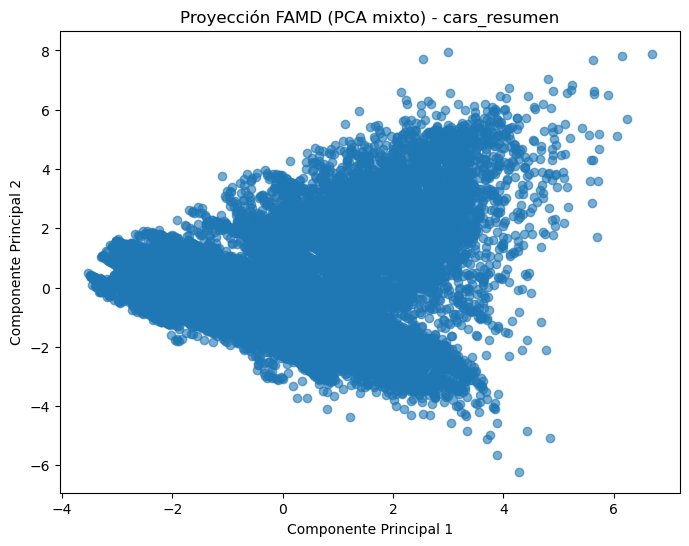

In [45]:
columnas_numericas = [
    'Km recorridos totales',
    'Consumo kWh',
    'Emisiones de CO2 por km (kg/km)',
    'Potencia (cm3)'
]
columnas_categoricas = [
    'Tipo de combustible',
    'Pais',
    'Marca'
]
columnas_analisis = columnas_numericas + columnas_categoricas

df_pca = cars_resumen[columnas_analisis].dropna()

num_muestra = 30000

if len(df_pca) > num_muestra:
    df_pca = df_pca.sample(n=num_muestra, random_state=42)

# Convertir las columnas categóricas a string
for col in columnas_categoricas:
    df_pca[col] = df_pca[col].astype(str)

# Análisis FAMD (PCA mixto)
famd = prince.FAMD(n_components=68, random_state=42)
famd = famd.fit(df_pca)

df_proj = famd.transform(df_pca)
df_proj['Emisiones de CO2 por km (kg/km)'] = df_pca['Emisiones de CO2 por km (kg/km)'].values

# Graficar los dos primeros componentes
plt.figure(figsize=(8,6))
plt.scatter(df_proj[0], df_proj[1], alpha=0.6)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección FAMD (PCA mixto) - cars_resumen')
plt.show()


### 15 - CODO KNN-CLUSTER

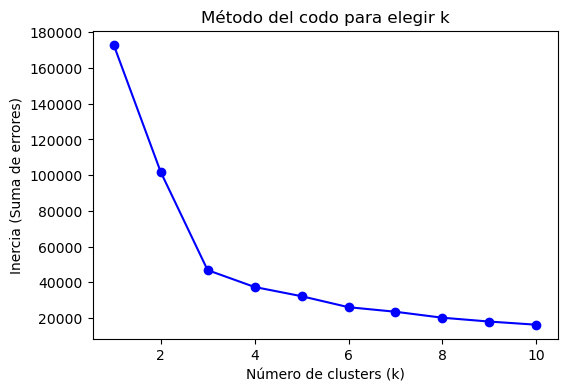

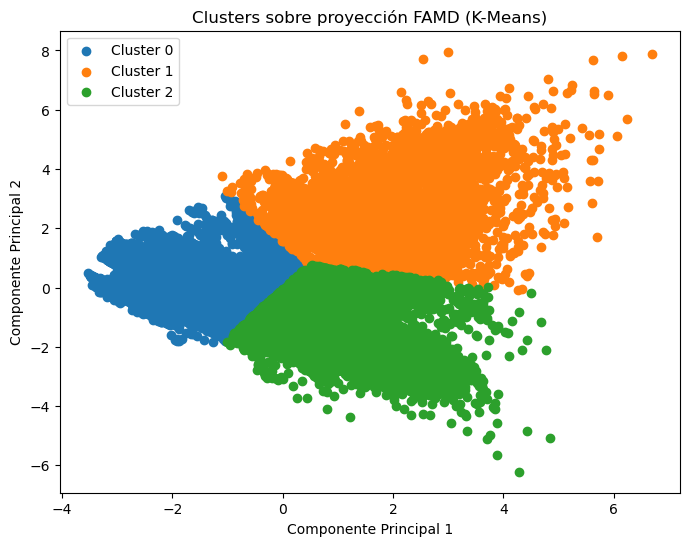

In [46]:
# 1. MÉTODO DEL CODO para elegir el número óptimo de clusters
inertia = []
K = range(1, 11)  # Puedes cambiar el rango según lo que veas en tu gráfico
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_proj[[0, 1]])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de errores)')
plt.title('Método del codo para elegir k')
plt.show()

# 2. ELIJE k según el gráfico del codo
k_optimo = 3

# 3. K-MEANS CLUSTERING FINAL
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_proj['cluster'] = kmeans.fit_predict(df_proj[[0, 1]])

# 4. VISUALIZACIÓN de los clusters
plt.figure(figsize=(8,6))
for cluster in range(k_optimo):
    plt.scatter(df_proj[df_proj['cluster'] == cluster][0],
                df_proj[df_proj['cluster'] == cluster][1],
                label=f'Cluster {cluster}')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters sobre proyección FAMD (K-Means)')
plt.legend()
plt.show()

In [47]:
# Primero, une los clusters a los datos originales que se usaron para el FAMD
df_clusters = df_pca.copy()
df_clusters['cluster'] = df_proj['cluster'].values

# Analiza cada cluster por separado
for c in sorted(df_clusters['cluster'].unique()):
    print(f"\n========================")
    print(f"   ANÁLISIS CLUSTER {c}")
    print(f"========================")

    # Número de autos en el cluster
    print(f"Número de autos en el cluster: {len(df_clusters[df_clusters['cluster'] == c])}")

    # Promedios de variables numéricas
    print("\nPromedio de variables numéricas:")
    display(df_clusters[df_clusters['cluster'] == c][columnas_numericas].mean())

    # Distribución de variables categóricas
    for cat in columnas_categoricas:
        print(f"\nDistribución de '{cat}':")
        display(df_clusters[df_clusters['cluster'] == c][cat].value_counts(normalize=True).head(10))  # top 10



   ANÁLISIS CLUSTER 0
Número de autos en el cluster: 13244

Promedio de variables numéricas:


Km recorridos totales              18644.871655
Consumo kWh                            1.772138
Emisiones de CO2 por km (kg/km)        0.152174
Potencia (cm3)                      1368.717683
dtype: float64


Distribución de 'Tipo de combustible':


Tipo de combustible
gasolina    0.863712
diesel      0.126925
hibrido     0.009363
Name: proportion, dtype: float64


Distribución de 'Pais':


Pais
FR    0.240109
IT    0.171398
DE    0.137798
ES    0.115297
PL    0.075430
BE    0.039414
NL    0.037526
CZ    0.021142
AT    0.020764
HU    0.015856
Name: proportion, dtype: float64


Distribución de 'Marca':


Marca
RENAULT       0.139686
TOYOTA        0.137572
VOLKSWAGEN    0.101027
FIAT          0.096497
FORD          0.070296
DACIA         0.062368
PEUGEOT       0.047644
SKODA         0.039112
MERCEDES      0.032694
CITROEN       0.032090
Name: proportion, dtype: float64


   ANÁLISIS CLUSTER 1
Número de autos en el cluster: 5209

Promedio de variables numéricas:


Km recorridos totales              23301.147572
Consumo kWh                         1249.612248
Emisiones de CO2 por km (kg/km)        0.156371
Potencia (cm3)                      1831.721636
dtype: float64


Distribución de 'Tipo de combustible':


Tipo de combustible
hibrido     0.879247
diesel      0.071799
gasolina    0.048954
Name: proportion, dtype: float64


Distribución de 'Pais':


Pais
DE    0.315992
SE    0.158188
FR    0.138798
BE    0.080438
IT    0.057209
NL    0.047802
FI    0.047226
DK    0.038971
ES    0.034748
PT    0.019006
Name: proportion, dtype: float64


Distribución de 'Marca':


Marca
MERCEDES      0.336917
VOLVO         0.270109
BMW           0.098291
FORD          0.074294
VOLKSWAGEN    0.051833
PEUGEOT       0.039355
JEEP          0.020733
CUPRA         0.014782
LAND ROVER    0.014398
RENAULT       0.013246
Name: proportion, dtype: float64


   ANÁLISIS CLUSTER 2
Número de autos en el cluster: 11547

Promedio de variables numéricas:


Km recorridos totales              27983.383190
Consumo kWh                            3.576314
Emisiones de CO2 por km (kg/km)        0.195457
Potencia (cm3)                      2099.696112
dtype: float64


Distribución de 'Tipo de combustible':


Tipo de combustible
diesel      0.769031
gasolina    0.212696
hibrido     0.018273
Name: proportion, dtype: float64


Distribución de 'Pais':


Pais
DE    0.418723
IT    0.160388
ES    0.065298
FR    0.063480
PL    0.060968
AT    0.040010
BE    0.038711
CZ    0.024335
HU    0.015415
PT    0.013164
Name: proportion, dtype: float64


Distribución de 'Marca':


Marca
MERCEDES      0.291937
BMW           0.181259
VOLKSWAGEN    0.132762
AUDI          0.083398
FORD          0.070321
SKODA         0.054300
VOLVO         0.040703
LAND ROVER    0.039231
PORSCHE       0.015415
JEEP          0.014982
Name: proportion, dtype: float64

In [48]:
# Promedios de las variables numéricas por cluster
tabla_promedios = df_clusters.groupby('cluster')[columnas_numericas].mean().round(2)
display(tabla_promedios)

,Km recorridos totales,Consumo kWh,Emisiones de CO2 por km (kg/km),Potencia (cm3)
cluster,,,,
0,18644.87,1.77,0.15,1368.72
1,23301.15,1249.61,0.16,1831.72
2,27983.38,3.58,0.20,2099.70


cars_resumen.to_csv('cars_resumen.csv', index=False)
vans_resumen.to_csv('vans_resumen.csv', index=False)

### 16 - MODELO: REGRESIÓN LINEAL --> PCA MIX + KNN

R2 score: 0.8659
RMSE: 0.0168
Error relativo: 9.92 %


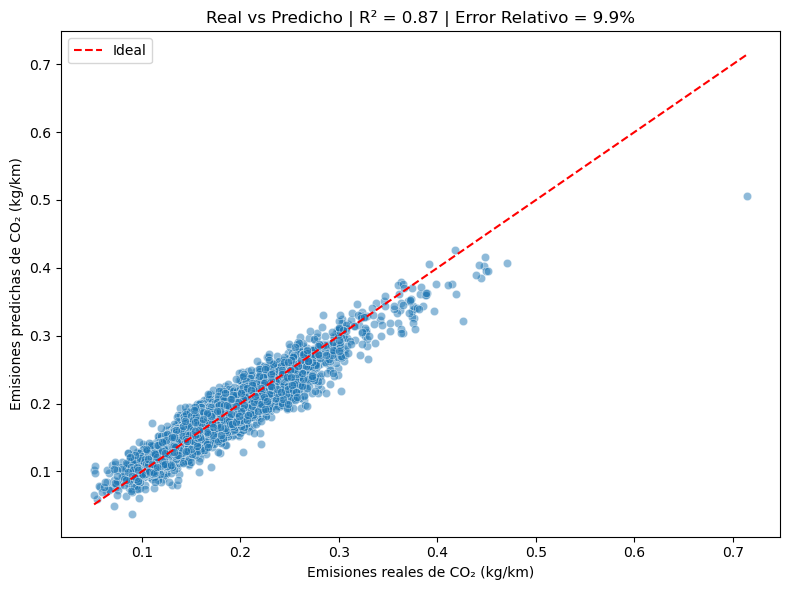

In [49]:
# Convertir la columna 'cluster' a tipo categórico
df_proj['cluster'] = df_proj['cluster'].astype('category')

# Separar X e y
X_model = df_proj.drop(columns='Emisiones de CO2 por km (kg/km)')
y_model = df_proj['Emisiones de CO2 por km (kg/km)']

X_model.columns = X_model.columns.astype(str)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(
    X_model, y_model, 
    train_size=0.75,
    test_size = 0.25,
    random_state=42
)

# Modelo de regresión lineal
lm = LinearRegression()
lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)

# Evaluación
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_pct = rmse / y_test.mean() * 100
print(f"R2 score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Error relativo: {rmse_pct:.2f} %")

# Gráfico
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Emisiones reales de CO₂ (kg/km)")
plt.ylabel("Emisiones predichas de CO₂ (kg/km)")
plt.title(f"Real vs Predicho | R² = {r2:.2f} | Error Relativo = {rmse_pct:.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

### 17 - MODELO: RANDOM FOREST --> PCA MIX + KNN

In [50]:
# Convertir la columna 'cluster' a tipo categórico
df_proj['cluster'] = df_proj['cluster'].astype('category')

# Separar X e y
X_model = df_proj.drop(columns='Emisiones de CO2 por km (kg/km)')
y_model = df_proj['Emisiones de CO2 por km (kg/km)']

X_model.columns = X_model.columns.astype(str)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(
    X_model, y_model, 
    train_size=0.75,
    test_size = 0.25,
    random_state=42
)

# Modelo de regresión lineal
lm = RandomForestRegressor(max_depth=20, random_state=42)
lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)

# Evaluación
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_pct = rmse / y_test.mean() * 100
print(f"R2 score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Error relativo: {rmse_pct:.2f} %")

R2 score: 0.9408
RMSE: 0.0112
Error relativo: 6.59 %


### 18 - GRÁFICOS

C:\Users\ivan_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


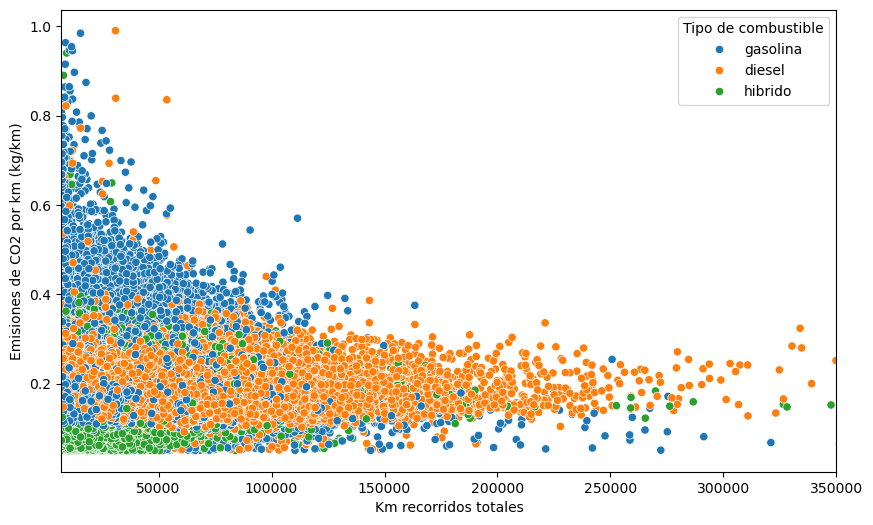

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = cars_resumen, x = 'Km recorridos totales', y = 'Emisiones de CO2 por km (kg/km)', hue = 'Tipo de combustible')
plt.xlim(7000, 350000) 
plt.show()

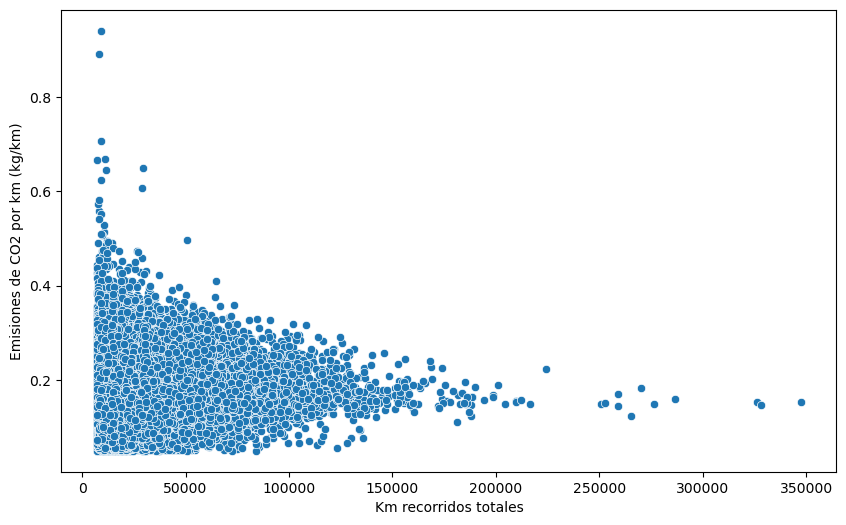

In [52]:
# Filtrar solo los autos híbridos
hibridos = cars_resumen[cars_resumen['Tipo de combustible'] == 'hibrido']

# Crear el scatterplot solo con híbridos
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=hibridos,
    x='Km recorridos totales',
    y='Emisiones de CO2 por km (kg/km)',
)

- A menos km más emisiones, ya que en distancias cortas un coche contamina más.
- Los diesel las emisiones son constantes
- El filtro de regeneración de partículas funciona mejor en distancias largas
- A partir de 150000 km los coches empiezan a ser más eficientes
- Los coches híbridos contaminan menos cuanto más km tengan

C:\Users\ivan_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


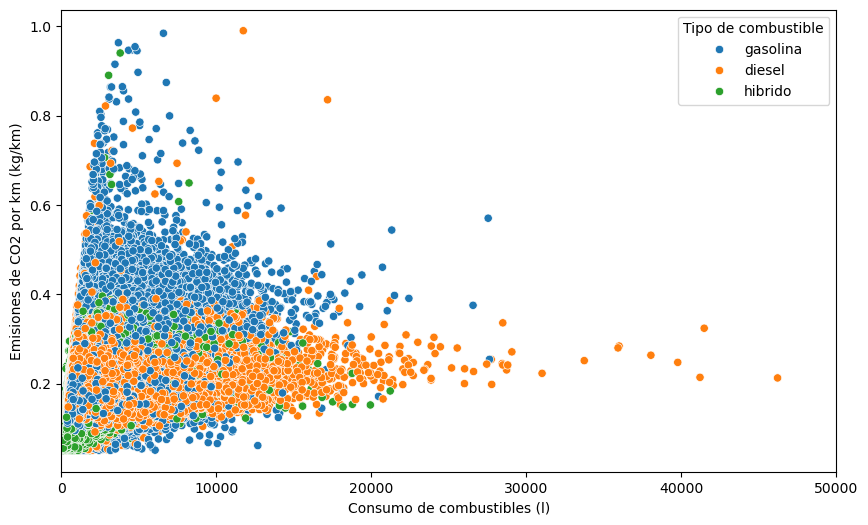

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = cars_resumen, x = 'Consumo de combustibles (l)', y = 'Emisiones de CO2 por km (kg/km)', hue = 'Tipo de combustible')
plt.xlim(0, 50000) 
plt.show()

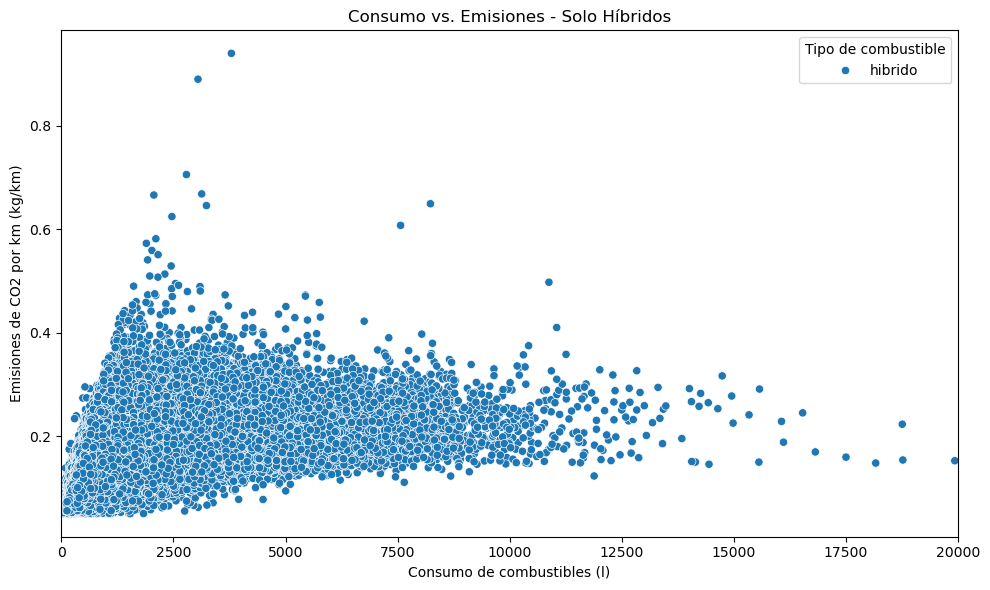

In [54]:
# Filtrar autos híbridos
hibridos = cars_resumen[cars_resumen['Tipo de combustible'] == 'hibrido']

# Crear scatterplot solo con híbridos
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=hibridos,
    x='Consumo de combustibles (l)',
    y='Emisiones de CO2 por km (kg/km)',
    hue='Tipo de combustible'  # En este caso todos serán "Híbrido"
)

# Ajustes de eje
plt.xlim(0, 20000)
plt.title('Consumo vs. Emisiones - Solo Híbridos')
plt.tight_layout()
plt.show()

- En coches diesel el consumo de combustible no influye en las emisiones, ya que son constantes
- Los gasolina consumen menos combustible pero emiten más, también porque hacen menos km
- Los híbridos gastan menos combustible y las emisiones constantes

C:\Users\ivan_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


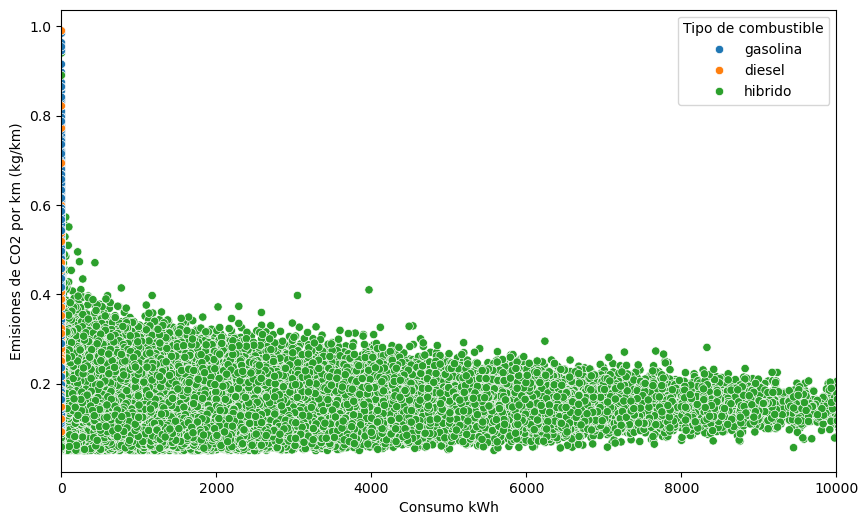

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = cars_resumen, x = 'Consumo kWh', y = 'Emisiones de CO2 por km (kg/km)', hue = 'Tipo de combustible')
plt.xlim(0, 10000) 
plt.show()

- El consumo de kWh solo se da en coches híbridos, en diesel y gasolina es 0
- Cuanta más batería gasta menos emite, porque usa el motor eléctrico en lugar del de combustión.

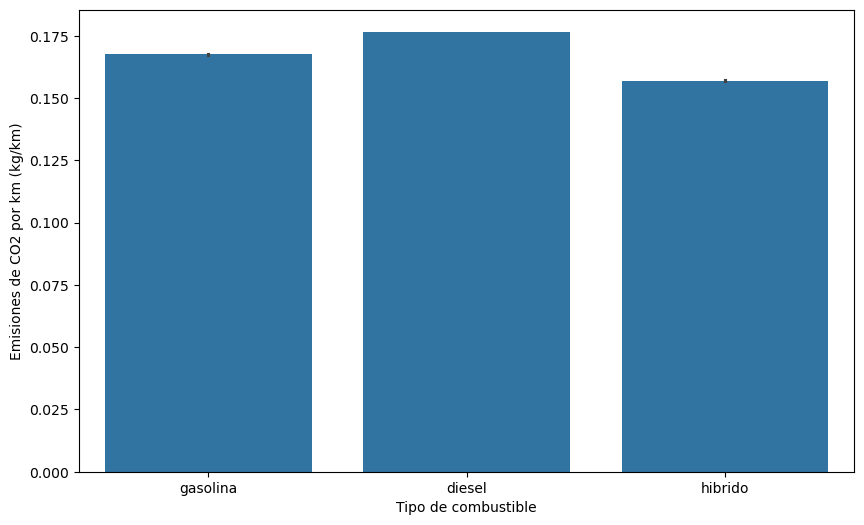

In [56]:
plt.figure(figsize=(10, 6))
sns.barplot(data = cars_resumen, x = 'Tipo de combustible', y = 'Emisiones de CO2 por km (kg/km)')
plt.show()

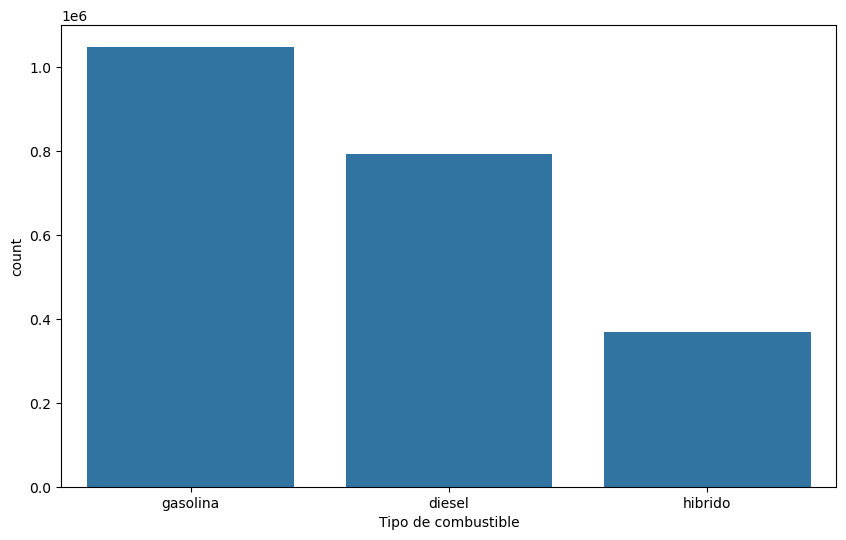

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(x = cars_resumen['Tipo de combustible'])
plt.show()

- En este estudio, los coches de gasolina son los más abundantes, seguido de los diesel y por último los híbridos

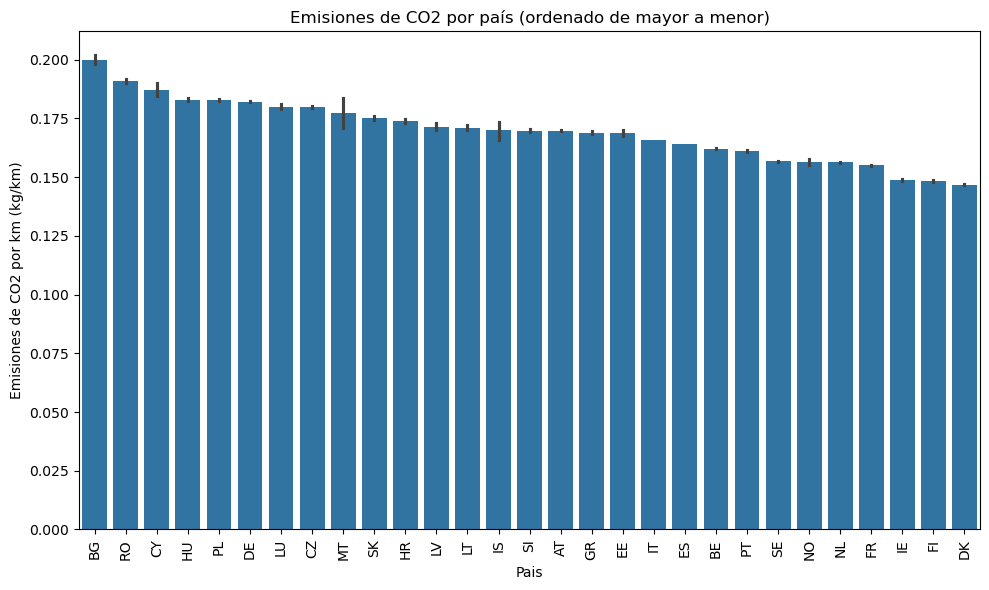

In [58]:
# Calcular el orden de los países de mayor a menor emisión
orden_paises = cars_resumen.groupby('Pais')['Emisiones de CO2 por km (kg/km)'].mean().sort_values(ascending=False).index

# Gráfico ordenado
plt.figure(figsize=(10, 6))
sns.barplot(data=cars_resumen, x='Pais', y='Emisiones de CO2 por km (kg/km)', order=orden_paises)
plt.xticks(rotation=90)
plt.title('Emisiones de CO2 por país (ordenado de mayor a menor)')
plt.tight_layout()
plt.show()

In [59]:
orden_paises = cars_resumen.groupby('Pais')['Emisiones de CO2 por km (kg/km)'].mean().sort_values(ascending=False)
orden_paises.head(3)

Pais
BG    0.199962
RO    0.190859
CY    0.187218
Name: Emisiones de CO2 por km (kg/km), dtype: float64

In [60]:
paises_filtrados = ['BG', 'RO', 'CY']
cars_filtrados = cars_resumen[cars_resumen['Pais'].isin(paises_filtrados)]

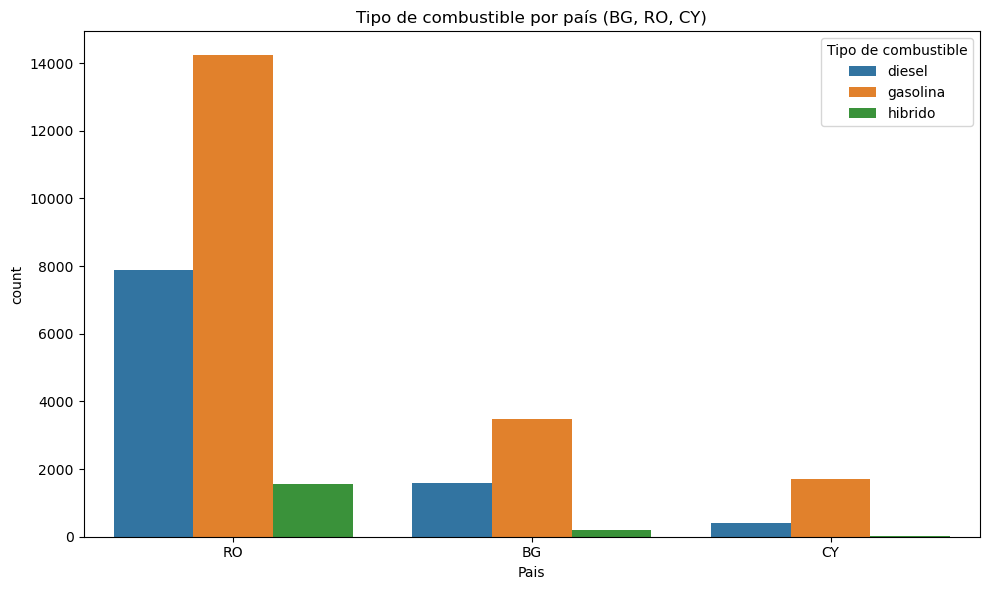

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cars_filtrados, x='Pais', hue='Tipo de combustible')
plt.title('Tipo de combustible por país (BG, RO, CY)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
orden_paises = cars_resumen.groupby('Pais')['Emisiones de CO2 por km (kg/km)'].mean().sort_values(ascending=False)
orden_paises.tail(3)

Pais
IE    0.148853
FI    0.148138
DK    0.146817
Name: Emisiones de CO2 por km (kg/km), dtype: float64

In [63]:
paises_filtrados = ['IE', 'FI', 'DK']
cars_filtrados = cars_resumen[cars_resumen['Pais'].isin(paises_filtrados)]

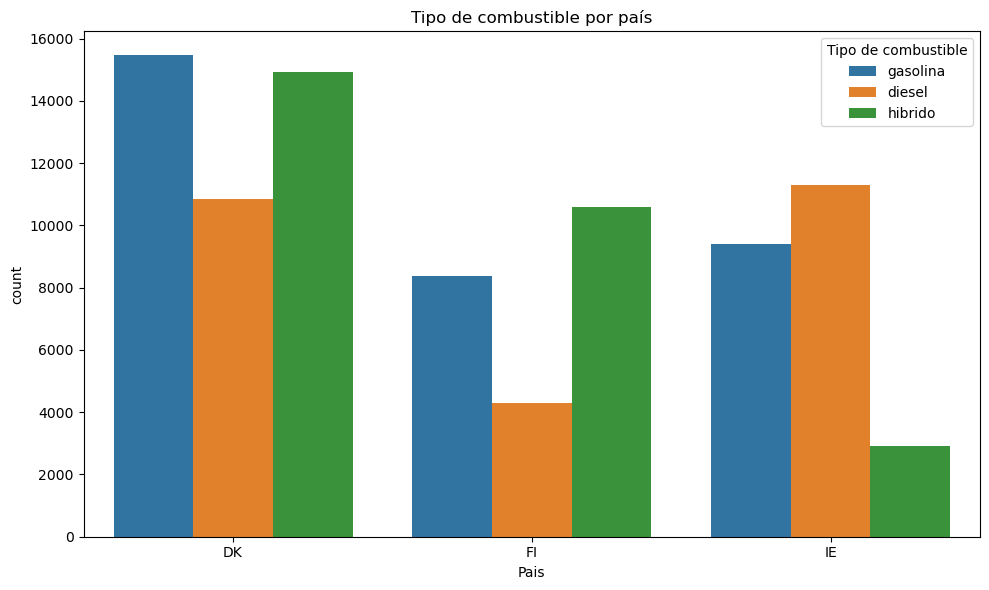

In [64]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cars_filtrados, x='Pais', hue='Tipo de combustible')
plt.title('Tipo de combustible por país')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

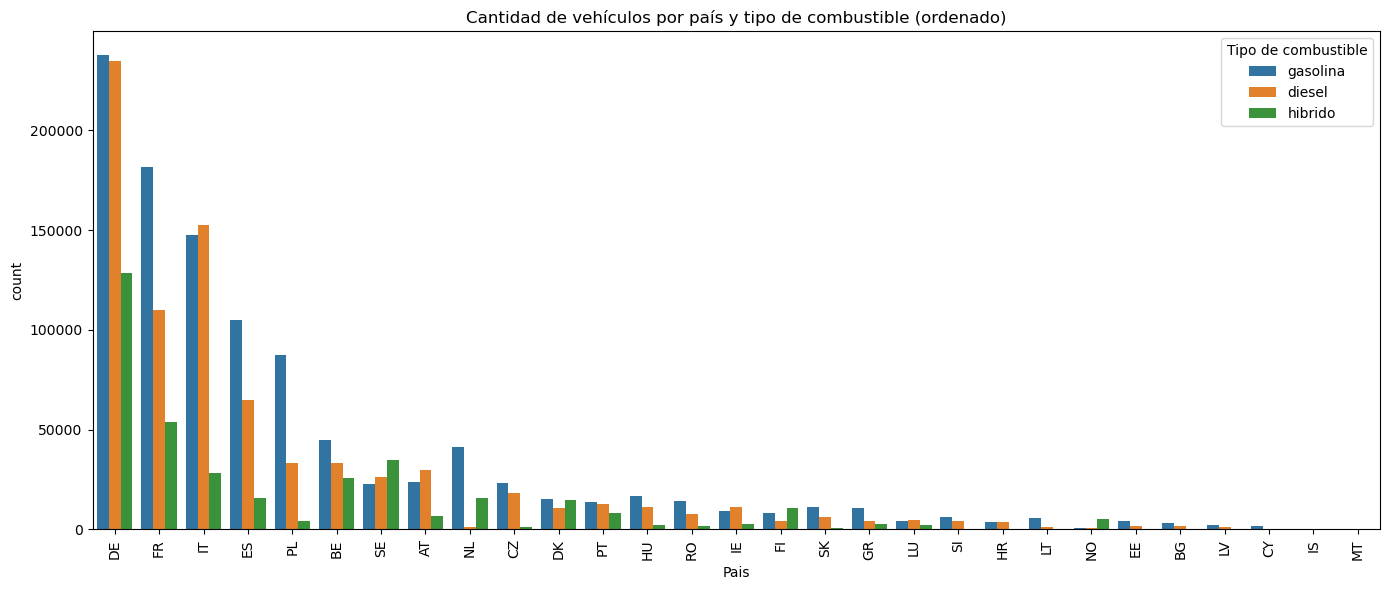

In [65]:
orden_paises = cars_resumen['Pais'].value_counts().index

# Crear el gráfico ordenado
plt.figure(figsize=(14, 6))
sns.countplot(data=cars_resumen, x='Pais', hue='Tipo de combustible', order=orden_paises)
plt.xticks(rotation=90)
plt.title('Cantidad de vehículos por país y tipo de combustible (ordenado)')
plt.tight_layout()
plt.show()

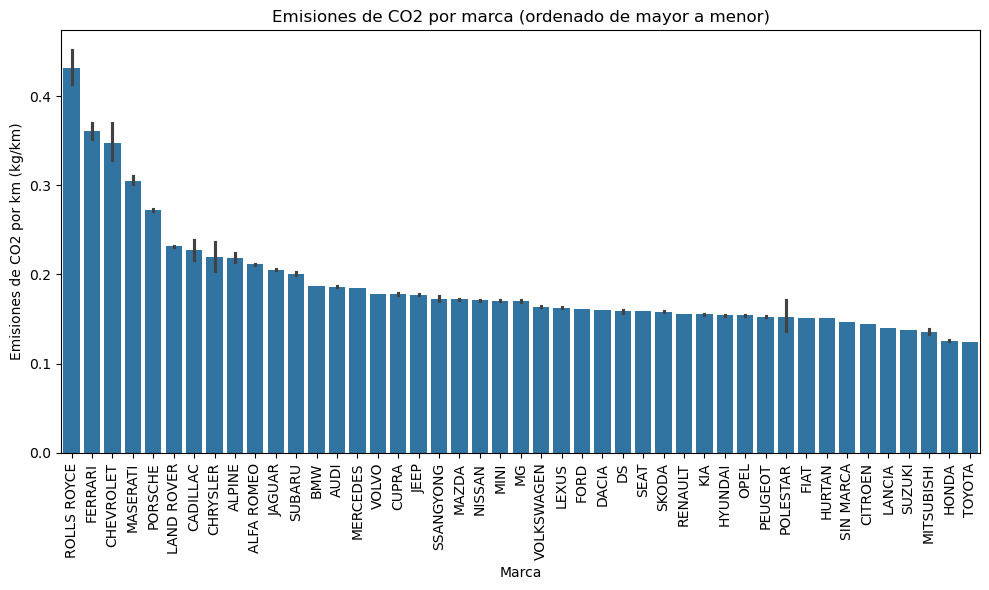

In [66]:
# Calcular el orden de las marcas de mayor a menor emisión
orden_marcas = cars_resumen.groupby('Marca')['Emisiones de CO2 por km (kg/km)'].mean().sort_values(ascending=False).index

# Gráfico ordenado
plt.figure(figsize=(10, 6))
sns.barplot(data=cars_resumen, x='Marca', y='Emisiones de CO2 por km (kg/km)', order=orden_marcas)
plt.xticks(rotation=90)
plt.title('Emisiones de CO2 por marca (ordenado de mayor a menor)')
plt.tight_layout()
plt.show()

In [67]:
orden_marcas = cars_resumen.groupby('Marca')['Emisiones de CO2 por km (kg/km)'].mean().sort_values(ascending=False)
orden_marcas.head(3)

Marca
ROLLS ROYCE    0.431738
FERRARI        0.360441
CHEVROLET      0.347317
Name: Emisiones de CO2 por km (kg/km), dtype: float64

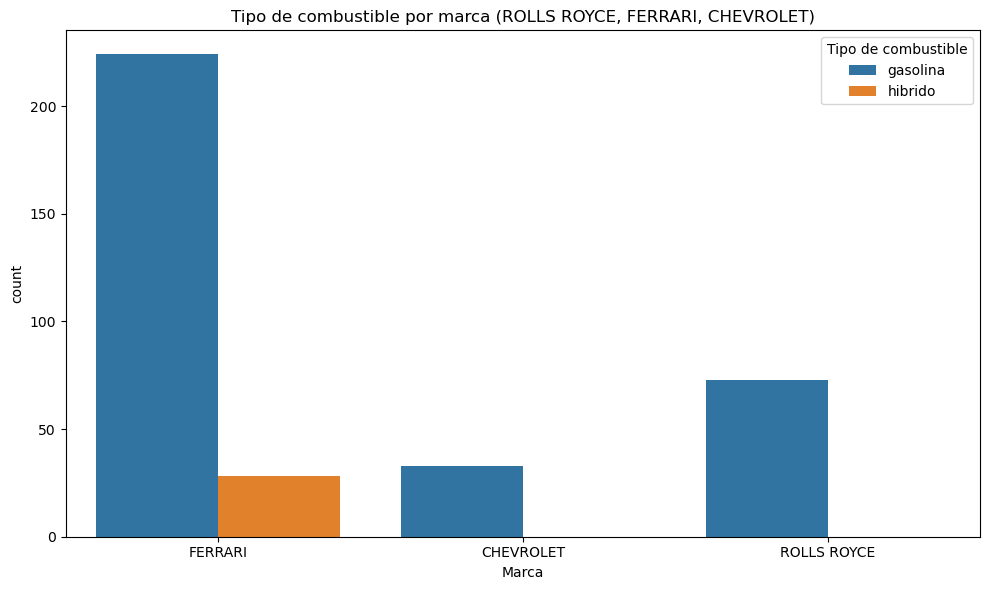

In [68]:
# Lista de marcas que quieres filtrar
marcas_deseadas = ['ROLLS ROYCE', 'FERRARI', 'CHEVROLET']

# Filtrar el DataFrame
marcas_filtradas = cars_resumen[cars_resumen['Marca'].isin(marcas_deseadas)]

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.countplot(data=marcas_filtradas, x='Marca', hue='Tipo de combustible')
plt.title('Tipo de combustible por marca (ROLLS ROYCE, FERRARI, CHEVROLET)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

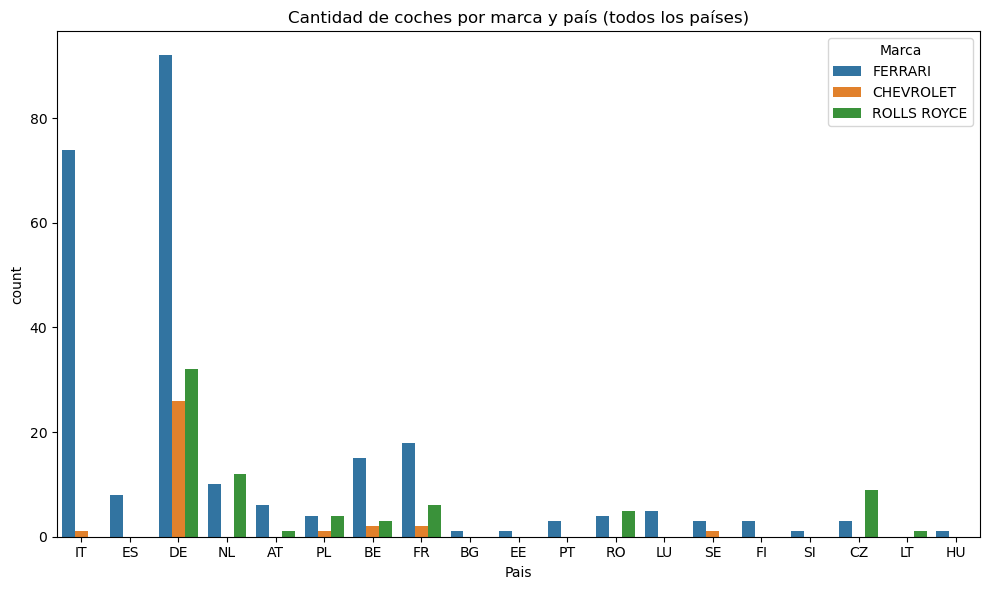

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(data=marcas_filtradas, x='Pais', hue='Marca')
plt.title('Cantidad de coches por marca y país (todos los países)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [70]:
orden_marcas.tail(3)

Marca
MITSUBISHI    0.135690
HONDA         0.125718
TOYOTA        0.124581
Name: Emisiones de CO2 por km (kg/km), dtype: float64

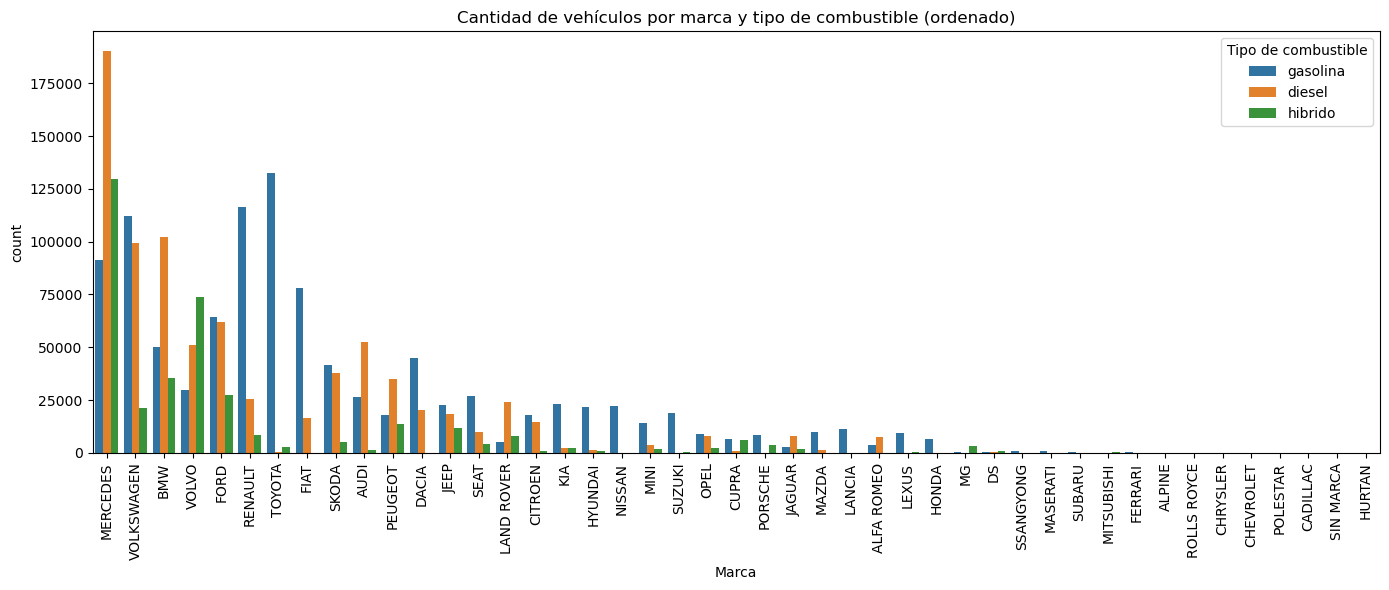

In [71]:
# Calcular el orden de las marcas por cantidad de vehículos
orden_marcas = cars_resumen['Marca'].value_counts().index

# Crear el gráfico ordenado
plt.figure(figsize=(14, 6))
sns.countplot(data=cars_resumen, x='Marca', hue='Tipo de combustible', order=orden_marcas)
plt.xticks(rotation=90)
plt.title('Cantidad de vehículos por marca y tipo de combustible (ordenado)')
plt.tight_layout()
plt.show()

C:\Users\ivan_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


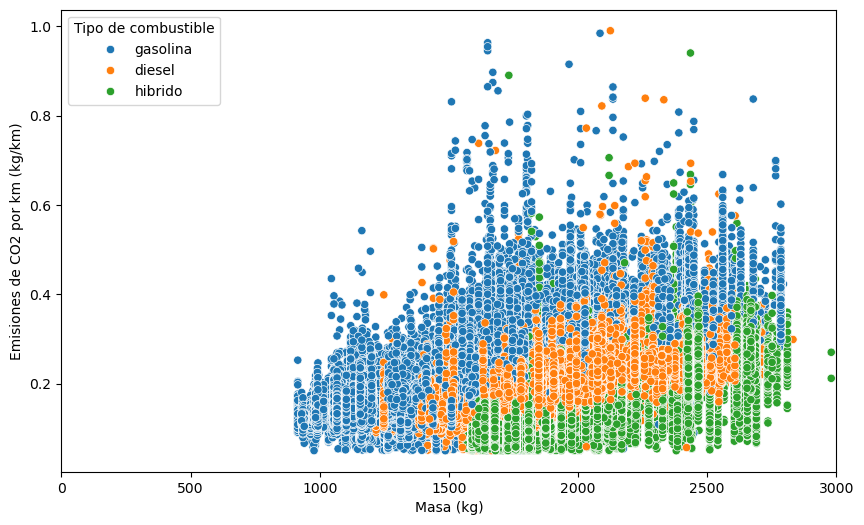

In [72]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 3000) 
sns.scatterplot(data = cars_resumen, x = 'Masa (kg)', y = 'Emisiones de CO2 por km (kg/km)', hue = 'Tipo de combustible')
plt.show()

C:\Users\ivan_\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


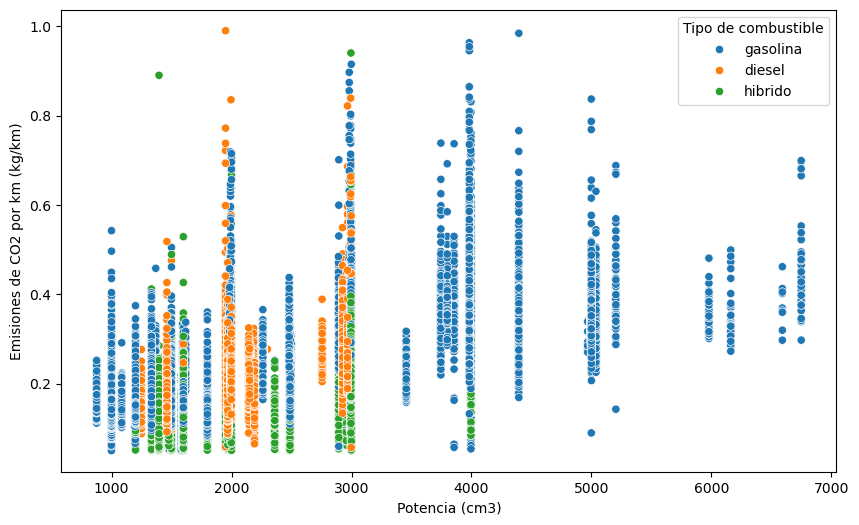

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = cars_resumen, x = 'Potencia (cm3)', y = 'Emisiones de CO2 por km (kg/km)', hue = 'Tipo de combustible')
plt.show()

### 19 - CONCLUSIONES

El parque automotor se segmenta en tres grandes grupos:

- Autos ligeros, a gasolina: los más numerosos y menos contaminantes.
- Autos híbridos: grupo más pequeño, potencia intermedia, con consumo eléctrico alto y emisiones similares a los gasolina, lo que muestra que la electrificación reduce emisiones, pero no siempre garantiza el menor impacto. 
- Autos diésel, potentes: alto kilometraje y potencia, pero son los más contaminantes en promedio.


### 20 - APLICACIONES

- Conocer la contaminación de una marca para tomar la decisión de comprarlo.
- Comparar con los datos de emisiones de los fabricantes.
- Incentivar ayudas económicas para comprar marcas menos contaminantes.
- Segmentación del mercado para campañas de marketing.
- Aplicar sanciones a marcas que no cumplan los estándares mínimos de emisiones.
- Estrategias de sostenibilidad y reducción de emisiones.
- Optimización de flotas en empresas.
- Conocer si un vehículo puede acceder a ZBE.
- Simulación de emisiones del parque automovilístico de un país.
- Optimización del diseño de motores para reducir emisiones.


### resumen.to

In [74]:
cars_resumen.to_csv('cars_resumen.csv', index=False)